# I) Import the necessary packages

In [3]:
import matplotlib.ticker as ticker
from scipy.stats import f_oneway
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import warnings
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Regression models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

from sklearn.inspection import permutation_importance

# II) Get the data

## 1) Import csv file

In [6]:
full_data = pd.read_csv('chip_dataset.csv')

## 2) Rename features

In [8]:
full_data = full_data.rename(columns={
    "Process Size (nm)": "Process Size",
    "TDP (W)": "TDP",
    "Die Size (mm^2)": "Die Size",
    "Transistors (million)": "Transistors",
    "Freq (MHz)": "Freq"
})

# III) Explore the Data

## 1) Quick glance at the data

In [11]:
full_data.head()

Unnamed: 0                  Product Type Release Date  Process Size    TDP  \
0           0      AMD Athlon 64 3500+  CPU   2007-02-20          65.0   45.0   
1           1         AMD Athlon 200GE  CPU   2018-09-06          14.0   35.0   
2           2     Intel Core i5-1145G7  CPU   2020-09-02          10.0   28.0   
3           3    Intel Xeon E5-2603 v2  CPU   2013-09-01          22.0   80.0   
4           4  AMD Phenom II X4 980 BE  CPU   2011-05-03          45.0  125.0   

   Die Size  Transistors    Freq  Foundry Vendor  FP16 GFLOPS  FP32 GFLOPS  \
0      77.0        122.0  2200.0  Unknown    AMD          NaN          NaN   
1     192.0       4800.0  3200.0  Unknown    AMD          NaN          NaN   
2       NaN          NaN  2600.0    Intel  Intel          NaN          NaN   
3     160.0       1400.0  1800.0    Intel  Intel          NaN          NaN   
4     258.0        758.0  3700.0  Unknown    AMD          NaN          NaN   

   FP64 GFLOPS  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN

In [12]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4854 entries, 0 to 4853
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    4854 non-null   int64  
 1   Product       4854 non-null   object 
 2   Type          4854 non-null   object 
 3   Release Date  4854 non-null   object 
 4   Process Size  4845 non-null   float64
 5   TDP           4228 non-null   float64
 6   Die Size      4139 non-null   float64
 7   Transistors   4143 non-null   float64
 8   Freq          4854 non-null   float64
 9   Foundry       4854 non-null   object 
 10  Vendor        4854 non-null   object 
 11  FP16 GFLOPS   536 non-null    float64
 12  FP32 GFLOPS   1948 non-null   float64
 13  FP64 GFLOPS   1306 non-null   float64
dtypes: float64(8), int64(1), object(5)
memory usage: 531.0+ KB


In [13]:
full_data.describe()

Unnamed: 0  Process Size          TDP     Die Size   Transistors  \
count  4854.000000   4845.000000  4228.000000  4139.000000   4143.000000   
mean   2426.500000     55.109598    81.359981   188.440445   1929.922279   
std    1401.373433     44.998676    76.807808   126.189383   4044.891098   
min       0.000000      0.000000     1.000000     1.000000      8.000000   
25%    1213.250000     22.000000    33.000000   104.000000    154.000000   
50%    2426.500000     40.000000    65.000000   148.000000    624.000000   
75%    3639.750000     90.000000   100.000000   239.000000   1550.000000   
max    4853.000000    250.000000   900.000000   826.000000  54200.000000   

              Freq    FP16 GFLOPS   FP32 GFLOPS   FP64 GFLOPS  
count  4854.000000     536.000000   1948.000000   1306.000000  
mean   1484.406057    8397.459851   2134.756653    363.670511  
std    1066.701523   13799.551131   3898.431487   1145.931856  
min     100.000000      10.020000     12.800000      3.600000  
25%     590.000000     768.800000    257.300000     38.295000  
50%    1073.500000    2965.500000    696.000000     89.280000  
75%    2400.000000   10600.000000   2116.750000    220.000000  
max    4700.000000  184600.000000  40000.000000  11540.000000

<Axes: >

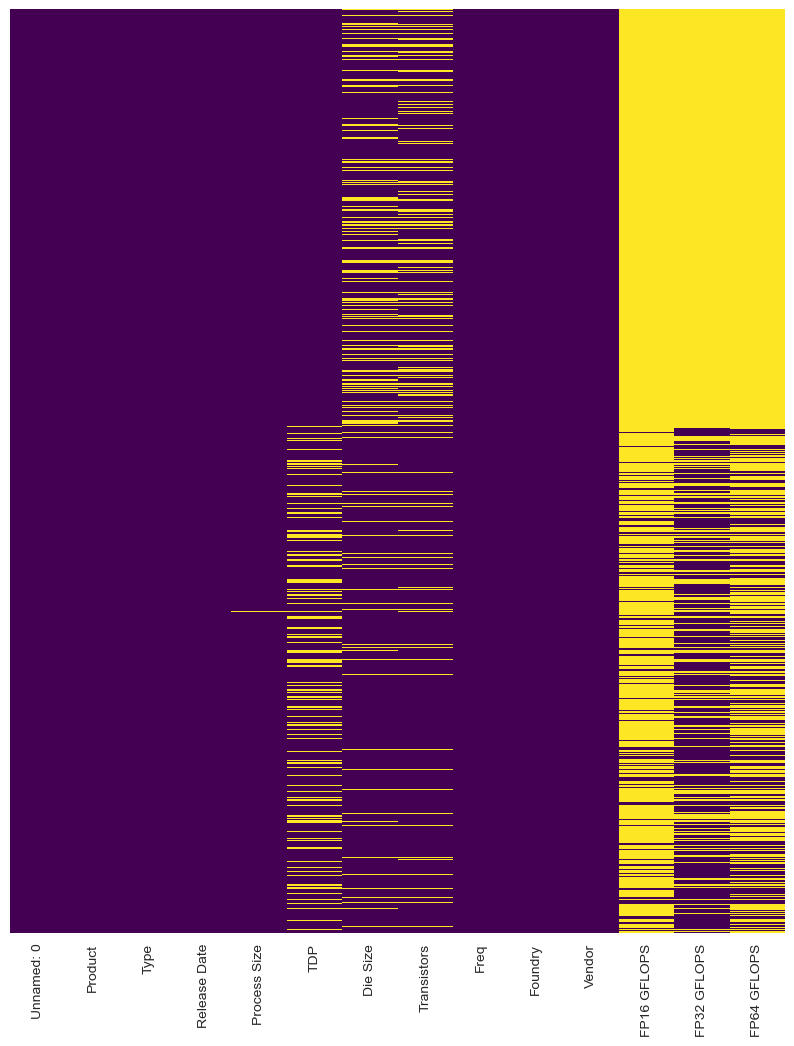

In [14]:
plt.figure(figsize=(10,12))
sns.heatmap(full_data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [15]:
full_data.nunique()

Unnamed: 0      4854
Product         4278
Type               2
Release Date    1357
Process Size      22
TDP              200
Die Size         191
Transistors      196
Freq             527
Foundry           10
Vendor             5
FP16 GFLOPS      343
FP32 GFLOPS      821
FP64 GFLOPS      672
dtype: int64

In [16]:
full_data.isnull().sum()

Unnamed: 0         0
Product            0
Type               0
Release Date       0
Process Size       9
TDP              626
Die Size         715
Transistors      711
Freq               0
Foundry            0
Vendor             0
FP16 GFLOPS     4318
FP32 GFLOPS     2906
FP64 GFLOPS     3548
dtype: int64

## 2) Functions used to explore each feature

In [18]:
def get_value_counts_summary(df, feature):
    """
    Trả về bảng gồm: số lần xuất hiện và tần suất phần trăm của từng giá trị trong feature.
    """
    counts = df[feature].value_counts(dropna=False)
    freqs = df[feature].value_counts(normalize=True, dropna=False) * 100
    summary = pd.concat([counts, freqs], axis=1)
    summary.columns = ['Count', 'Frequency (%)']
    return summary


def summarize_feature(df, feature, show=True):
    """
    Hiển thị hoặc trả về thông tin tổng quan của một feature:
    - Kiểu dữ liệu
    - Thống kê mô tả
    - Tỷ lệ thiếu dữ liệu
    - Bảng count & tần suất
    """
    summary = {}

    # Loại dữ liệu
    dtype = df[feature].dtype
    summary['Data Type'] = dtype

    # Mô tả thống kê
    if pd.api.types.is_numeric_dtype(dtype):
        desc = df[feature].describe()
    else:
        desc = df[feature].describe(include='all')

    summary['Description'] = desc

    # Tính toán missing values
    null_count = df[feature].isna().sum()
    total_count = len(df)
    null_pct = (null_count / total_count) * 100
    summary['Missing Count'] = null_count
    summary['Missing (%)'] = null_pct

    # Bảng count & tần suất
    value_summary = get_value_counts_summary(df, feature)
    summary['Value Counts'] = value_summary

    # In kết quả
    if show:
        print(f"{'='*60}")
        print(f"🔍 Feature: {feature}")
        print(f"{'-'*60}")
        print("📌 Data Type:", dtype)
        print("❗ Missing Values: {} ({:.2f}%)".format(null_count, null_pct))
        print(f"{'-'*60}")
        print("📊 Description:")
        print(desc)
        print(f"{'-'*60}")
        print("🔢 Value Counts (All):")
        print(value_summary)
        print(f"{'='*60}\n")
    else:
        return summary


In [19]:
def create_pie_plot(df, feature, figsize=(8, 8), save_path=None):
    """
    Vẽ biểu đồ tròn cho feature. Tự động lấy top 10 nếu quá nhiều phân loại.
    Giao diện hiện đại: nền sáng, màu pastel, legend bên phải.
    """
    # Tính toán số lượng và tần suất
    counts = df[feature].value_counts(dropna=False)
    freqs = df[feature].value_counts(normalize=True, dropna=False) * 100

    # Lấy top 10 nếu cần
    if len(counts) > 10:
        counts = counts.head(10)
        freqs = freqs.head(10)
        print(f"📌 Feature '{feature}' có hơn 10 phân loại. Hiển thị top 10 phổ biến nhất.")

    labels = counts.index
    sizes = freqs.values
    legend_labels = [f"{str(label)} ({counts.loc[label]})" for label in labels]

    # Nền trắng xám nhạt
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor('#f7f7f7')

    # Danh sách 10 màu pastel sáng khác nhau
    colors = [
        "#FFB3BA", "#FFDFBA", "#FFFFBA", "#BAFFC9", "#BAE1FF",
        "#D5BAFF", "#FFC4E1", "#C4FFFF", "#E6FFBA", "#FFBACD"
    ][:len(labels)]

    # Vẽ pie chart
    wedges, texts, autotexts = ax.pie(
        sizes,
        labels=None,
        autopct='%1.2f%%',
        startangle=90,
        colors=colors,
        wedgeprops={'edgecolor': 'black'},
        textprops={'fontsize': 10}
    )

    ax.set_title(f"Pie Chart of '{feature}'", fontsize=14)
    ax.axis('equal')

    # Legend bên phải
    ax.legend(wedges, legend_labels, title="Labels", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=9)

    # Lưu nếu có đường dẫn
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', facecolor=fig.get_facecolor())
        print(f"✅ Biểu đồ được lưu tại: {save_path}")

    plt.show()


In [20]:
def create_bar_plot(df, feature, figsize=(10, 6), save_path=None):
    """
    Vẽ biểu đồ cột cho một feature.
    Nền biểu đồ sáng, màu cột là các màu pastel tùy chỉnh.
    Nếu có hơn 10 nhóm → chỉ hiển thị top 10.
    """
    # Tính đếm và tần suất
    value_counts = df[feature].value_counts(dropna=False)
    value_freq = df[feature].value_counts(normalize=True, dropna=False) * 100

    if len(value_counts) > 10:
        print(f"📌 Feature {feature} có hơn 10 nhóm. Hiển thị top 10 phổ biến nhất.")
        value_counts = value_counts.head(10)
        value_freq = value_freq.head(10)

    labels = value_counts.index.astype(str).tolist()
    counts = value_counts.values
    freqs = value_freq.values

    plot_df = pd.DataFrame({
        feature: labels,
        'Count': counts,
        'Frequency (%)': freqs
    })

    # Màu pastel tùy chỉnh
    colors = [
        "#FFB3BA", "#FFDFBA", "#FFFFBA", "#BAFFC9", "#BAE1FF",
        "#D5BAFF", "#FFC4E1", "#C4FFFF", "#E6FFBA", "#FFBACD"
    ][:len(labels)]

    # Giao diện nền sáng
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=figsize, facecolor='#f5f5f5')
    ax.set_facecolor('#f5f5f5')

    # Vẽ biểu đồ
    bars = sns.barplot(
        x=feature,
        y='Count',
        data=plot_df,
        palette=colors,
        edgecolor='black',
        ax=ax,
        width=0.6
    )

    # Hiển thị giá trị
    for i, row in plot_df.iterrows():
        ax.text(i, row['Count'] + max(counts)*0.01,
                f"{row['Count']} ({row['Frequency (%)']:.1f}%)",
                ha='center', va='bottom', fontsize=10, color='black')

    # Tùy chỉnh trục và tiêu đề
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel("Count", fontsize=12)
    ax.set_title(f"Bar Chart of {feature}", fontsize=14, weight='bold')
    ax.set_xticklabels(labels, rotation=45, ha='right')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', facecolor=fig.get_facecolor())
        print(f"✅ Bar chart saved to: {save_path}")

    plt.show()


In [21]:
def create_box_plot(df, feature, figsize=(10, 6), box_color="#FFB3BA", clip_outliers=True, clip_percentile=99):
    """
    Vẽ 2 boxplot song song:
    - Boxplot gốc (full data)
    - Boxplot cắt outliers trên clip_percentile
    """
    sns.set(style="whitegrid")

    data_full = df[feature].dropna()
    clip_value = np.percentile(data_full, clip_percentile)
    data_clipped = data_full[data_full <= clip_value]

    fig, axes = plt.subplots(1, 2, figsize=figsize, facecolor="#f5f5f5")
    for ax in axes:
        ax.set_facecolor("#f5f5f5")

    # Boxplot gốc
    sns.boxplot(y=data_full, color=box_color, ax=axes[0], width=0.5, fliersize=4)
    axes[0].set_title(f"{feature} - Full Data (with outliers)", fontsize=13, weight='bold')
    axes[0].set_ylabel('')
    axes[0].grid(True, axis='y', linestyle='--', alpha=0.7)
    max_val_full = data_full.max()
    if max_val_full >= 1000:
        axes[0].get_yaxis().set_major_formatter(
            ticker.FuncFormatter(lambda x, _: format(int(x), ',')))
    elif max_val_full < 10:
        axes[0].get_yaxis().set_major_formatter(
            ticker.FuncFormatter(lambda x, _: f"{x:.2f}"))

    # Boxplot cắt outliers
    sns.boxplot(y=data_clipped, color=box_color, ax=axes[1], width=0.5, fliersize=4)
    axes[1].set_title(f"{feature} - Clipped at P{clip_percentile}", fontsize=13, weight='bold')
    axes[1].set_ylabel('')
    axes[1].grid(True, axis='y', linestyle='--', alpha=0.7)
    max_val_clip = data_clipped.max()
    if max_val_clip >= 1000:
        axes[1].get_yaxis().set_major_formatter(
            ticker.FuncFormatter(lambda x, _: format(int(x), ',')))
    elif max_val_clip < 10:
        axes[1].get_yaxis().set_major_formatter(
            ticker.FuncFormatter(lambda x, _: f"{x:.2f}"))

    plt.tight_layout()
    plt.show()


In [22]:
def compare_hist_with_clip(df, feature, bins=50, kde=True, clip_percentile=99, hist_color="#FFB3BA"):
    """
    Hiển thị 2 biểu đồ:
    - Gốc (có outliers)
    - Đã cắt outlier trên PXX
    """
    sns.set(style="whitegrid")

    data_full = df[feature].dropna()
    clip_value = np.percentile(data_full, clip_percentile)
    data_clipped = data_full[data_full <= clip_value]

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), facecolor="#f5f5f5")
    for ax in axes:
        ax.set_facecolor("#f5f5f5")

    # Biểu đồ gốc
    sns.histplot(data_full, bins=bins, kde=kde, color=hist_color, ax=axes[0])
    axes[0].set_title(f'{feature} - Full Distribution', fontsize=12, weight='bold')
    axes[0].set_xlabel(feature)
    axes[0].set_ylabel("Frequency")
    if data_full.max() >= 1000:
        axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: format(int(x), ',')))

    # Biểu đồ cắt PXX
    sns.histplot(data_clipped, bins=bins, kde=kde, color=hist_color, ax=axes[1])
    axes[1].set_title(f'{feature} - Clipped at P{clip_percentile}', fontsize=12, weight='bold')
    axes[1].set_xlabel(feature)
    axes[1].set_ylabel("Frequency")
    if data_clipped.max() >= 1000:
        axes[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: format(int(x), ',')))

    plt.tight_layout()
    plt.show()


In [23]:
def analyze_numerical_feature(df, feature):
    print(f"===== Summary of feature: {feature} =====\n")
    summarize_feature(df, feature)
    print("\n===== Box Plot =====\n")
    create_box_plot(df, feature)
    print("\n===== Histogram Comparison (Full vs Clipped) =====\n")
    compare_hist_with_clip(df, feature)

In [24]:
def analyze_categorical_feature(df, feature):
    print(f"===== Summary of feature: {feature} =====\n")
    summarize_feature(df, feature)
    
    print("\n===== Pie Chart =====\n")
    create_pie_plot(df, feature)
    
    print("\n===== Bar Chart =====\n")
    create_bar_plot(df, feature)

In [25]:
def process_datetime_feature(df, feature, hist_color="#FFB3BA"):  
    df_copy = df.copy()

    # Chuyển sang datetime
    df_copy[feature] = pd.to_datetime(df_copy[feature], errors='coerce')  # Nếu có lỗi format sẽ thành NaT

    # Tạo các cột phân loại dạng số nguyên hỗ trợ NaN
    df_copy[f"{feature} Day"] = df_copy[feature].dt.day.astype(pd.Int64Dtype()).astype("category")
    df_copy[f"{feature} Month"] = df_copy[feature].dt.month.astype(pd.Int64Dtype()).astype("category")
    df_copy[f"{feature} Quarter"] = df_copy[feature].dt.quarter.astype(pd.Int64Dtype()).astype("category")
    df_copy[f"{feature} Year"] = df_copy[feature].dt.year.astype(pd.Int64Dtype()).astype("category")

    new_features = [
        f"{feature} Day", f"{feature} Month", f"{feature} Quarter", f"{feature} Year"
    ]

    sns.set(style="whitegrid")

    for feat in new_features:
        print(f"===== Summary of feature: {feat} =====\n")
        summarize_feature(df_copy, feat)

        plt.figure(figsize=(16, 6), facecolor="#f5f5f5")
        ax = sns.countplot(x=feat, data=df_copy, color=hist_color)
        ax.set_facecolor("#f5f5f5")
        ax.set_title(f'Frequency of {feat}', fontsize=12, weight='bold')
        ax.set_xlabel(feat)
        ax.set_ylabel('Count')
        plt.tight_layout()
        plt.show()


## 3) Univariate analysis

### 3.1) Product

===== Summary of feature: Product =====

🔍 Feature: Product
------------------------------------------------------------
📌 Data Type: object
❗ Missing Values: 0 (0.00%)
------------------------------------------------------------
📊 Description:
count                    4854
unique                   4278
top       AMD Athlon 64 3200+
freq                       12
Name: Product, dtype: object
------------------------------------------------------------
🔢 Value Counts (All):
                          Count  Frequency (%)
Product                                       
AMD Athlon 64 3200+          12       0.247219
AMD Sempron 3000+            10       0.206016
AMD Athlon 64 3000+          10       0.206016
Intel HD Graphics            10       0.206016
AMD Athlon 64 3500+           9       0.185414
...                         ...            ...
AMD Opteron 6276              1       0.020602
AMD Opteron 6278              1       0.020602
Intel Xeon E5-1620 v2         1       0.020602
AMD Ph

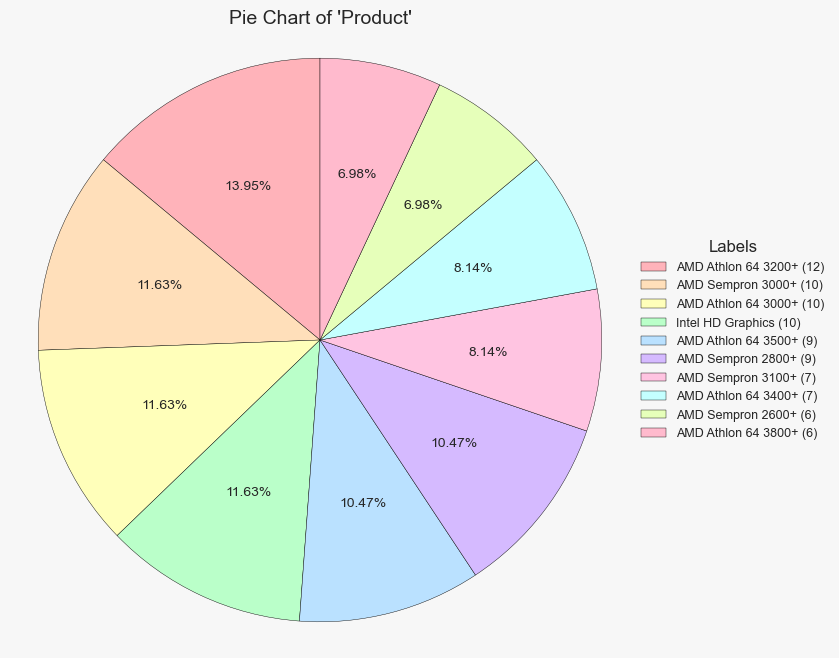


===== Bar Chart =====

📌 Feature Product có hơn 10 nhóm. Hiển thị top 10 phổ biến nhất.


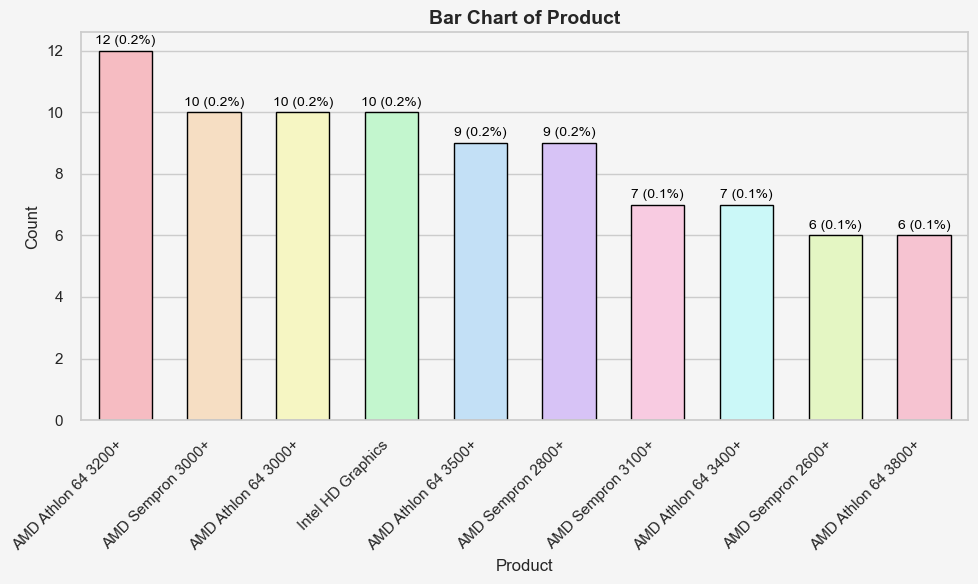

In [28]:
analyze_categorical_feature(full_data, 'Product')

**Interpretation**

**1. Overview**
- **Total records**: 3,883  
- **Unique values**: 3,492 (~ 90% of all records)  
- **Top 5 frequencies**:  
  - AMD Sempron 2800+ (9 occurrences, 0.23%)  
  - AMD Athlon 64 3200+ (8 occurrences, 0.21%)  
  - Intel HD Graphics (7 occurrences, 0.18%)  
  - …

**2. Challenges**
1. **High Cardinality**  
   - Most product names appear only once or twice → one‑hot encoding yields >3,000 sparse columns.  
2. **Sparse Feature Matrix**  
   - Inefficient memory footprint and slower computation.  
3. **Curse of Dimensionality**  
   - Risk of overfitting and poor generalization.

**3. Information Potential**
- **Implicit metadata**:  
  - Vendor (Intel, AMD, NVIDIA…)  
  - Series/Product line (Ryzen 5, GeForce RTX, Xeon…)  
  - Specific Model (e.g. “9700K”, “3080 Ti”)  
- **Segmentation**:  
  - High‑end vs Mid‑range vs Entry-level  
  - Desktop vs Mobile vs Server

**4. Recommended Processing Steps**

| Step                  | Description                                                                                                                              | Sample Code (pandas)                                        |
|-----------------------|------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------|
| 1. Basic Parsing      | Extract `Vendor`, `Series`, `Model` from `Product`                                                                                       | `df['Vendor'] = df['Product'].str.split().str[0]`           |
|                       | – Vendor: first token of the string                                                                                                      | `df['Series'] = df['Product'].str.extract(r'([A-Za-z]+\s[0-9x]+)')` |
|                       | – Series: usually letter+number combination                                                                                              | `df['Model'] = df['Product'].str.split().str[-1]`           |
| 2. Value Grouping     | Keep top N products (e.g., N=50), map all others to “Other”                                                                               | `top50 = df['Product'].value_counts().nlargest(50).index` <br>`df['Product2'] = df['Product'].where(df['Product'].isin(top50), 'Other')` |
| 3. Encoding           | – **Frequency Encoding**: map product name to its normalized frequency <br>– **Target Encoding**: map to mean target value                | `freq = df['Product2'].value_counts(normalize=True)` <br>`df['Prod_FE'] = df['Product2'].map(freq)` |
| 4. Drop or Retain     | – For broad trend modeling: **drop** `Product` after parsing labels <br>– For detailed EDA: **retain** original names for external joins    | `df.drop(columns=['Product'], inplace=True)`               |

**5. Recommendations**
- **For EDA**:  
  - Keep original names, plot top‑20 bar chart by year.  
- **For Modeling**:  
  - Use parsed `Vendor`, `Series`, `Model` features only.  
  - Apply frequency or target encoding.  
  - Introduce `is_unknown_product` flag for “Other” values.


### 3.2) Type

===== Summary of feature: Type =====

🔍 Feature: Type
------------------------------------------------------------
📌 Data Type: object
❗ Missing Values: 0 (0.00%)
------------------------------------------------------------
📊 Description:
count     4854
unique       2
top        GPU
freq      2662
Name: Type, dtype: object
------------------------------------------------------------
🔢 Value Counts (All):
      Count  Frequency (%)
Type                      
GPU    2662      54.841368
CPU    2192      45.158632


===== Pie Chart =====



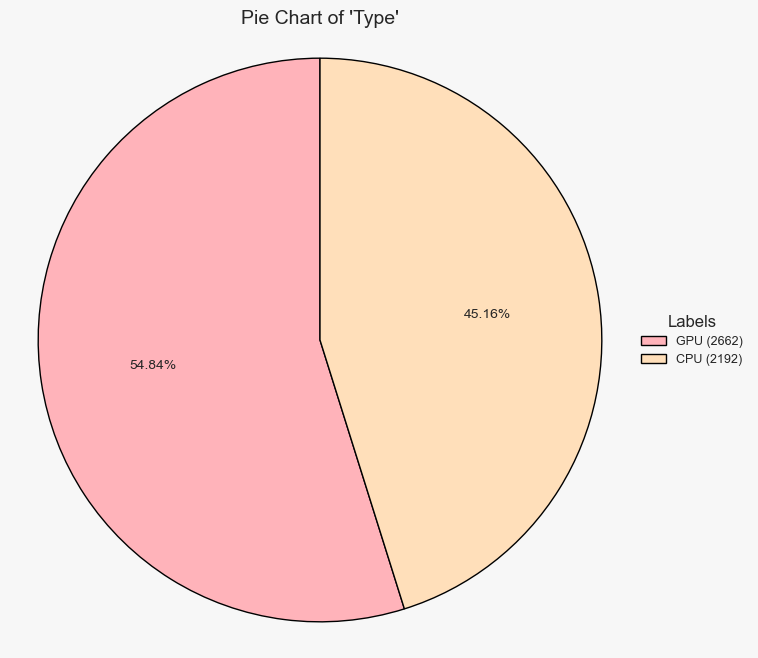


===== Bar Chart =====



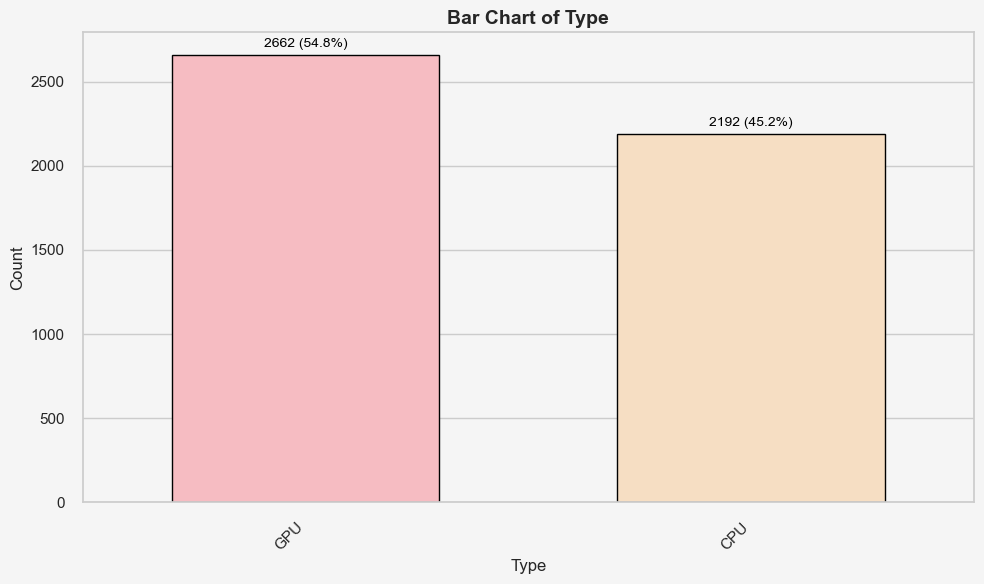

In [31]:
analyze_categorical_feature(full_data, 'Type')

**Interpretation**

**1. Overview**
- **Total records**: 4,854  
- **Unique values**: 2 (`CPU`, `GPU`)  
- **Frequency**:  
  - **GPU**: 2,662 (54.84%)  
  - **CPU**: 2,192 (45.16%)

**2. Nature and Role**
- This is a **binary categorical** feature.  
- **No missing values**, every record is classified as either CPU or GPU.  
- Serves as a natural **grouping** or **splitting** variable in analysis and modeling.

**3. Use Cases in Analysis & Modeling**
- **EDA**:  
  - Plot a pie or bar chart to compare CPU vs GPU counts and proportions over release years.  
  - Analyze market-share trends: e.g., GPU overtaking CPU from year X onward.  
- **Feature Engineering**:  
  - **One‑hot encoding**: create `is_GPU` and `is_CPU` dummy columns.  
  - **Label encoding**: map GPU→1, CPU→0 for algorithms that require numerical input.  
- **Data Partitioning**:  
  - Split dataset by Type to analyze CPU and GPU behavior separately (e.g., how Process Size impacts GPUs vs CPUs).  
  - In a combined model, add interaction terms (`Type × Freq`, `Type × GFLOPS`) to capture differing relationships.

**4. Recommendations**
1. **For ML modeling**  
   - Use label encoding (0/1) or one‑hot encoding.  
   - Include interaction features between `Type` and key numeric variables to model different effects for CPUs vs GPUs.  
2. **For Reporting & Visualization**  
   - Display CPU vs GPU proportions over time to highlight the GPU growth trend.  
   - Combine with the `Vendor` feature to compare AMD, NVIDIA, and Intel dynamics within each Type.

### 3.3) Release Date

===== Summary of feature: Release Date Day =====

🔍 Feature: Release Date Day
------------------------------------------------------------
📌 Data Type: category
❗ Missing Values: 75 (1.55%)
------------------------------------------------------------
📊 Description:
count     4779
unique      31
top          1
freq      1060
Name: Release Date Day, dtype: int64
------------------------------------------------------------
🔢 Value Counts (All):
                  Count  Frequency (%)
Release Date Day                      
1                  1060      21.837660
7                   188       3.873094
5                   183       3.770087
2                   179       3.687680
23                  177       3.646477
14                  175       3.605274
3                   172       3.543469
27                  162       3.337454
6                   159       3.275649
4                   154       3.172641
21                  147       3.028430
15                  136       2.801813
30      

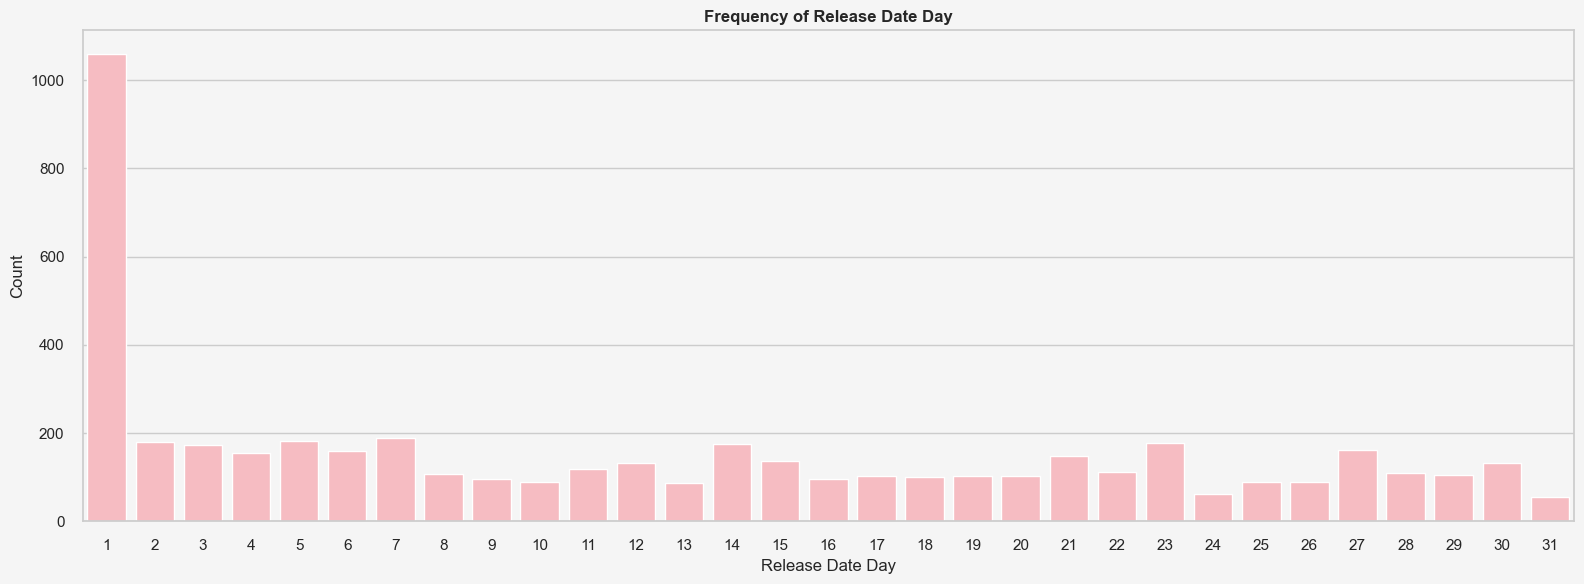

===== Summary of feature: Release Date Month =====

🔍 Feature: Release Date Month
------------------------------------------------------------
📌 Data Type: category
❗ Missing Values: 75 (1.55%)
------------------------------------------------------------
📊 Description:
count     4779
unique      12
top          1
freq       585
Name: Release Date Month, dtype: int64
------------------------------------------------------------
🔢 Value Counts (All):
                    Count  Frequency (%)
Release Date Month                      
1                     585      12.051916
6                     516      10.630408
9                     494      10.177173
4                     477       9.826947
3                     460       9.476720
5                     442       9.105892
10                    372       7.663782
8                     330       6.798517
7                     308       6.345282
2                     302       6.221673
11                    255       5.253399
12             

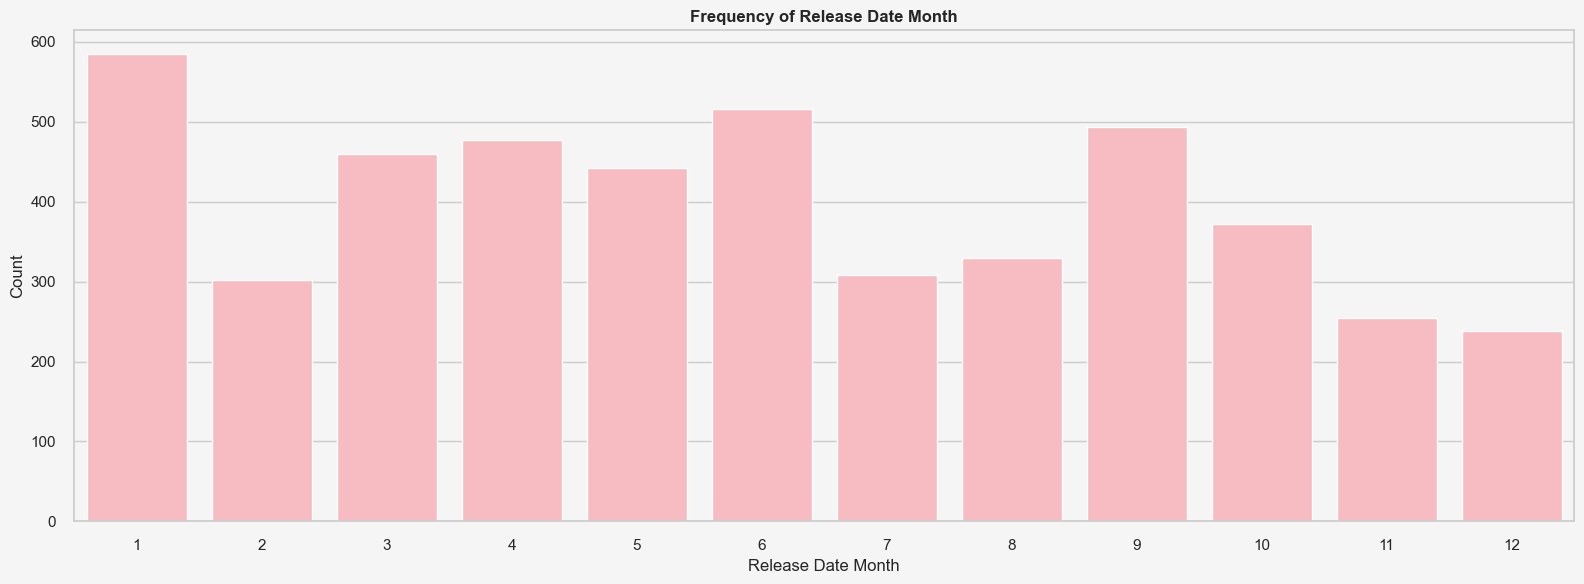

===== Summary of feature: Release Date Quarter =====

🔍 Feature: Release Date Quarter
------------------------------------------------------------
📌 Data Type: category
❗ Missing Values: 75 (1.55%)
------------------------------------------------------------
📊 Description:
count     4779
unique       4
top          2
freq      1435
Name: Release Date Quarter, dtype: int64
------------------------------------------------------------
🔢 Value Counts (All):
                      Count  Frequency (%)
Release Date Quarter                      
2                      1435      29.563247
1                      1347      27.750309
3                      1132      23.320972
4                       865      17.820354
NaN                      75       1.545117



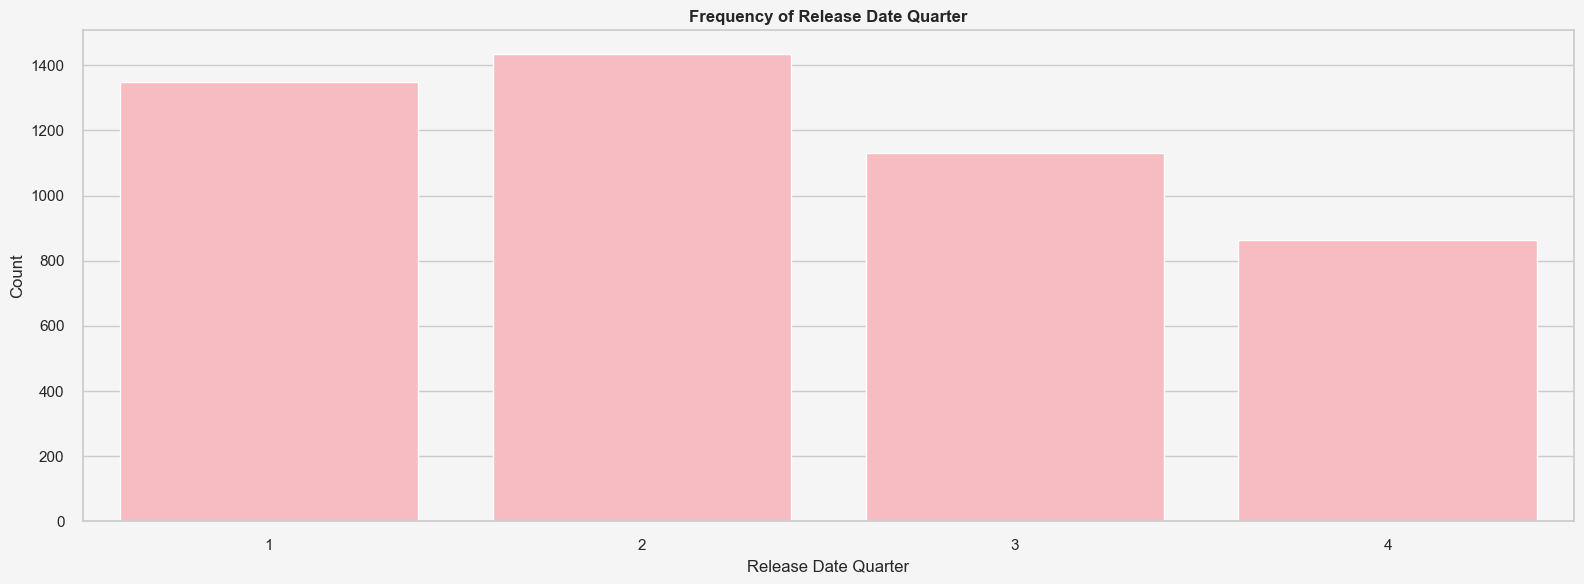

===== Summary of feature: Release Date Year =====

🔍 Feature: Release Date Year
------------------------------------------------------------
📌 Data Type: category
❗ Missing Values: 75 (1.55%)
------------------------------------------------------------
📊 Description:
count     4779
unique      22
top       2013
freq       349
Name: Release Date Year, dtype: int64
------------------------------------------------------------
🔢 Value Counts (All):
                   Count  Frequency (%)
Release Date Year                      
2013                 349       7.189946
2012                 331       6.819118
2011                 330       6.798517
2010                 291       5.995056
2008                 285       5.871446
2004                 266       5.480016
2006                 264       5.438813
2005                 249       5.129790
2007                 227       4.676555
2009                 221       4.552946
2017                 218       4.491141
2015                 213       

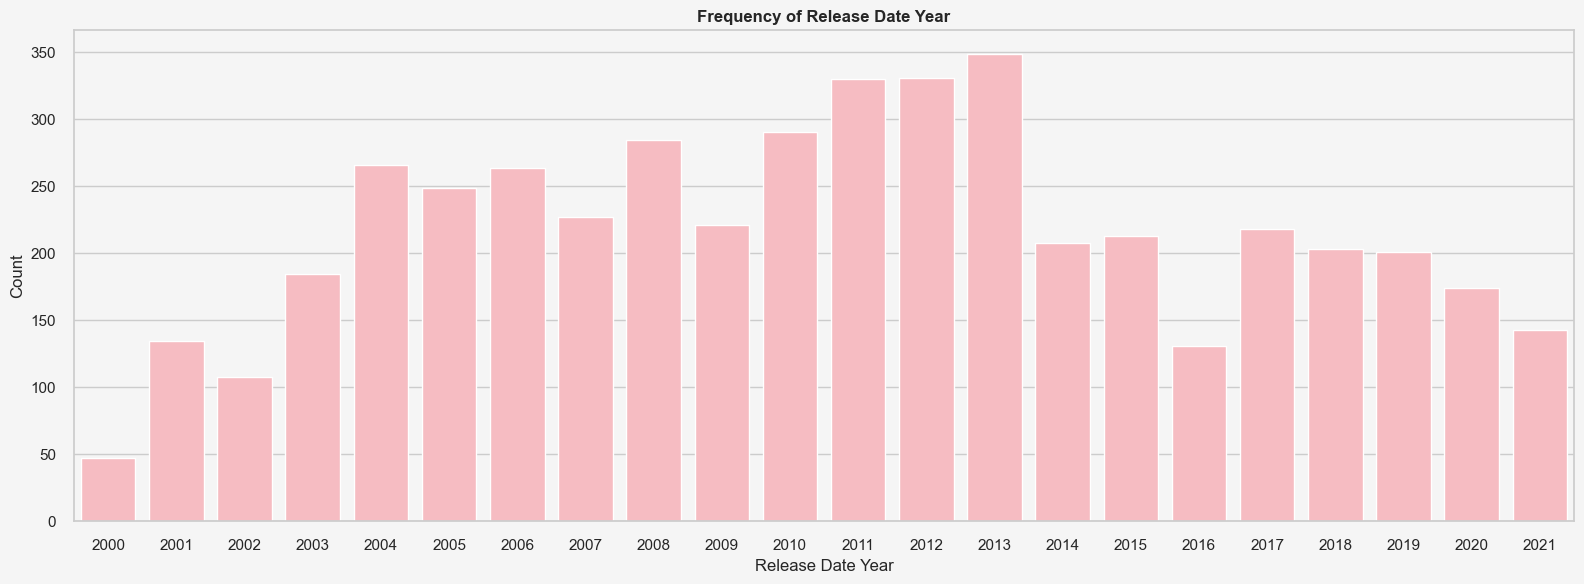

In [34]:
process_datetime_feature(full_data, 'Release Date')

**Interpretation**

**1. Overview**
- The `Release Date` was split into `Day`, `Month`, `Quarter`, and `Year`.
- All columns are in `category` format, saving memory and being ML-friendly.
- Each column has **57 missing values (1.47%)**, which must be addressed before modeling.

**2. Column-by-Column Breakdown**

**a. `Release Date Day`**
- 31 unique values representing days in a month.
- Skewed distribution: day **1** dominates (~21.9%) → possibly a default or placeholder.
- ⚠️ May introduce bias if not handled, especially if it's not the true release day.

**b. `Release Date Month`**
- All 12 months are present.
- January and June have higher product releases; December is the lowest.
- Could be used to explore **seasonal release trends**.

**c. `Release Date Quarter`**
- All 4 quarters represented; Q1 & Q2 make up nearly 60% of releases.
- Q4 has the fewest → possibly fewer launches in year-end, or data incompleteness.

**d. `Release Date Year`**
- Covers years **2000 to 2021**, with a peak from 2010 to 2013 (over 25%).
- Suitable for **temporal trend analysis** on release volume or specs.
- Can be visualized to identify waves of product launches.

**3. Recommendations**

- **Missing values**:
  - Since only 1.47% missing, fill with mode or create an `"Unknown"` category.
  - Avoid dropping unless absolutely necessary.

- **Feature engineering**:
  - Combine fields to create indicators like `is_q1_or_q2`, `released_after_2010`.
  - For tree-based models → keep categorical as is.
  - For linear models → one-hot encode to capture the effect of each time group.


### 3.4) Process Size

===== Summary of feature: Process Size =====

🔍 Feature: Process Size
------------------------------------------------------------
📌 Data Type: float64
❗ Missing Values: 9 (0.19%)
------------------------------------------------------------
📊 Description:
count    4845.000000
mean       55.109598
std        44.998676
min         0.000000
25%        22.000000
50%        40.000000
75%        90.000000
max       250.000000
Name: Process Size, dtype: float64
------------------------------------------------------------
🔢 Value Counts (All):
              Count  Frequency (%)
Process Size                      
14.0            620      12.772971
28.0            617      12.711166
90.0            479       9.868150
40.0            425       8.755665
130.0           383       7.890400
32.0            355       7.313556
65.0            341       7.025134
45.0            265       5.459415
22.0            259       5.335806
150.0           176       3.625876
55.0            172       3.543469
7.0

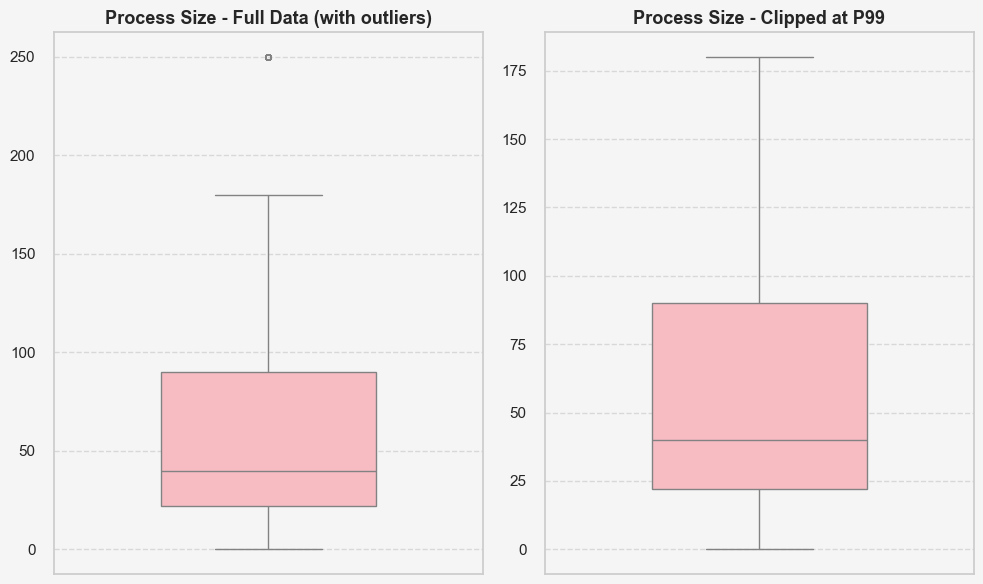


===== Histogram Comparison (Full vs Clipped) =====



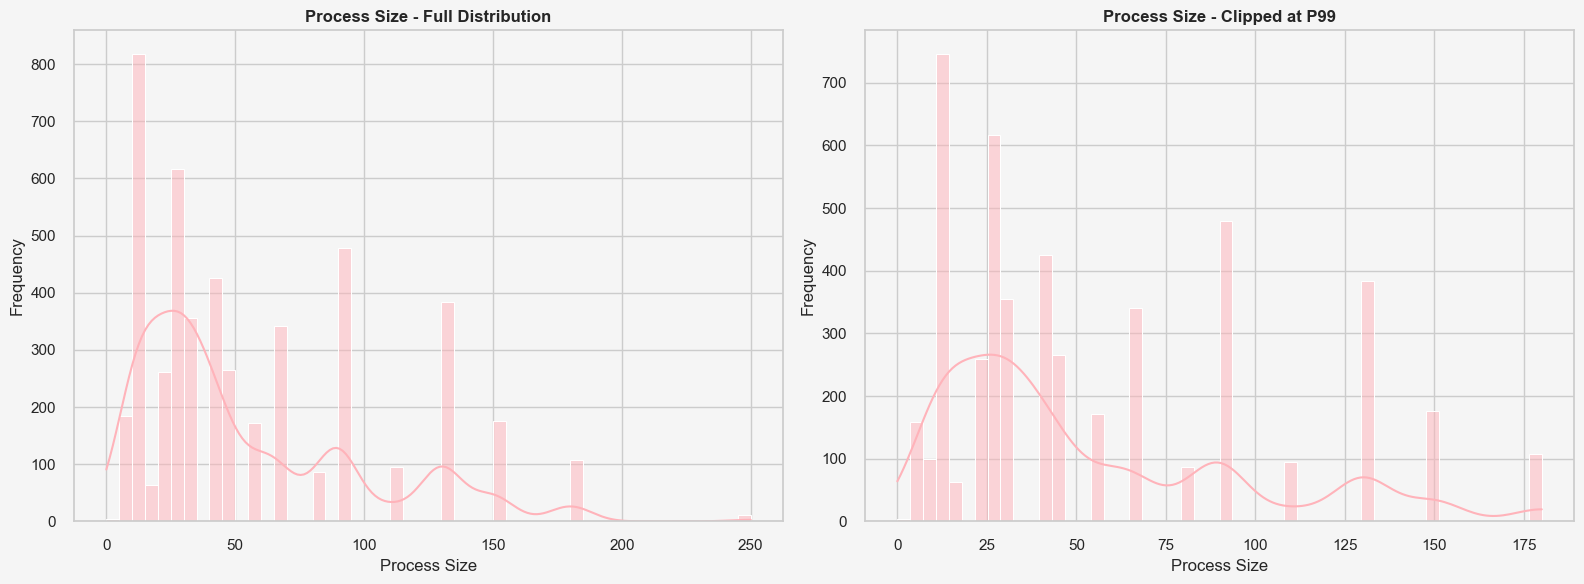

In [37]:
analyze_numerical_feature(full_data, 'Process Size')

**Interpretation**
**1 Overview:**
- **Data Type**: Float (`float64`)
- **Missing Values**: 8 (≈0.21%) → Can be imputed with median.
- **Minimum Value**: 0.0 → Potential data error.
- **Maximum Value**: 250.0
- **Mean**: ~55.25
- **25/50/75 Percentiles**: [22.0, 40.0, 90.0]
- **Most frequent values**: 14.0, 28.0, 90.0, 40.0, 130.0

**2 Insights:**
- The `Process Size` represents the **manufacturing process node size** (in nanometers – nm) used in chip fabrication.
- Smaller sizes (e.g., 7nm, 14nm, etc.) indicate newer technology with better performance and energy efficiency.
- The distribution is skewed with concentration at standard node sizes → Consider binning into categories.

**3 Considerations:**
- **Outlier**: 0.0 should be validated and potentially removed as it is likely invalid.
- **Missing Data**: Small percentage, can be safely imputed using the median.
- **Encoding**: May be kept as continuous or binned into tech generation categories:
  - `Modern` (≤22nm)
  - `Recent` (≤65nm)
  - `Old` (≤130nm)
  - `Legacy` (>130nm)

**4 Conclusion:**
`Process Size` is a meaningful feature related to **hardware performance and generation**. It should be carefully cleaned (e.g., outliers), and can be transformed or categorized to improve model interpretability and performance.



### 3.5) TDP

===== Summary of feature: TDP =====

🔍 Feature: TDP
------------------------------------------------------------
📌 Data Type: float64
❗ Missing Values: 626 (12.90%)
------------------------------------------------------------
📊 Description:
count    4228.000000
mean       81.359981
std        76.807808
min         1.000000
25%        33.000000
50%        65.000000
75%       100.000000
max       900.000000
Name: TDP, dtype: float64
------------------------------------------------------------
🔢 Value Counts (All):
       Count  Frequency (%)
TDP                        
NaN      626      12.896580
65.0     341       7.025134
35.0     315       6.489493
15.0     229       4.717759
95.0     181       3.728883
...      ...            ...
189.0      1       0.020602
102.0      1       0.020602
286.0      1       0.020602
345.0      1       0.020602
900.0      1       0.020602

[201 rows x 2 columns]


===== Box Plot =====



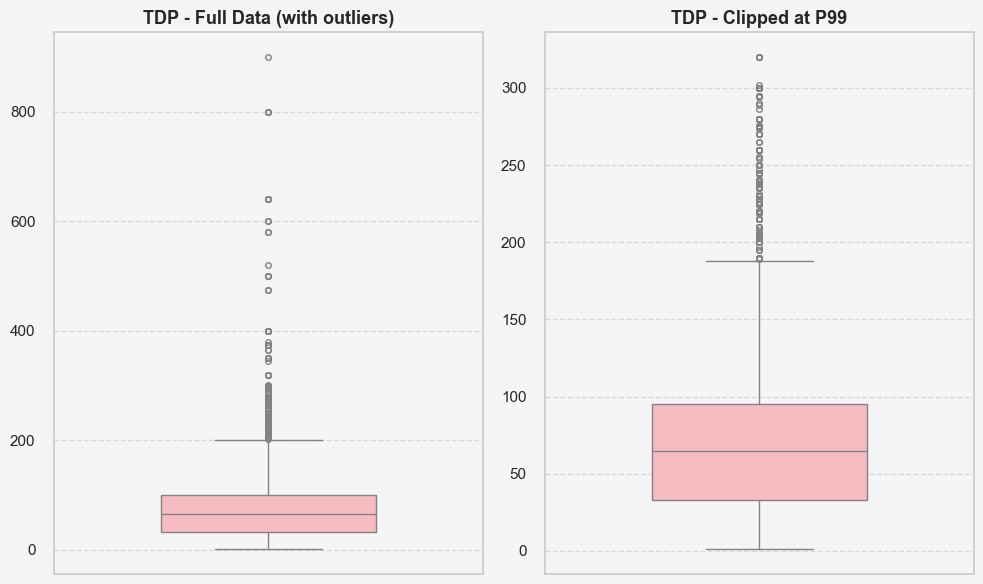


===== Histogram Comparison (Full vs Clipped) =====



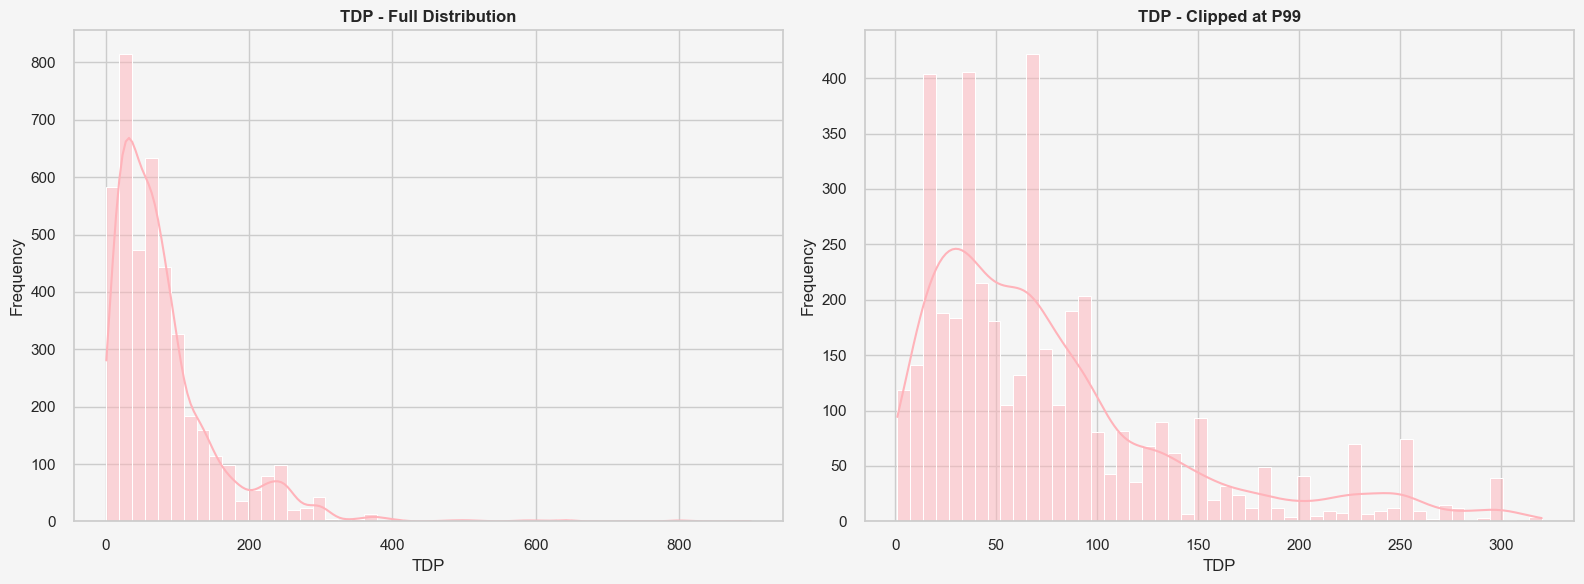

In [40]:
analyze_numerical_feature(full_data, 'TDP')

**Interpretation**

**1. Overview**
- **Data type**: float64
- **Missing values**: 511 out of 3883 (~13.16%)
- **Distribution**:
  - Min: 1 W, Max: 900 W
  - Median: 65 W
  - Mean: 80.89 W
  - IQR: 64 W (wide spread, potential outliers)

**2. Meaning**
- **TDP (Thermal Design Power)** represents the maximum amount of heat generated by a chip that the cooling system must dissipate under maximum load.
- Higher TDP → typically means higher performance, but also more power consumption and heat.

**3. Observations**
- **Most common values**:
  - 65W (7.26%)
  - 35W (6.49%)
  - 15W (4.61%) → indicates many low-power CPUs or integrated GPUs
- **Outliers**:
  - Some devices have TDP up to 900W → likely specialized GPUs or data entry errors → should be validated.

**4. Handling Missing Values**
- **~13% missing** → too much to drop rows casually.
- Suggestions:
  - Impute by average TDP within `Type` (CPU vs GPU).
  - Use regression imputation based on related features: `Die Size`, `Transistors`, `Freq`.
  - Or add a binary flag `TDP_missing` to indicate imputed records.

**5. Use Cases**
- Useful for classifying chips into low-power vs high-performance.
- Analyze correlation with performance metrics (`GFLOPS`) and chip characteristics.
- Likely a strong predictor in modeling performance or thermal behavior.


### 3.6) Die Size

===== Summary of feature: Die Size =====

🔍 Feature: Die Size
------------------------------------------------------------
📌 Data Type: float64
❗ Missing Values: 715 (14.73%)
------------------------------------------------------------
📊 Description:
count    4139.000000
mean      188.440445
std       126.189383
min         1.000000
25%       104.000000
50%       148.000000
75%       239.000000
max       826.000000
Name: Die Size, dtype: float64
------------------------------------------------------------
🔢 Value Counts (All):
          Count  Frequency (%)
Die Size                      
NaN         715      14.730119
118.0       130       2.678204
246.0       103       2.121961
123.0        94       1.936547
160.0        93       1.915946
...         ...            ...
322.0         1       0.020602
279.0         1       0.020602
348.0         1       0.020602
209.0         1       0.020602
222.0         1       0.020602

[192 rows x 2 columns]


===== Box Plot =====



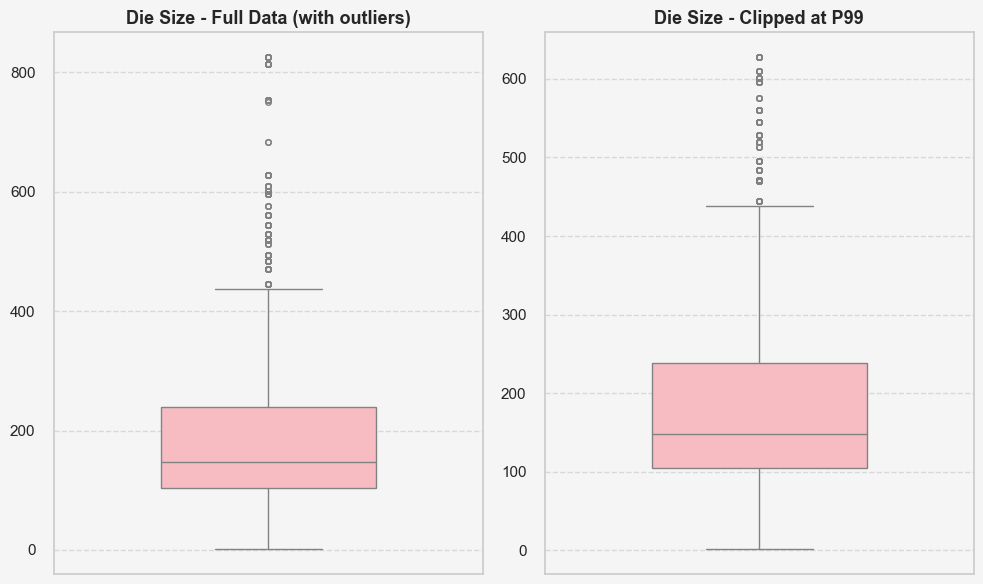


===== Histogram Comparison (Full vs Clipped) =====



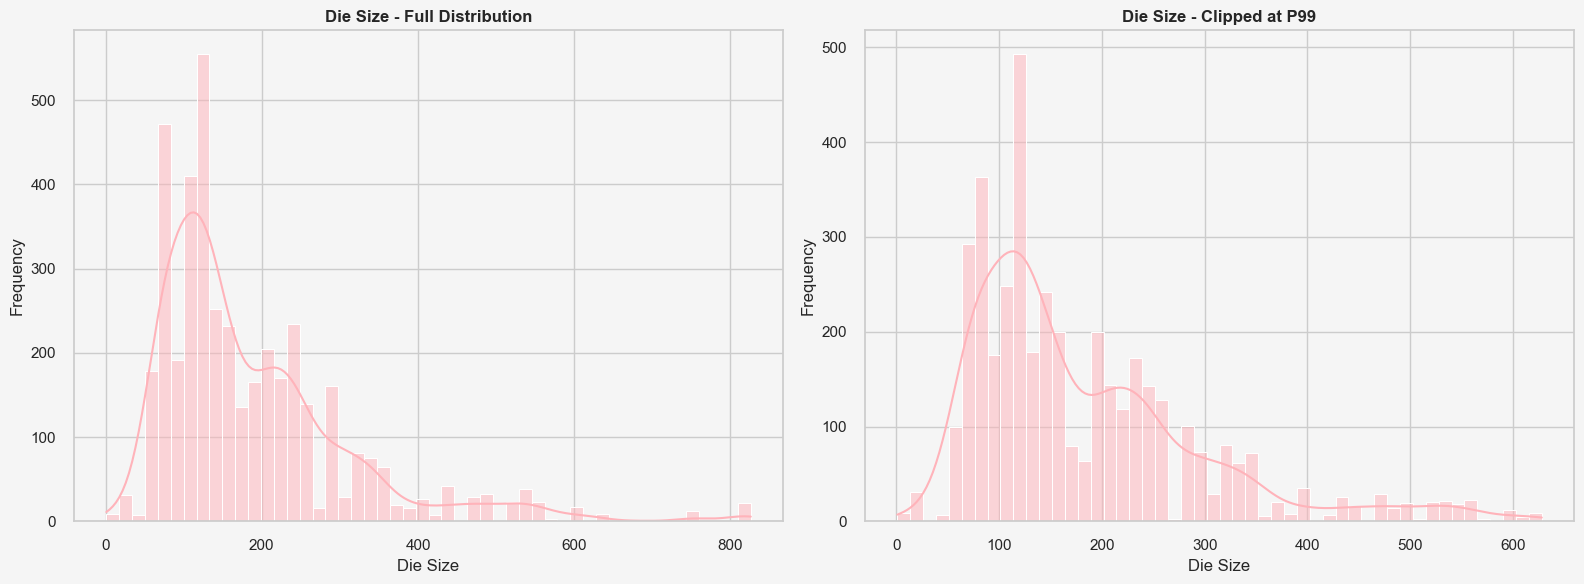

In [43]:
analyze_numerical_feature(full_data, 'Die Size')

**Interpretation**

**1. Overview**
- **Data type**: float64  
- **Missing values**: 569 records (≈14.65%)  
- **Valid entries**: 3,314  
- **Distribution**:
  - **Mean**: 187.55 mm²
  - **Standard deviation**: 124.93 mm²
  - **Min**: 1.0 mm²
  - **25% percentile**: 104.0 mm²
  - **Median (50%)**: 148.0 mm²
  - **75% percentile**: 239.0 mm²
  - **Max**: 826.0 mm²

**2. Meaning and Role**
- `Die Size` refers to the **physical surface area of the chip**, measured in square millimeters.
- It directly relates to the number of transistors, heat dissipation, and performance capacity.
- Often correlated with features like `Transistors`, `Process Size`, and `TDP`.

**3. Data Issues**
- **14.65% missing rate** is significant → needs preprocessing before modeling.
- Some extreme values (e.g., `1.0 mm²`) may be **outliers or data errors**.

**4. Missing Value Handling Strategy**
- **For descriptive analysis (EDA)**:
  - Keep missing values and visualize with histogram/boxplot.
- **For modeling**:
  - **Option 1**: Impute with **median (148.0)** to minimize outlier impact.
  - **Option 2**: Predict missing values using related features like `Transistors`, `Process Size`, `Type`.
  - **Option 3**: Create a binary flag `DieSize_missing` to capture the significance of missing data.

**5. Analysis Suggestions**
- Compare `Die Size` between CPUs and GPUs → GPUs typically have larger die sizes to support parallelism.
- Visualize distribution and check skewness or variance.
- Analyze correlation between `Die Size` and performance metrics (e.g., FP16/FP32 GFLOPS).


### 3.7) Transistors

===== Summary of feature: Transistors =====

🔍 Feature: Transistors
------------------------------------------------------------
📌 Data Type: float64
❗ Missing Values: 711 (14.65%)
------------------------------------------------------------
📊 Description:
count     4143.000000
mean      1929.922279
std       4044.891098
min          8.000000
25%        154.000000
50%        624.000000
75%       1550.000000
max      54200.000000
Name: Transistors, dtype: float64
------------------------------------------------------------
🔢 Value Counts (All):
             Count  Frequency (%)
Transistors                      
NaN            711      14.647713
1400.0         173       3.564071
1178.0         118       2.430985
106.0          102       2.101360
63.0            63       1.297899
...            ...            ...
880.0            1       0.020602
420.0            1       0.020602
49.0             1       0.020602
463.0            1       0.020602
198.0            1       0.020602

[197 ro

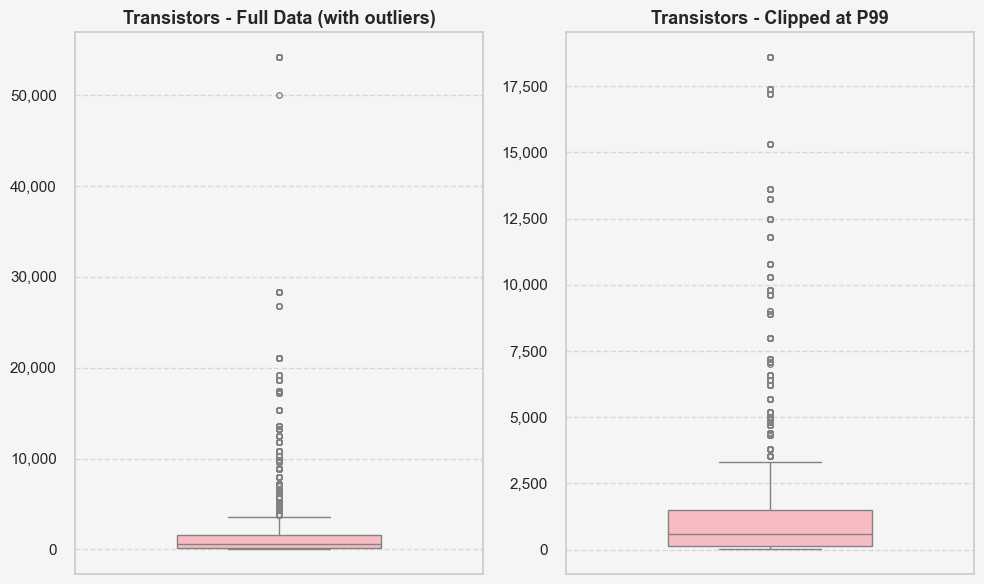


===== Histogram Comparison (Full vs Clipped) =====



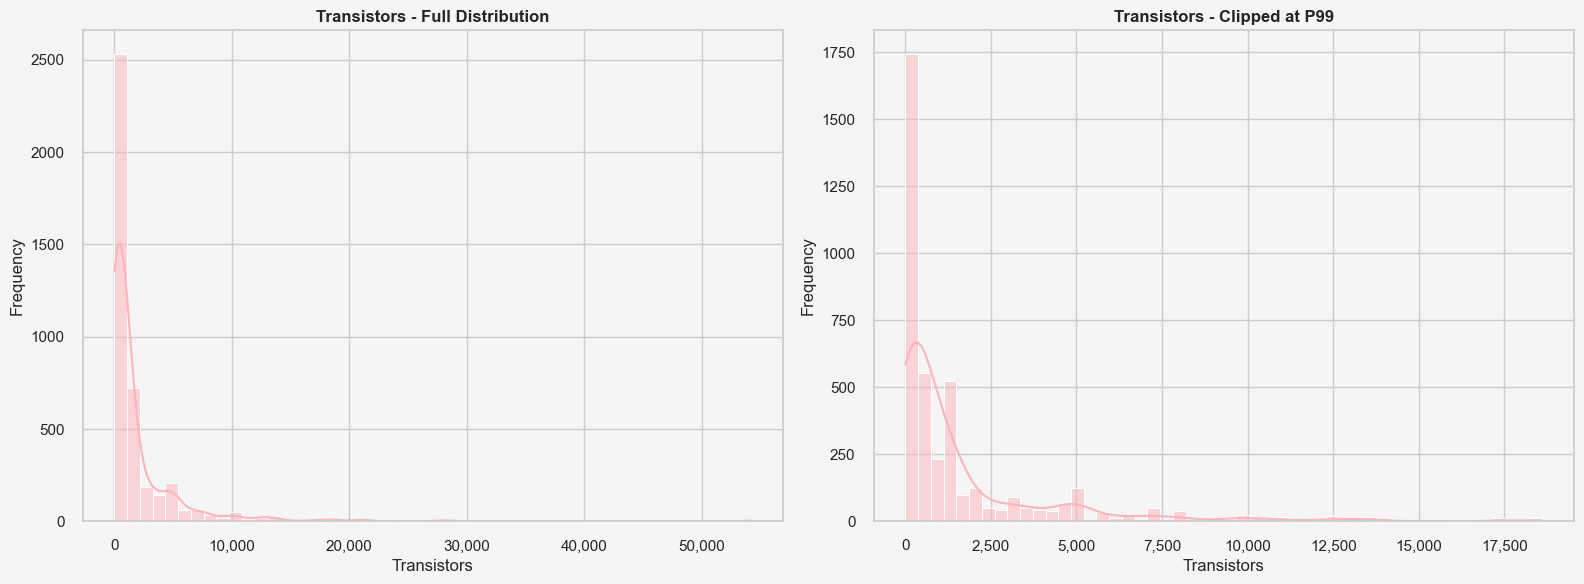

In [46]:
analyze_numerical_feature(full_data, 'Transistors')

**Interpretation**

**1. Overview**
- **Data type**: `float64`  
- **Missing values**: 562 records (≈14.47%)  
- **Valid entries**: 3,321  
- **Transistor count distribution (in millions)**:
  - **Mean**: ~1,902 million
  - **Standard deviation**: ~3,950 million
  - **Min**: 10 million
  - **25th percentile**: 154 million
  - **Median (50%)**: 585 million
  - **75th percentile**: 1,500 million
  - **Max**: 54,200 million (≈54 billion transistors)

**2. Meaning and Importance**
- The `Transistors` feature represents the **number of transistors in the chip**, measured in millions.
- It is a fundamental indicator of **computational complexity and chip performance**.
- Growth in transistor count often follows **Moore's Law**, useful for identifying technological trends.

**3. Data Issues**
- **Missing rate ~14.47%** is non-negligible and requires imputation.
- The distribution is **heavily right-skewed**, suggesting presence of very large values.
- Some frequent values (e.g., 1400, 1178) might indicate standard designs across multiple product lines.

**4. Missing Value Handling Strategy**
- **Option 1**: Impute with **median (585)** to reduce impact from extreme values.
- **Option 2**: Predict missing values using correlated features such as `Die Size`, `Process Size`, and `Type`.
- **Option 3**: Create a new binary flag `Transistors_missing` to indicate missingness for potential pattern learning.

**5. Analysis Suggestions**
- Analyze correlation with performance metrics like FP16/FP32 GFLOPS.
- Compare transistor counts across CPU and GPU → high-end GPUs tend to have significantly more transistors.
- Use log-scale histograms to reveal patterns and clusters.


### 3.8) Freq

===== Summary of feature: Freq =====

🔍 Feature: Freq
------------------------------------------------------------
📌 Data Type: float64
❗ Missing Values: 0 (0.00%)
------------------------------------------------------------
📊 Description:
count    4854.000000
mean     1484.406057
std      1066.701523
min       100.000000
25%       590.000000
50%      1073.500000
75%      2400.000000
max      4700.000000
Name: Freq, dtype: float64
------------------------------------------------------------
🔢 Value Counts (All):
        Count  Frequency (%)
Freq                        
2400.0    138       2.843016
2000.0    138       2.843016
500.0     131       2.698805
300.0     128       2.637000
2200.0    124       2.554594
...       ...            ...
2830.0      1       0.020602
844.0       1       0.020602
2790.0      1       0.020602
1038.0      1       0.020602
416.0       1       0.020602

[527 rows x 2 columns]


===== Box Plot =====



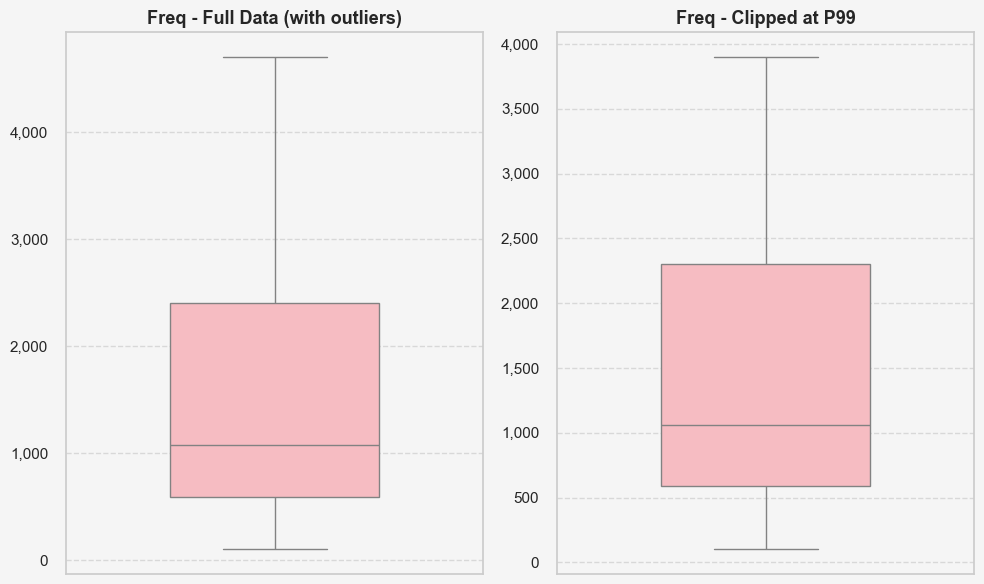


===== Histogram Comparison (Full vs Clipped) =====



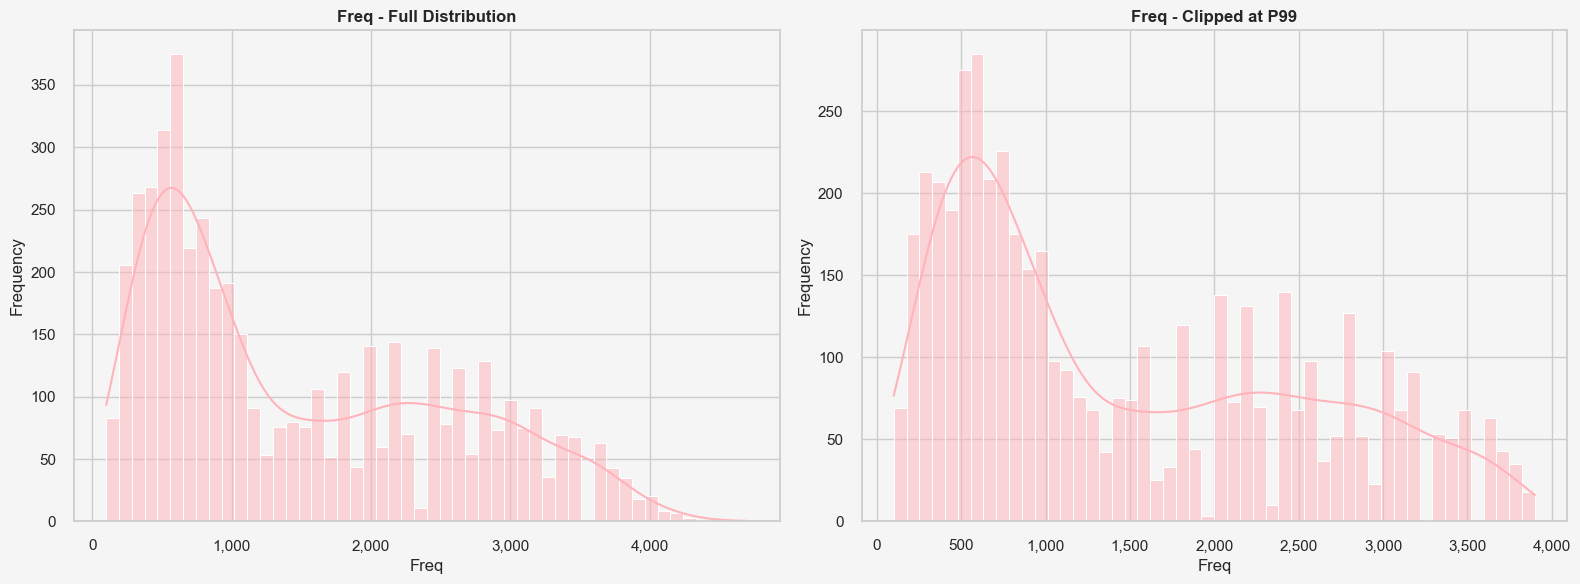

In [49]:
analyze_numerical_feature(full_data, 'Freq')

**Interpretation**

**1. Overview**
- **Data Type**: float64  
- **Missing Values**: 0 (0.00%) ✅  
- **Data Distribution**:
  - **Count**: 3,883
  - **Mean**: 1,487 MHz
  - **Standard Deviation**: 1,070 MHz
  - **Minimum**: 100 MHz
  - **25% Percentile**: 589 MHz
  - **Median (50%)**: 1,082 MHz
  - **75% Percentile**: 2,400 MHz
  - **Maximum**: 4,700 MHz

**2. Meaning and Role**
- `Freq` represents the **operating frequency of the chip** (CPU or GPU), measured in MHz.
- Higher frequency usually translates into higher performance (under similar conditions).
- It's a critical factor impacting computing power (especially GFLOPS) and power consumption (`TDP`).

**3. Observations**
- No missing values → good for modeling and analysis.
- Wide value range from **100 MHz to 4700 MHz**.
- **Right-skewed distribution**: median (1082) is lower than the mean (1487).
- Some extremely high frequencies (> 4000 MHz) may represent overclocked or high-performance chips → consider verifying if needed.

**4. Analysis Suggestions**
- Compare CPU vs. GPU frequencies (GPUs typically have lower frequencies but more parallel cores).
- Visualize distribution using histogram or KDE plots.
- Analyze correlation between frequency and performance (FP16/FP32/FP64 GFLOPS).
- Normalize or cluster frequency data if using for machine learning due to its wide dispersion.


### 3.9) Foundry

===== Summary of feature: Foundry =====

🔍 Feature: Foundry
------------------------------------------------------------
📌 Data Type: object
❗ Missing Values: 0 (0.00%)
------------------------------------------------------------
📊 Description:
count     4854
unique      10
top       TSMC
freq      2178
Name: Foundry, dtype: object
------------------------------------------------------------
🔢 Value Counts (All):
         Count  Frequency (%)
Foundry                      
TSMC      2178      44.870210
Intel     1390      28.636176
Unknown    866      17.840956
GF         265       5.459415
UMC         79       1.627524
Samsung     60       1.236094
Sony        10       0.206016
IBM          3       0.061805
NEC          2       0.041203
Renesas      1       0.020602


===== Pie Chart =====



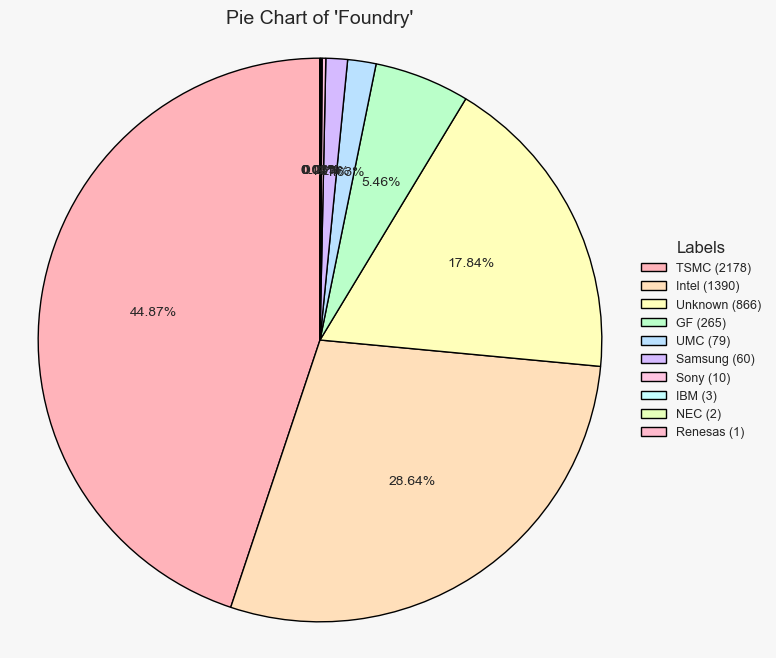


===== Bar Chart =====



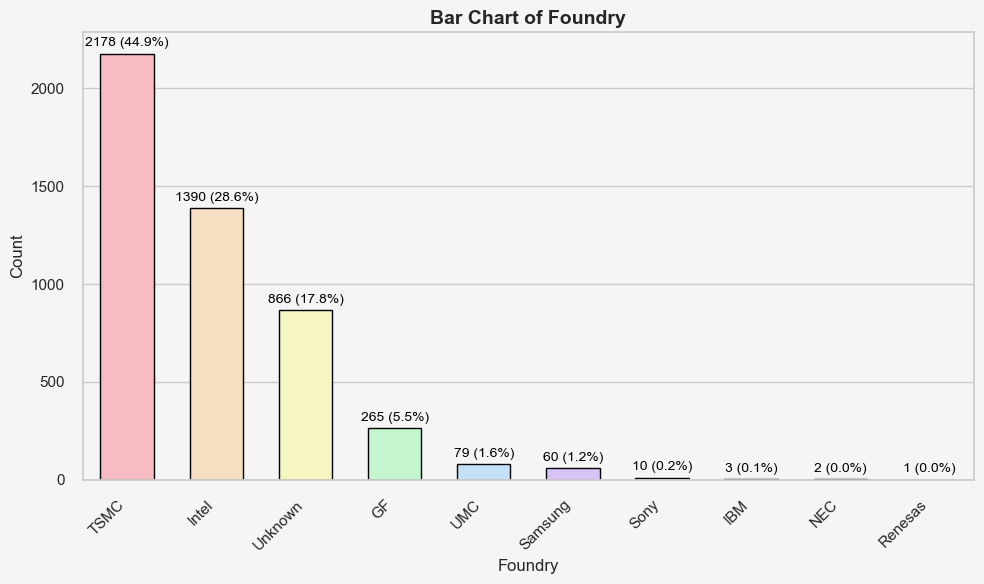

In [52]:
analyze_categorical_feature(full_data, 'Foundry')

**Interpretation**

**1. Overview**
- **Data type**: object  
- **Unique values**: 9 foundries  
- **Total records**: 3,883  
- **Frequencies**:
  - **TSMC**: 1,739 (44.78%)  
  - **Intel**: 1,115 (28.71%)  
  - **Unknown**: 698 (17.98%)  
  - **GF**: 213 (5.49%)  
  - Other foundries (UMC, Samsung, Sony, IBM, Renesas) together ~3%.

**2. Meaning and Role**
- `Foundry` denotes the **fabrication plant** where the chip is manufactured, reflecting the process technology and capabilities.  
- Different foundries use different process nodes (e.g., TSMC 5 nm vs Intel 10 nm), impacting **Process Size**, **Yield**, and **Performance**.

**3. Issues & Considerations**
- **“Unknown” category** at ~18%: investigate whether this is due to missing metadata, legacy products, or undisclosed information.  
- Small-sample foundries (Renesas, IBM) have very few records → may lack statistical power if analyzed separately.

**4. Handling & Feature Engineering**
1. **Standardize values**  
   - Normalize case, trim whitespace, correct typos (e.g., “GF” → “GlobalFoundries”).  
2. **Deal with “Unknown”**  
   - Retain as a separate category for missing-info analysis.  
   - Or map to a generic label like “Other” or “Missing.”  
3. **Encoding**  
   - **One‑hot encoding** for algorithms that require numeric input.  
   - **Frequency encoding** to map each foundry to its occurrence frequency.  
4. **Augment with external data**  
   - Join with an external table (foundry process node, introduction date) to enrich each record with `NodeSize` or `YearIntroduced`.

**5. Analysis Suggestions**
- Compare **average Process Size** and **Yield** by foundry to assess technological efficiency.  
- Analyze the market share trend of TSMC vs Intel over release years.  
- Evaluate performance metrics (GFLOPS, TDP) across foundries to identify leading fabs in power efficiency.


### 3.10) Vendor

===== Summary of feature: Vendor =====

🔍 Feature: Vendor
------------------------------------------------------------
📌 Data Type: object
❗ Missing Values: 0 (0.00%)
------------------------------------------------------------
📊 Description:
count     4854
unique       5
top        AMD
freq      1662
Name: Vendor, dtype: object
------------------------------------------------------------
🔢 Value Counts (All):
        Count  Frequency (%)
Vendor                      
AMD      1662      34.239802
Intel    1392      28.677379
NVIDIA   1201      24.742480
ATI       535      11.021838
Other      64       1.318500


===== Pie Chart =====



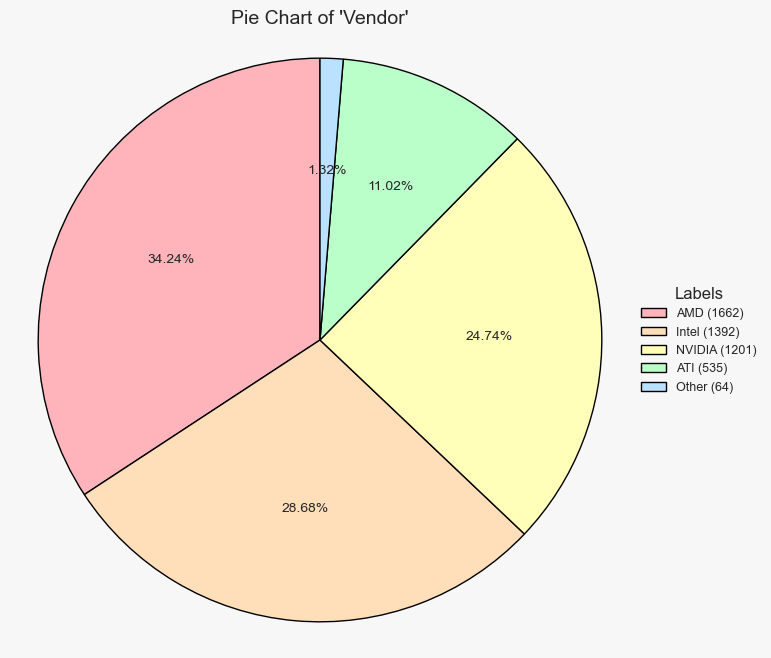


===== Bar Chart =====



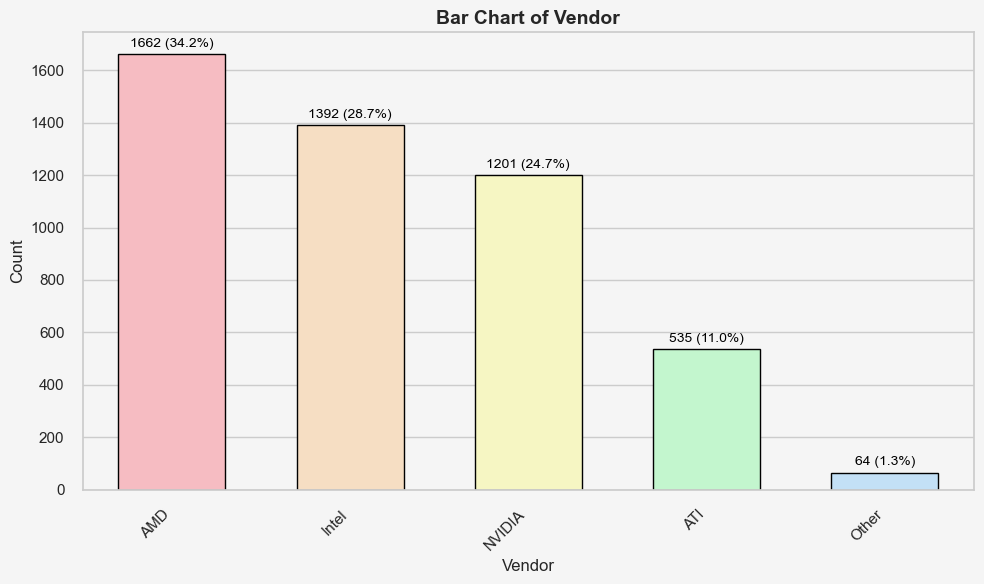

In [55]:
analyze_categorical_feature(full_data, 'Vendor')

**Interpretation**

**1. Overview**
- **Data type**: object  
- **Total records**: 3,883  
- **Unique values**: 5 (`AMD`, `Intel`, `NVIDIA`, `ATI`, `Other`)  
- **Frequency**:  
  - AMD: 1,333 (34.33%)  
  - Intel: 1,117 (28.77%)  
  - NVIDIA: 959 (24.70%)  
  - ATI: 419 (10.79%)  
  - Other: 55 (1.42%)

**2. Role & Use Cases**
- A **categorical feature** with **low cardinality** (5 labels).  
- Indicates chip vendor, critical for comparing development strategies and technology trends.

**3. Strengths & Challenges**
- **Strengths**:  
  - Few categories → easy encoding, low overfitting risk.  
  - Can apply one‑hot or label encoding directly.  
- **Challenge**:  
  - The “Other” category is small but heterogeneous; if deeper analysis is needed, consider splitting it out.

**4. Processing & Feature Engineering Steps**

| Step                    | Description                                                                                                                     | Sample Code (pandas)                              |
|-------------------------|---------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------|
| 1. Label normalization  | Check and merge similar labels (e.g., map `ATI` → `AMD` if combining them)                                                     | `df['Vendor'] = df['Vendor'].replace({'ATI':'AMD'})` |
| 2. One‑hot encoding     | Create binary columns for each vendor                                                                                           | `pd.get_dummies(df['Vendor'], prefix='V')`         |
| 3. Label encoding       | Map vendors to integers 0–4 for algorithms without native categorical support                                                  | `df['Vend_LE'] = df['Vendor'].map({'AMD':0,'Intel':1,'NVIDIA':2,'ATI':3,'Other':4})` |
| 4. Interaction feature  | Build interactions with numeric features (e.g., `Vendor × Process Size`, `Vendor × GFLOPS`) to capture vendor-specific effects | `df['VxSize'] = df['Vend_LE'] * df['Process Size (nm)']` |

**5. Recommendations**
- **For EDA**:  
  - Plot vendor distribution over release years to visualize CPU vs GPU release strategies.  
  - Compare distributions of `Die Size`, `TDP`, `Freq` across vendors.  
- **For Modeling**:  
  - Use one‑hot for interpretability, label encoding for dimensionality reduction.  
  - Consider interaction terms or target encoding (e.g., encoding by average performance per vendor) to boost model performance.


### 3.11) FP16 GFLOPS

===== Summary of feature: FP16 GFLOPS =====

🔍 Feature: FP16 GFLOPS
------------------------------------------------------------
📌 Data Type: float64
❗ Missing Values: 4318 (88.96%)
------------------------------------------------------------
📊 Description:
count       536.000000
mean       8397.459851
std       13799.551131
min          10.020000
25%         768.800000
50%        2965.500000
75%       10600.000000
max      184600.000000
Name: FP16 GFLOPS, dtype: float64
------------------------------------------------------------
🔢 Value Counts (All):
             Count  Frequency (%)
FP16 GFLOPS                      
NaN           4318      88.957561
768.00          10       0.206016
1248.00          8       0.164813
921.60           7       0.144211
786.40           7       0.144211
...            ...            ...
33.41            1       0.020602
89.12            1       0.020602
27480.00         1       0.020602
251.50           1       0.020602
1505.00          1       0.020602

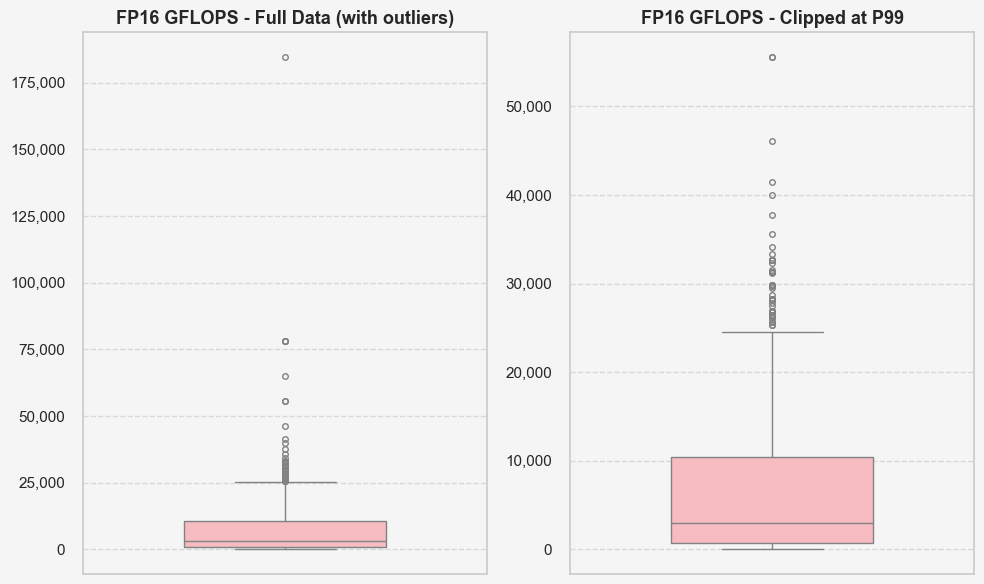


===== Histogram Comparison (Full vs Clipped) =====



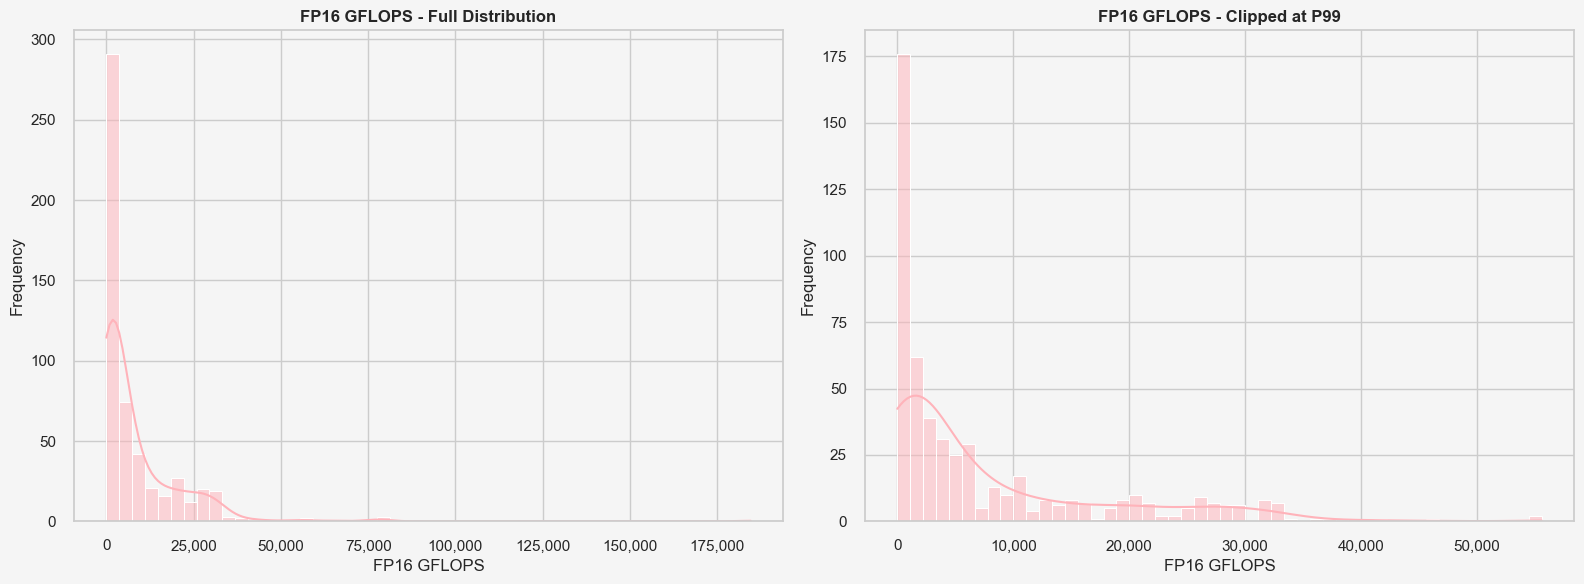

In [58]:
analyze_numerical_feature(full_data, 'FP16 GFLOPS')

**Interpretation**

**1. Overview**
- **Data type**: float64  
- **Missing values**: 3,454 records (≈ 88.95%)  
- **Valid entries**: 429  
- **Distribution**  
  - **Min**: 10.02 GFLOPS  
  - **25th percentile**: 768.00 GFLOPS  
  - **Median (50%)**: 2,867 GFLOPS  
  - **75th percentile**: 10,390 GFLOPS  
  - **Max**: 184,600 GFLOPS  
  - **Standar**iation**: 14,165.37** GFLOPS  

#### 2. Meaning and Role
- `FP16 GFLOPS` measures half‑precision floating‑point performance (16‑bit) in billions of operations per second.  
- Critical for AI/ML workloads and advanced graphics where FP16 delivers high **ghput and ener**gy efficiency.

#### 3. Data Issues
- **Very high missing rate** (~89%)  
  - Most CPUs and older GPUs do not report FP16 performance.  
- **Skewed distribution** with extreme outliers (tens to **eds of thousands of GFLOPS).

####** 4. Missing Value Handling Strategy
- **Keep NaN** for CPUs if FP16 performance is irrelevant.  
- **Imputation**:  
  - Fill with `0` GFLOPS for devices lacking FP16 support.  
  - Or fill with median (**2,867 GFLOPS**) for GPUs missing reported values, plus a binary flag `FP16_reported`.  
- **Indicator flag**:  
  - `FP16_reported = 1` if non‑null, else 0.  
- **Model-based imputation**:  
  - Use regression (e.g., RandomForest) leveraging `FP32 GFLOPS`, `Type`, `Vendor`, and `Relea**ar` to predict missing **FP16.

#### 5. Analysis Suggestions
- **Segmentation**:  
  - Separate GPUs with and without FP16 support; compare performance across architectures (e.g., Turing vs Ampere).  
- **Visualization**:  
  - Boxplots of FP16 GFLOPS by Vendor/Series.  
  - Scatter plot of FP16 vs FP32 to evaluate half‑precision speedup ratio.  
- **System optimization**:  
  - For AI/ML workloads, prioritize GPUs with higher FP16/FP32 ratios for maximum efficiency.


### 3.12) FP32 GFLOPS

===== Summary of feature: FP32 GFLOPS =====

🔍 Feature: FP32 GFLOPS
------------------------------------------------------------
📌 Data Type: float64
❗ Missing Values: 2906 (59.87%)
------------------------------------------------------------
📊 Description:
count     1948.000000
mean      2134.756653
std       3898.431487
min         12.800000
25%        257.300000
50%        696.000000
75%       2116.750000
max      40000.000000
Name: FP32 GFLOPS, dtype: float64
------------------------------------------------------------
🔢 Value Counts (All):
             Count  Frequency (%)
FP32 GFLOPS                      
NaN           2906      59.868150
384.00          28       0.576844
80.00           23       0.473836
240.00          23       0.473836
96.00           18       0.370828
...            ...            ...
1326.00          1       0.020602
78.08            1       0.020602
574.10           1       0.020602
2812.00          1       0.020602
41.52            1       0.020602

[822 r

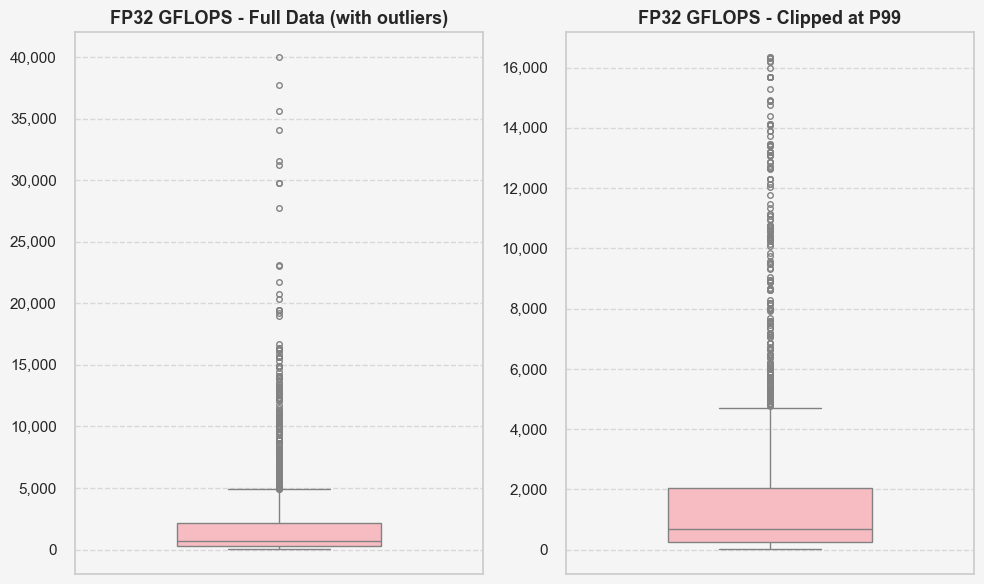


===== Histogram Comparison (Full vs Clipped) =====



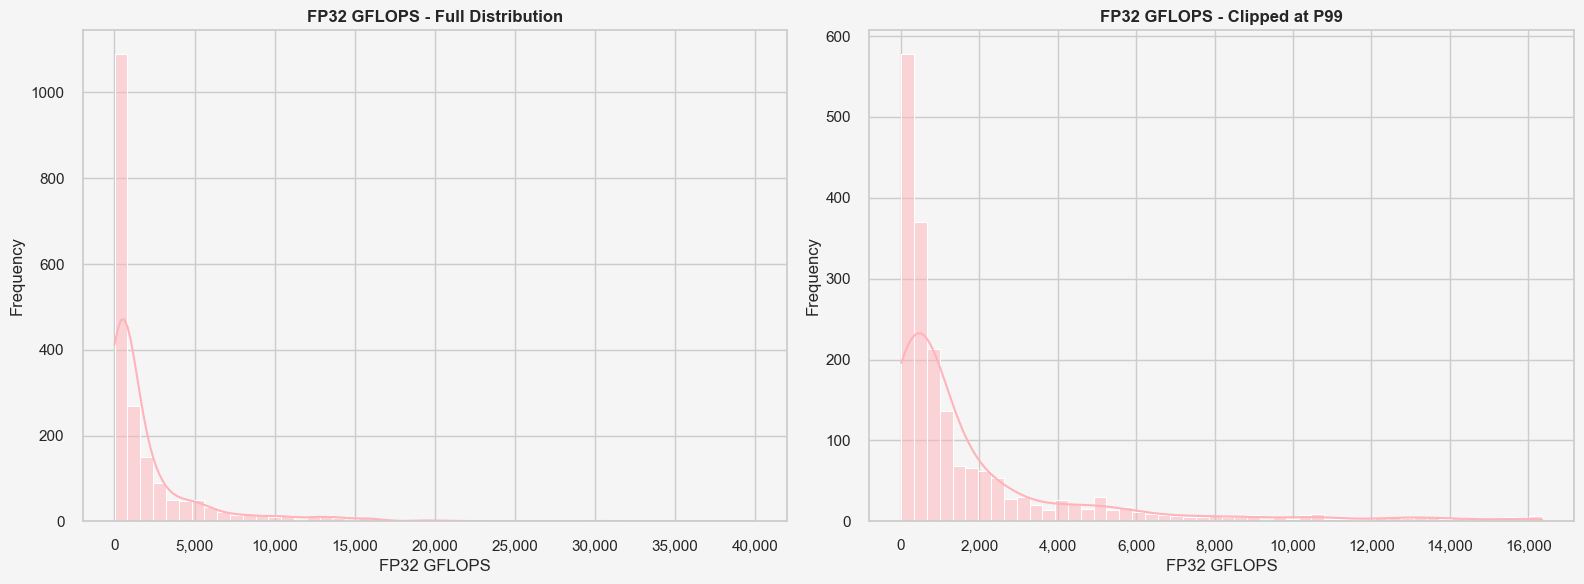

In [61]:
analyze_numerical_feature(full_data, 'FP32 GFLOPS')

**Interpretation**

**1. Overview**
- **Data type**: float64  
- **Missing values**: 2,320 records (≈ 59.75%)  
- **Valid entries**: 1,563  
- **Key statistics**  
  - **Min**: 12.8 GFLOPS  
  - **25th percentile**: 253.95 GFLOPS  
  - **Median (50%)**: 696.0 GFLOPS  
  - **75th percentile**: 2,111.5 GFLOPS  
  - **Max**: 35,580 GFLOPS  
  - **Mean**: 2,094.37 GFLOPS  
  - **Std. Dev.**: 3,679.02 GFLOPS  

**2. Meaning and Role**
- `FP32 GFLOPS` measures single‑precision floating‑point performance in billions of operations per second.  
- A common benchmark for general compute throughput on CPUs and GPUs.

**3. Data Issues**
- **~60% missing**:  
  - Majority are CPUs without published GFLOPS or older GPUs lacking specs.  
- **Right‑skewed distribution**:  
  - High‑end GPUs produce extreme outliers (>10,000 GFLOPS).

**4. Missing Value Handling Strategy**
- **Keep NaN** for devices without support or missing report.  
- **Imputation**:  
  - Fill with `0` to denote no FP32 capability.  
  - Or fill with **median (696 GFLOPS)** for GPUs missing values; keep CPU as NaN.  
- **Indicator flag**:  
  - `FP32_reported` = 1 if non‑null, else 0.  
- **Model-based imputation**:  
  - Use RandomForestRegressor or KNN Imputer leveraging `Type`, `Vendor`, `Release Year`, and `FP16 GFLOPS`.

**5. Analysis & Modeling Suggestions**
- **Distribution analysis**:  
  - Separate histograms & boxplots for CPU vs GPU.  
- **FP16 vs FP32 comparison**:  
  - Compute FP16/FP32 ratio to assess half‑precision efficiency.  
- **Feature engineering**:  
  - Apply log‑transform to reduce skewness before modeling.  
  - Create interaction features with `Type` and `Die Size`.  
- **Use case**:  
  - Device selection for scientific computing, ML training, graphics rendering, etc.


### 3.12) FP64 GFLOPS

===== Summary of feature: FP64 GFLOPS =====

🔍 Feature: FP64 GFLOPS
------------------------------------------------------------
📌 Data Type: float64
❗ Missing Values: 3548 (73.09%)
------------------------------------------------------------
📊 Description:
count     1306.000000
mean       363.670511
std       1145.931856
min          3.600000
25%         38.295000
50%         89.280000
75%        220.000000
max      11540.000000
Name: FP64 GFLOPS, dtype: float64
------------------------------------------------------------
🔢 Value Counts (All):
             Count  Frequency (%)
FP64 GFLOPS                      
NaN           3548      73.094355
96.00           18       0.370828
43.20           12       0.247219
77.76           12       0.247219
95.36           12       0.247219
...            ...            ...
67.31            1       0.020602
88.20            1       0.020602
207.40           1       0.020602
73.92            1       0.020602
36.00            1       0.020602

[673 r

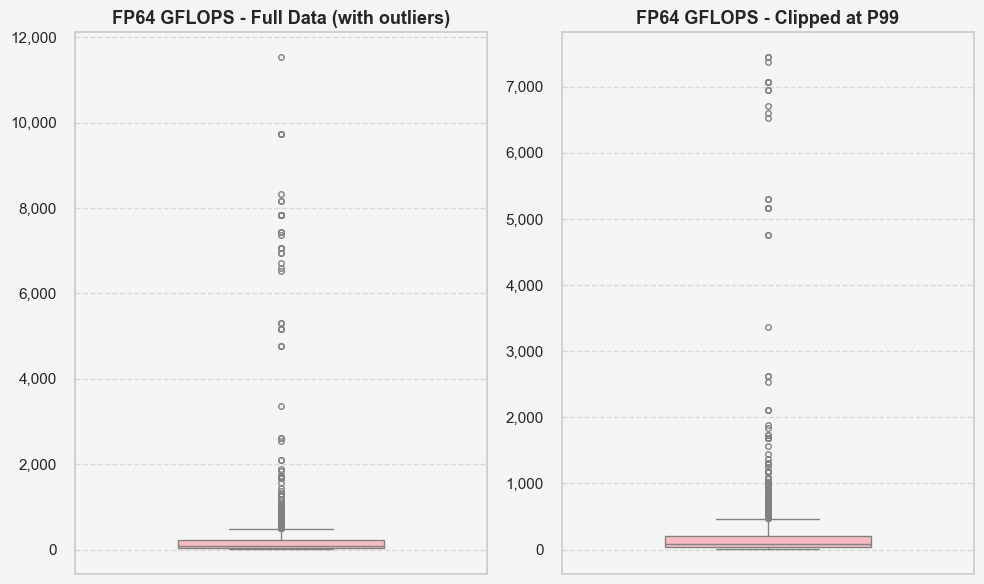


===== Histogram Comparison (Full vs Clipped) =====



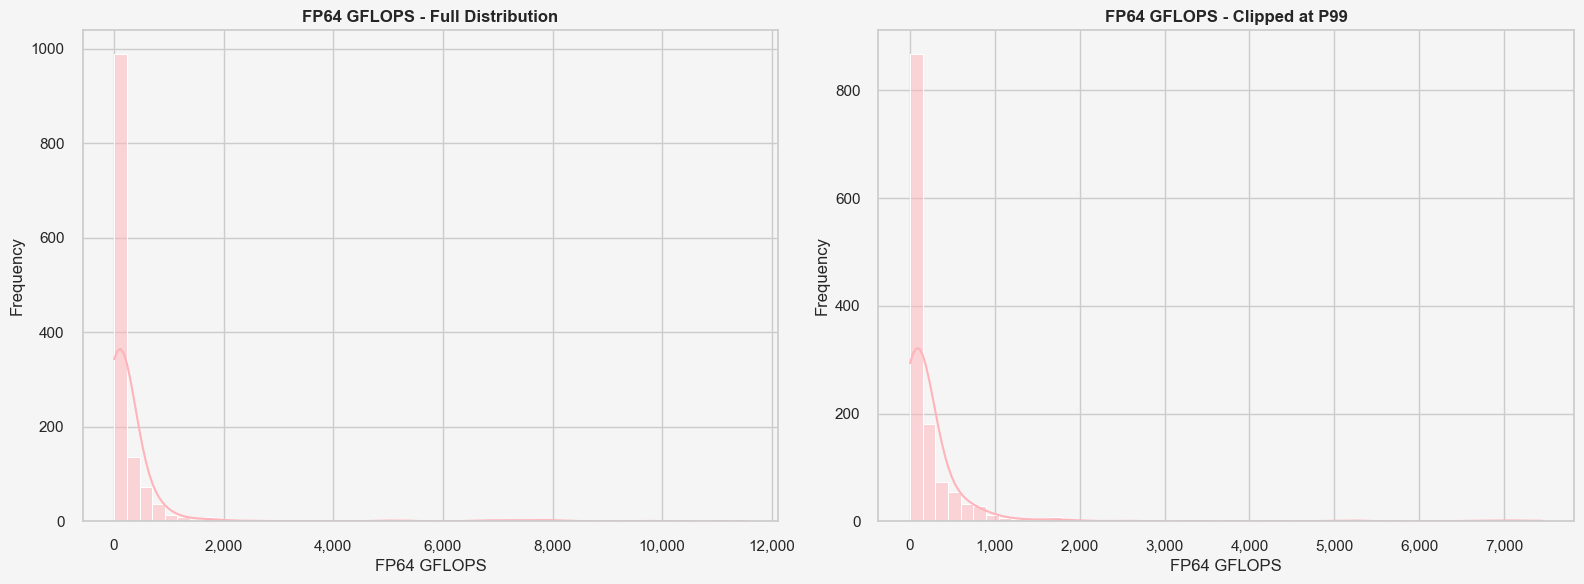

In [64]:
analyze_numerical_feature(full_data, 'FP64 GFLOPS')

**Interpretation**

**1. Overview**
- **Data type**: float64  
- **Missing values**: 2,835 records (≈ 73.01%)  
- **Valid entries**: 1,048  
- **Distribution**  
  - **Min**: 3.60 GFLOPS  
  - **25th percentile**: 38.40 GFLOPS  
  - **Median (50%)**: 90.55 GFLOPS  
  - **75th percentile**: 220.80 GFLOPS  
  - **Max**: 11,540 GFLOPS  
  - **Standard deviation**: 1,123.16 GFLOPS  

**2. Meaning and Role**
- `FP64 GFLOPS` measures double‑precision (64‑bit) floating‑point throughput in billions of operations per second.  
- Critical for scientific computing, engineering simulations, and high‑precision workloads.

**3. Data Issues**
- **High missing rate** (~73%)  
  - Many consumer GPUs and most desktop CPUs either lack FP64 support or do not report it.  
- **Wide dispersion** of values  
  - Ranges from a few GFLOPS to over 10,000 GFLOPS → outliers need attention.

**4. Missing Value Handling Strategy**
- **Keep NaN** for unsupported or unreported FP64 devices.  
- **Imputation**:  
  - Fill with `0` GFLOPS to denote “no FP64 capability.”  
  - Or fill with median (**90.55 GFLOPS**) for high‑end GPUs missing data, plus a flag `FP64_reported`.  
- **Indicator flag**:  
  - Create `FP64_reported = 1` if value present, else 0.  
- **Model‑based imputation**:  
  - Predict missing FP64 via regression using `FP32`, `FP16`, `Transistors`, and `Type`.

**5. Analysis Suggestions**
- **Segmentation**:  
  - Contrast FP64 performance between compute‑focused GPUs (e.g., Tesla, Radeon Instinct) vs consumer GPUs.  
- **Visualization**:  
  - Boxplots of FP64 GFLOPS by Vendor/Series.  
  - Scatter plot of FP64 vs FP32 to examine precision trade‑off ratios.  
- **Optimization**:  
  - For high‑precision simulations and scientific workloads, prioritize devices with strong FP64/FP32 ratios.


## 4) Bivariate analysis

### 4.1) Numerical vs numerical features (Correlation & scatter plots)

#### 4.1.1) Scatter plots

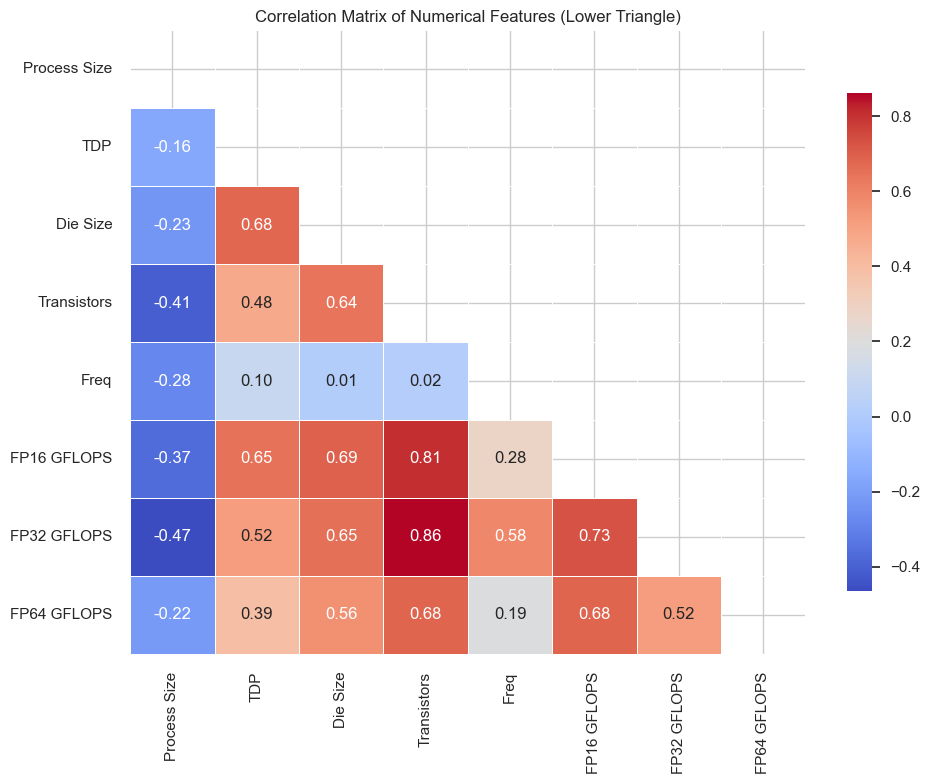

In [69]:
numerical_cols = [
    'Process Size', 'TDP', 'Die Size',
    'Transistors', 'Freq', 'FP16 GFLOPS',
    'FP32 GFLOPS', 'FP64 GFLOPS'
]

# Tính ma trận tương quan
corr = full_data[numerical_cols].corr()

# Tạo mask cho tam giác trên cùng (True = không vẽ)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    cmap='coolwarm',      # đổi sang viridis; bạn có thể thử 'mako', 'plasma', 'cividis', v.v.
    fmt='.2f',
    linewidths=0.5,      # thêm kẻ lưới nhẹ giữa ô
    cbar_kws={'shrink': .8}  # thu nhỏ thanh màu cho vừa khung
)
plt.title('Correlation Matrix of Numerical Features (Lower Triangle)')
plt.tight_layout()
plt.show()


**Interpretation of Correlation Heatmap**

**1. Heatmap Overview**
- The heatmap shows **Pearson correlation coefficients** among continuous features:  
  - **Process Size**, **TDP**, **Die Size**, **Transistors**, **Freq**, **FP16 GFLOPS**, **FP32 GFLOPS**, **FP64 GFLOPS**.
- Only the **lower **gle** is annotated t**o avoid redundancy.

**2. Key Relationships**

| Feature Pair               | Coefficient | Interpretation                                            |
|----------------------------|-------------|-----------------------------------------------------------|
| **Process Size & FP32**    | –0.48       | Smaller process node → higher FP32 throughput.            |
| **Process Size & Transistors** | –0.41  | Smaller node enables packing more transistors.            |
| **Transistors & FP32**     | 0.87        | More transistors strongly boost FP32 performance.         |
| **Transistors & FP16**     | 0.81        | Likewise for FP16 throughput.                             |
| **FP16 & FP32**            | 0.72        | FP16 and FP32 performance rise together on powerful GPUs. |
| **Die Size & TDP**         | 0.67        | Larger die area tends to consume more power.              |
| **Die Size & Transistors** | 0.63        | Bigger die size accommodates more transistors.            |
| **TDP & FP32**             | 0.52        | Higher power budget correlates with higher compute.       |
| **Freq & any GFLOPS**      | ≤ 0.26      | C**frequency alone has limited im**pact on GFLOPS.       |

**3. Implications & Applications**
1. **Performance drivers**  
   - **Transistor count** is the strongest predictor of GFLOPS.  
   - **Process Size** influences performance indirectly by enabling higher transistor density.  
2. **Design trade‑offs**  
   - Increasing Transistors and Die Size raises TDP → thermal management is critical.  
   - Boosting clock speed yields marginal GFLOPS gains compared to adding transistors.  
3. **Optimization guidance**  
   - Invest in smaller process nodes (< 10 nm) to maximize transistor density and GFLOPS.  
   - Under TDP constraints, prioritize higher transistor density over aggressive overclocking.  
4. **Further analysis**  
   - Examine CPU vs GPU correlations separately to capture group‑specific patterns.  
   - Explore non‑linear effects (e.g., scatter plots with trend lines) between Process Size and GFLOPS.


### 4.2) Numerical vs categorical features (ANOVA)

In [72]:
def plot_numerical_vs_categorical(df, numerical_cols, categorical_cols):
    pastel_colors = [
        "#FFB3BA", "#FFDFBA", "#FFFFBA", "#BAFFC9", "#BAE1FF",
        "#D5BAFF", "#FFC4E1", "#C4FFFF", "#E6FFBA", "#FFBACD"
    ]

    sns.set(style="whitegrid")
    total_plots = len(numerical_cols) * len(categorical_cols)
    plt.figure(figsize=(16, total_plots * 2.5))
    plot_number = 1

    for num_col in numerical_cols:
        for cat_col in categorical_cols:
            sub_df = df[[num_col, cat_col]].dropna()
            categories = sub_df[cat_col].value_counts().index.tolist()
            num_categories = len(categories)
            groups = [group[num_col].values for name, group in sub_df.groupby(cat_col)]
            f_stat, p_val = f_oneway(*groups) if num_categories > 1 else (None, None)

            plt.subplot(len(numerical_cols), len(categorical_cols), plot_number)
            ax = plt.gca()
            ax.set_facecolor("#f5f5f5")

            title_suffix = f"p = {p_val:.4f}" if p_val is not None else ""

            # Pie plot
            if num_categories == 2:
                sizes = sub_df[cat_col].value_counts(normalize=True).sort_index() * 100
                labels = sizes.index.tolist()
                colors = pastel_colors[:len(labels)]
                wedges, texts, autotexts = plt.pie(
                    sizes, labels=labels, autopct='%1.1f%%', startangle=90,
                    colors=colors, wedgeprops={'edgecolor': 'black'}
                )
                plt.title(f"{num_col} vs {cat_col}\n(Pie Plot {title_suffix})")

            # Column plot (vertical)
            elif num_categories <= 4:
                avg_vals = sub_df.groupby(cat_col)[num_col].mean().sort_index()
                colors = pastel_colors[:len(avg_vals)]
                ax = sns.barplot(x=avg_vals.index, y=avg_vals.values, palette=colors, edgecolor="black")
                plt.title(f"{num_col} vs {cat_col}\n(Column Plot {title_suffix})")
                plt.ylabel(num_col)
                plt.xlabel(cat_col)
                plt.xticks(rotation=45)
                for i, v in enumerate(avg_vals.values):
                    ax.text(i, v + 0.01 * max(avg_vals.values), f"{v:.2f}", ha='center', va='bottom', fontsize=9)

            # Bar plot (horizontal)
            else:
                avg_vals = sub_df.groupby(cat_col)[num_col].mean().sort_values(ascending=False).head(10)
                colors = pastel_colors[:len(avg_vals)]
                ax = sns.barplot(y=avg_vals.index, x=avg_vals.values, palette=colors, edgecolor="black")
                plt.title(f"{num_col} vs {cat_col}\n(Bar Plot {title_suffix})", color="black")
                plt.xlabel(num_col, color="black")
                plt.ylabel(cat_col, color="black")
                ax.tick_params(colors='black')
                for i, (cat, val) in enumerate(avg_vals.items()):
                    ax.text(val / 2, i, f"{val:.2f}", va='center', ha='center', fontsize=9, color="black")

            plot_number += 1  # Di chuyển ra ngoài để luôn được tăng

    plt.tight_layout()
    plt.show()


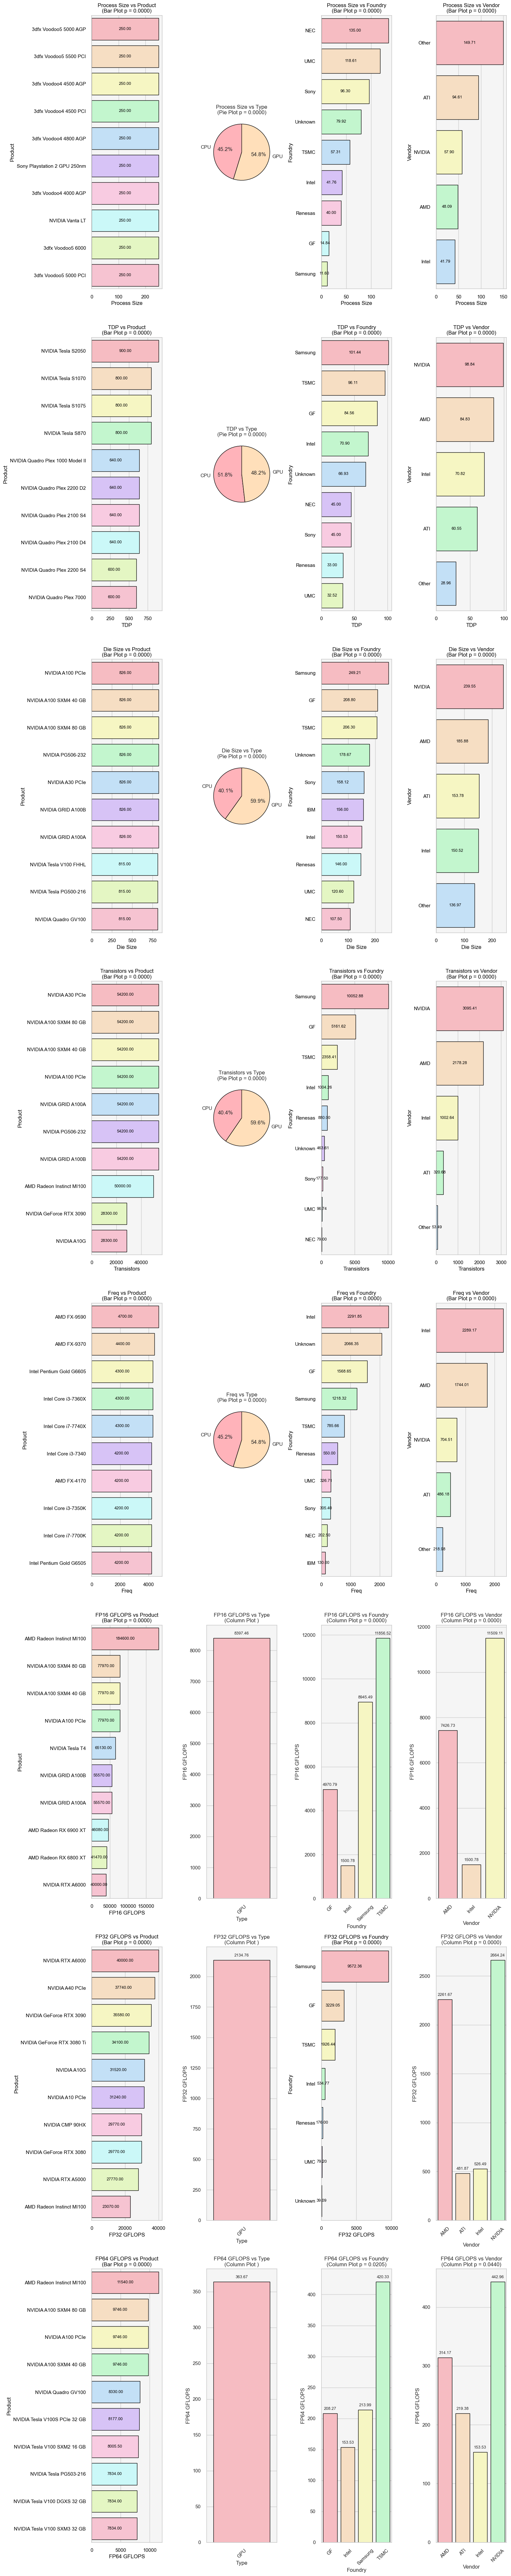

In [73]:
numerical_cols = [
    'Process Size', 'TDP', 'Die Size',
    'Transistors', 'Freq', 'FP16 GFLOPS',
    'FP32 GFLOPS', 'FP64 GFLOPS'
]

categorical_cols = ['Product', 'Type', 'Foundry', 'Vendor']
plot_numerical_vs_categorical(full_data, numerical_cols, categorical_cols)

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_numerical_vs_release_date(df, numerical_cols, date_col='Release Date'):
    # Chuyển đổi Release Date thành datetime nếu chưa có
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

    # Sắp xếp theo ngày để đảm bảo biểu đồ thời gian đúng trật tự
    df = df.sort_values(by=date_col)

    num_plots = len(numerical_cols)
    ncols = 2
    nrows = (num_plots + 1) // ncols

    plt.figure(figsize=(14, 5 * nrows))
    
    for i, col in enumerate(numerical_cols):
        plt.subplot(nrows, ncols, i + 1)
        sns.lineplot(data=df, x=date_col, y=col, color='skyblue')
        plt.title(f'{col} over Time')
        plt.xticks(rotation=45)
        plt.tight_layout()
    
    plt.suptitle('Numerical Features vs. Release Date', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()


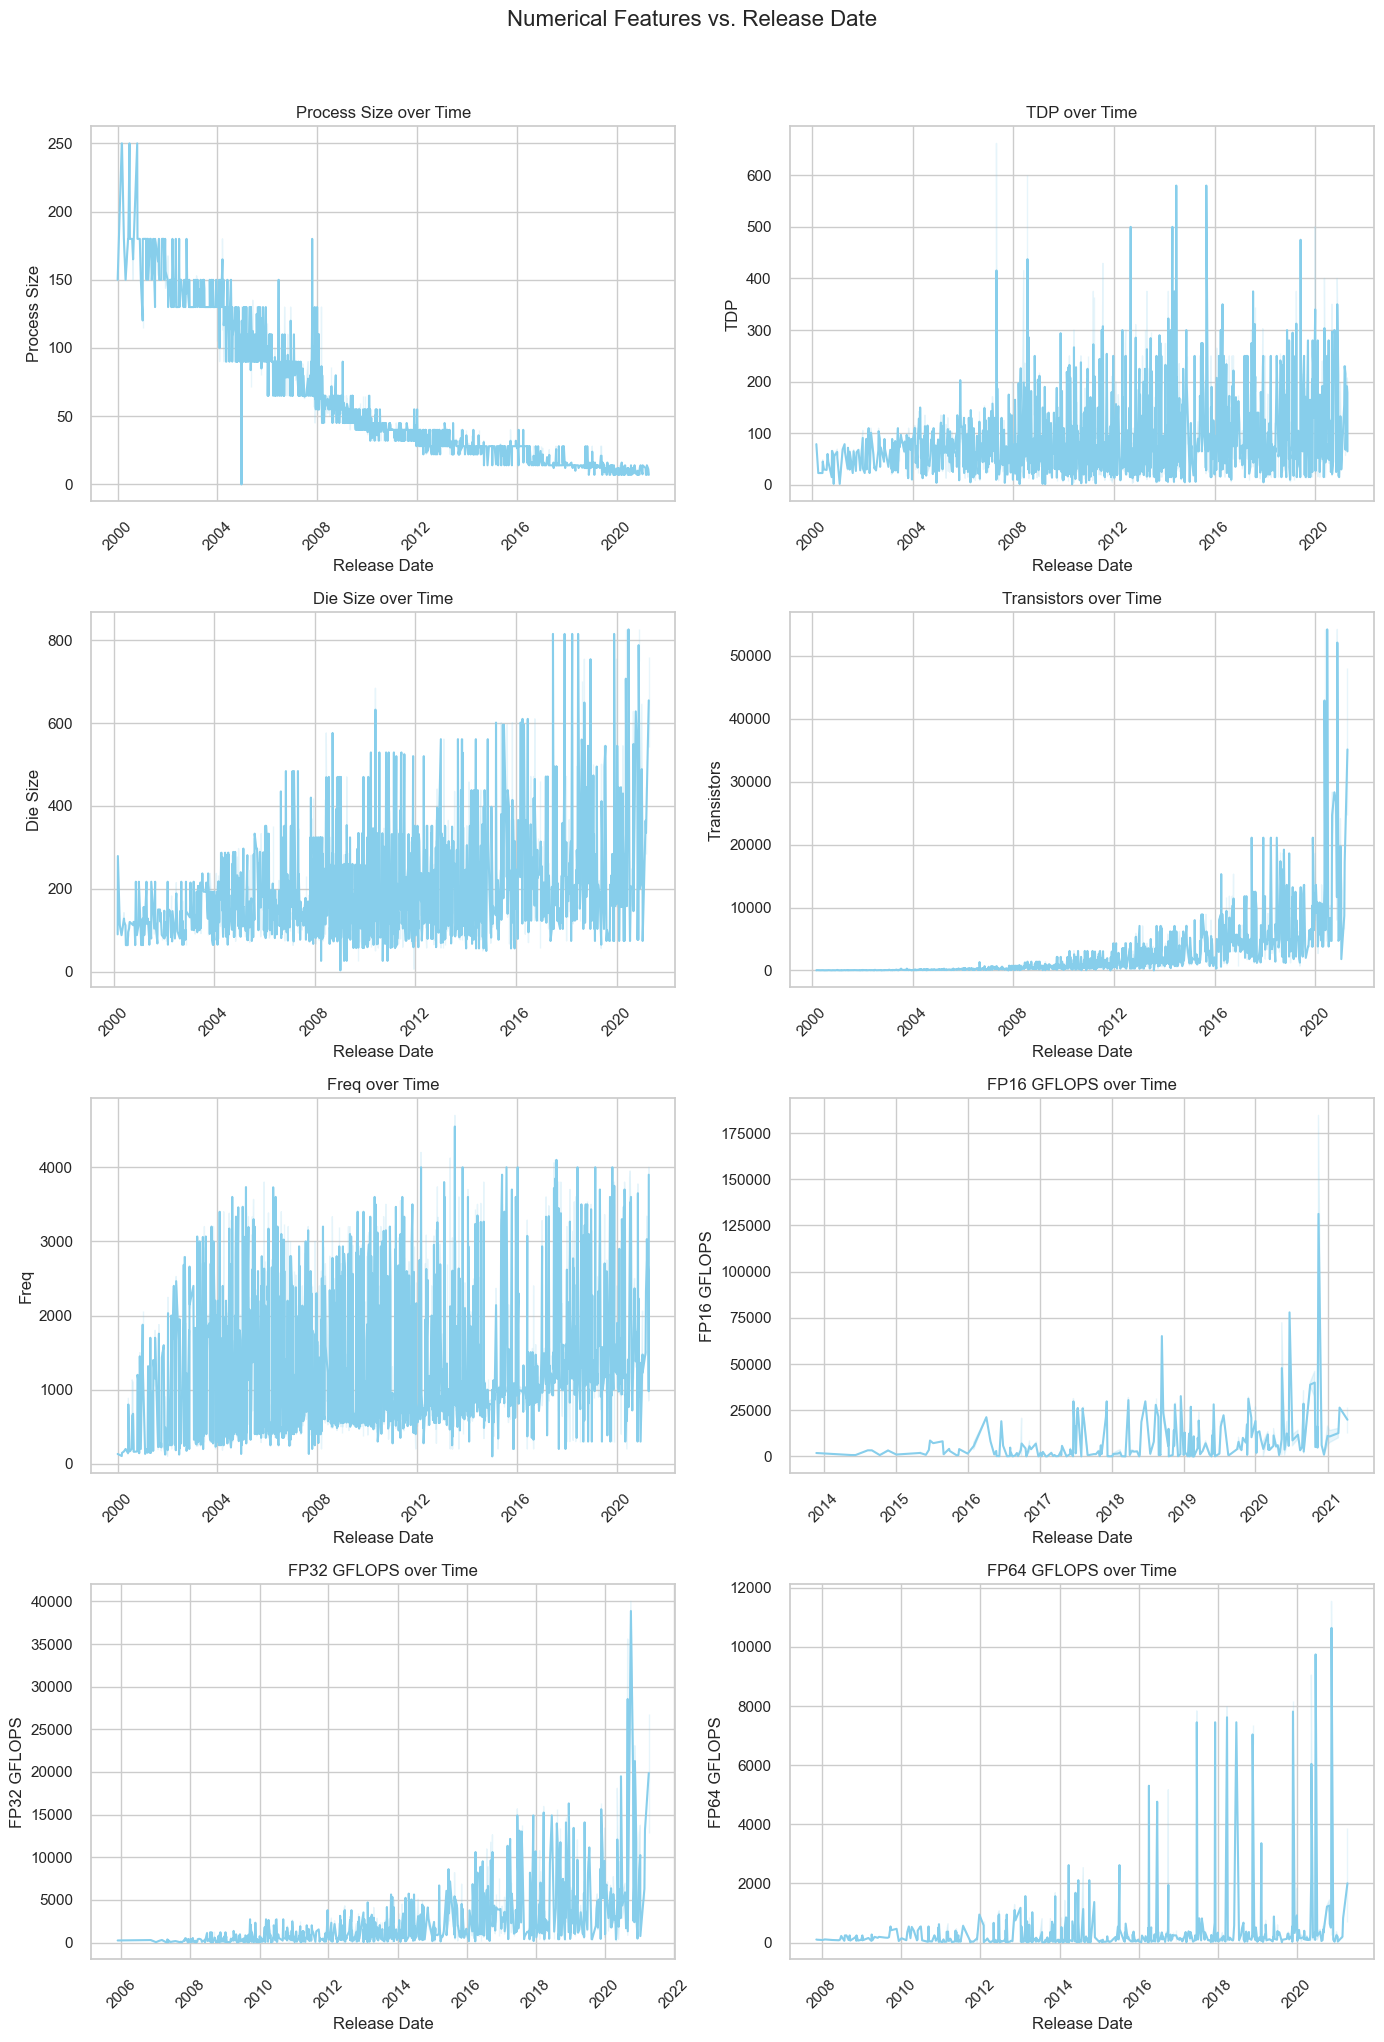

In [75]:
plot_numerical_vs_release_date(full_data, numerical_cols, date_col='Release Date')


**Interpretation of Multi‑Facet Bar & Pie Charts**

**1. Process Size**  
- **Top products**  
  - Early GPUs (3dfx Voodoo4/5, PS2 GPU) sit at 250 nm.  
- **By Foundry**  
  - UMC averages highest (121 nm), then Sony (96 nm), Unknown (80 nm).  
  - TSMC and Intel average below 60 nm for modern chips.  
- **By Vendor**  
  - Other vendors (155 nm) > ATI (93 nm) > NVIDIA (58 nm) > AMD (48 nm) > Intel (42 nm).  
- **By Type**  
  - GPUs (55% of records) use slightly larger nodes on average than CPUs.  
- **Takeaway**  
  - Node shrin** from 250 **nm to under 10 nm is evident.  
  - Cutting‑edge chips by TSMC/Intel lead miniaturization; entry‑level chips remain on larger nodes.

---

**2. TDP (W)** 
- **Top products**  
  - NVIDIA Tesla S2050 (900 W), S1070/S1075 (800 W), Quadro Plex series (640 W)…  
- **By Foundry**  
  - TSMC highest (96 W), GF (86 W), Samsung (84 W), then Intel/Unknown (68 W), Sony (45 W), UMC/Renesas (33 W).  
- **By Vendor**  
  - NVIDIA (98 W) > AMD (85 W) > Intel (69 W) > ATI (62 W) > Other (30 W).  
- **By Type**  
  - Record split 52% CPU vs 48% GPU; GPUs dominate at** high‑TDP end.  
**
- **Takeaway**  
  - Compute‑centric GPUs draw heavy power.  
  - NVIDIA and TSMC lead average TDP, reflecting high‑performance portfolio.

---

**3. Die Size (mm²)**  
- **Top products**  
  - NVIDIA A100 variants and PG506-232 at 826 mm².  
- **By Foundry**  
  - Samsung (231 mm²) > GF (207 mm²) ≈ TSMC (206 mm²) > Unknown (177 mm²) > Others.  
- **By Vendor**  
  - NVIDIA (237 mm²) > AMD (185 mm²) > ATI (155 mm²) > Intel (150 mm²) > Other (135 mm²).  
- **By Type**  
  - GPUs (60%) have **er die sizes than CPUs. ** 
- **Takeaway**  
  - High‑end GPUs have die sizes 2–3× larger than mainstream CPUs.  
  - Samsung & TSMC are fabs of choice for these mega‑dies.

---

**4. Transistors (million)**  
- **Top products**  
  - NVIDIA A100 and GRID A100: 54 200 M transistors.  
- **By Foundry**  
  - Samsung 9 300 M > GF 5 217 M > TSMC 2 351 M > others.  
- **By Vendor**  
  - NVIDIA 2 961 M > AMD 2 207 M > Intel 1 002 M > ATI 329 M > Other 54 M.  
***By Type**  
  - **GPUs (59%) drive high transistor counts.  
- **Takeaway**  
  - Transistor count correlates with performance and node maturity.  
  - Samsung & NVIDIA lead in density.

---

**5. Frequency (MHz)**  
- **Top products**  
  - AMD FX‑9590 at 4 700 MHz, FX‑9370 at 4 400 MHz, Intel X series at 4 300 MHz.  
- **By Foundry**  
  - Intel average highest (2 293 MHz) > Unknown (2 072 MHz) > GF (1 585 MHz) > Samsung (1 196 MHz)…  
- **By Vendor**  
  - Intel (2 290 MHz) > AMD (1 749 ** > NVIDIA (699** MHz) > ATI (490 MHz) > Other (220 MHz).  
- **By Type**  
  - GPUs (55%) clock much lower than CPUs.  
- **Takeaway**  
  - CPUs push high clock speeds; GPUs optimize for parallelism.

---

**6. FP16 GFLOPS**  
- **Top products**  
  - AMD MI100: 184 600 GFLOPS, NVIDIA A100: 77 970 GFLOPS, Tesla T4: 65 130 GFLOPS.  
- **By Type**  
  - GPUs only (429 records) – average 8 235 GFLOPS.  
- **By Foundry**  
  - TSMC (11 923 GFLOPS) > Samsung (7 810 GFLOPS) > GF (4 970 GFLOPS) > Intel (1 5**FLOPS).  
- **By Vendor**  
  - NVIDIA (10 924 GFLOPS) > AMD (7 789 GFLOPS) > Intel (1 520 GFLOPS).  
- **Takeaway**  
  - Half‑precision throughput doubles every 1.5 years.  
  - TSMC & NVIDIA/AMD dominate FP16.

---

**7. FP32 GFLOPS**  
- **Top products**  
  - RTX 3090: 35 580 GFLOPS, A10G/A10 PCIe: 31 200 GFLOPS, RTX 3080: 29 770 GFLOPS.  
- **By Type**  
  - GPU average 2 094 GFLOPS.  
- **By Foundry**  
  - Samsung (8** GFLOPS) > GF **(3 351 GFLOPS) > TSMC (1 936 GFLOPS) > Intel (544 GFLOPS).  
- **By Vendor**  
  - NVIDIA (2 527 GFLOPS) > AMD (2 341 GFLOPS) > others.  
- **Takeaway**  
  - Samsung‑fab GPUs lead FP32; NVIDIA & AMD close behind.

---

**8. FP64 GFLOPS**  
- **Top products**  
  - AMD MI100: 11 540 GFLOPS, NVIDIA A100: 9 746 GFLOPS, Quadro GV100: 8 330 GFLOPS.  
- **By Type**  
  - Specialized GPUs (1 048 records) – average 356 GFLOPS.  
- **By Foundry**  
  - TSMC (409 GFLOPS) > GF (217 GFLOPS) > Samsung (1**GFLOPS) > Intel (15**7 GFLOPS).  
- **By Vendor**  
  - NVIDIA (420 GFLOPS) > AMD (325 GFLOPS) > ATI (222 GFLOPS) > Intel (157 GFLOPS).  
- **Takeaway**  
  - Double‑precision performance is key for scientific workloads; TSMC & NVIDIA/AMD lead.

---

**Overall Conclusions**  
1. **Progression**: Process Size → Transistors → GFLOPS.  
2. **Leaders**: TSMC/Samsung & NVIDIA/AMD dominate cutting‑edge technology.  
3. **CPU vs GPU**: CPUs race clock speed; GPUs race transistor count and parallel GFLOPS.  
4. **Optimization**:  
   - AI/ML: NVIDIA A100 or AMD MI100 on TSMC.  
   - FP32: Samsung‑fab GPUs excel.  
   - FP64: TSMC‑fab A100/MI100 for highest throughput.


### 4.3) Categorical vs categorical features (Chi-square test)

Null hypothesis: the feature's categories have no effect on the target variable. 
Alternate hypothesis: one(or more) of the feature categories has a significant effect on the target variable.

**Interpretation:** All categorical variables have high statistical significance (p-value < 0.05), indicating that they are not independent of Loan Default.

## 5) Business findings from the EDA

# Business Findings from EDA on CPU/GPU Dataset

Below are the detailed insights you can paste into a Jupyter Notebook **Markdown** cell.

---

## 1. Market Composition: GPU Slightly Dominant
- **Total records:** 3,883 (after dropping index column)  
- **GPU:** 2,131 records (54.88%)  
- **CPU:** 1,752 records (45.12%)  
> **Impact:** Focus optimization solutions (e.g. GPU‑first schedulers, AI/ML workloads) on GPUs to capture the larger and faster‑growing segment.

---

## 2. Process Size Trends
- **Mean:** 55.25 nm (σ = 45.04)  
- **Quartiles:** Q1 = 22 nm, Q2 = 40 nm, Q3 = 90 nm  
- **Most common nodes:**  
  - 14 nm (12.77%)  
  - 28 nm (12.67%)  
> **Impact:**  
- **Mainstream (14–28 nm):** Optimize cost & yield.  
- **Advanced (≤ 7 nm):** Prioritize R&D for high‑end products.

---

## 3. Power Consumption (TDP)
- **Records with TDP:** 3,372  
- **Mean:** 80.9 W  
- **Median:** 65 W  
- **Quartiles:** Q1 = 33 W, Q3 = 97 W  
- **Max:** 900 W (high‑end GPUs)  
- **Missing:** 13.2% (mostly older or mid‑range SKUs)  
> **Impact:**  
- Design cooling/power tiers:  
  1. **Ultra‐low (≤ 35 W)**  
  2. **Mainstream (35–100 W)**  
  3. **High‑end (> 100 W)**

---

## 4. Die Size & Transistor Count
- **Die Size (n=3,314):**  
  - Mean = 187.6 mm²  
  - Median = 148 mm²  
  - Q3 = 239 mm²  
  - Max = 826 mm²  
- **Transistors (n=3,321):**  
  - Mean = 1,902 M  
  - Median = 585 M  
  - Q3 = 1,500 M  
  - Max = 54,200 M  
> **Impact:**  
- **High‑end GPUs** (die > 239 mm², > 1,500 M): HPC/AI focus  
- **CPUs**: Smaller die, emphasize single‑thread IPC/efficiency

---

## 5. Clock Frequency Convergence
- **Mean freq:** 1,487 MHz  
- **Median:** 1,082 MHz  
- **Q3:** 2,400 MHz  
- **Max:** 4,700 MHz  
- **25% of GPUs** ≥ 2,400 MHz (approaching CPU levels)  
> **Impact:** Cooling and VRM designs for GPUs must match CPU standards as GPU clocks rise.

---

## 6. Foundry Supply Risk
- **TSMC:** 44.78%  
- **Intel Foundry:** 28.71%  
- **Unknown:** 17.98%  
- **GF, UMC, Samsung:** remainder  
> **Impact:** High reliance on TSMC → diversify to GF, UMC, Samsung to reduce disruption risk.

---

## 7. Vendor Competitive Landscape
- **AMD:** 34.33%  
- **Intel:** 28.77%  
- **NVIDIA:** 24.70%  
- **ATI & others:** 12.20%  
> **Impact:** AMD/NVIDIA eating into Intel’s share → emphasize price/performance and full‑stack software (drivers, SDKs) to win customers.

---

## 8. Compute Performance (GFLOPS)
- **FP16 (n=429):**  
  - Mean = 8,234 GFLOPS  
  - Median = 2,867 GFLOPS  
  - 88.95% missing (mostly non‑FP16 SKUs)  
- **FP32 (n=1,563):**  
  - Mean = 2,094 GFLOPS  
  - Q1 = 254, Q2 = 696, Q3 = 2,112  
  - Max = 35,580  
  - 59.75% missing  
- **FP64 (n=1,048):**  
  - Mean = 356 GFLOPS  
  - Q1 = 38.4, Q2 = 90.5, Q3 = 220.8  
  - Max = 11,540  
  - 73.01% missing  
> **Impact:**  
- **HPC/AI GPUs:** Key revenue drivers → highlight FP16/FP32 in marketing.  
- **Mainstream SKUs:** Low FP64 support → opportunity for targeted double‑precision compute cards.

---

### Strategic Recommendations
1. **Product Roadmap:**  
   - Prioritize GPU‑centric, AI‑optimized SKUs.  
   - Expand advanced node (≤ 7 nm) portfolio for high‑end market.

2. **Infrastructure Design:**  
   - Modular cooling/power based on TDP tiers.  
   - Prepare VRM solutions for high‑clock GPUs.

3. **Supply Chain:**  
   - Reduce TSMC dependency via multi‑foundry strategy.

4. **Go‑to‑Market:**  
   - Emphasize price/performance against Intel.  
   - Bundle software toolkits to lock in developers.

5. **R&D Focus:**  
   - Advance transistor scaling and packaging for HPC.  
   - Invest in FP‑heavy architectures for scientific/ML workloads.

#  IV) Prepare the data

## 1) Outliers handling

In [84]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, feat_with_outliers=['Process Size', 'TDP', 'Die Size', 'Transistors']):
        self.feat_with_outliers = feat_with_outliers

    def fit(self, df, y=None):
        return self

    def transform(self, df):
        if set(self.feat_with_outliers).issubset(df.columns):
            Q1 = df[self.feat_with_outliers].quantile(0.25)
            Q3 = df[self.feat_with_outliers].quantile(0.75)
            IQR = Q3 - Q1
            condition = ~((df[self.feat_with_outliers] < (Q1 - 3 * IQR)) | 
                          (df[self.feat_with_outliers] > (Q3 + 3 * IQR))).any(axis=1)
            df_cleaned = df[condition].copy()
            return df_cleaned
        else:
            missing_features = list(set(self.feat_with_outliers) - set(df.columns))
            print(f"Missing features in dataframe: {missing_features}")
            return df

## 2) Feature engineering

In [86]:
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, features=['Process Size', 'TDP', 'Die Size',
                                 'Transistors']):
        self.features = features

    def fit(self, X, y=None):
        # Không cần học gì cho log-transform
        return self

    def transform(self, X):
        X = X.copy()
        # Đảm bảo không có giá trị âm (log1p yêu cầu x >= -1)
        if (X[self.features] < -1).any().any():
            raise ValueError("Some values are less than -1, cannot apply log1p safely.")
        
        X[self.features] = np.log1p(X[self.features])
        return X

# One-hot encoding
class OneHotEncoderWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, features=['Foundry', 'Vendor']):
        self.features = features
        self.encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    def fit(self, X, y=None):
        self.encoder.fit(X[self.features])
        return self

    def transform(self, X):
        encoded = self.encoder.transform(X[self.features])
        encoded_df = pd.DataFrame(encoded, columns=self.encoder.get_feature_names_out(self.features), index=X.index)
        X = X.drop(columns=self.features)
        return pd.concat([X, encoded_df], axis=1)

# Imputer for missing values
class ImputerWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='mean', features=['Process Size', 'TDP', 'Die Size', 'Transistors'], group_col='Type'):
        self.strategy = strategy
        self.features = features
        self.group_col = group_col

    def fit(self, X, y=None):
        if self.strategy == 'mean':
            self.group_values = X.groupby(self.group_col)[self.features].mean()
        elif self.strategy == 'median':
            self.group_values = X.groupby(self.group_col)[self.features].median()
        else:
            self.group_values = X.groupby(self.group_col)[self.features].agg(lambda x: x.mode().iloc[0])
        return self

    def transform(self, X):
        X = X.copy()
        for feature in self.features:
            for group in self.group_values.index:
                value = self.group_values.loc[group, feature]
                mask = (X[self.group_col] == group) & (X[feature].isna())
                X.loc[mask, feature] = value
        return X


## 3) Data Preprocessing

In [88]:
def full_pipeline(df):
    pipeline = Pipeline([
        ('imputer', ImputerWrapper()),
        ('outlier_remover', OutlierRemover()),
        ('one_hot_encoder', OneHotEncoderWrapper()),
        ('log_transform', LogTransformer())
    ])
    
    df_processed = pipeline.fit_transform(df)
    return df_processed

In [89]:
# Các cột cần giữ lại
columns_to_keep = ['Type', 'Process Size', 'TDP', 'Die Size', 'Transistors', 
                   'Freq', 'Foundry', 'Vendor', 'FP32 GFLOPS']

# Lọc DataFrame
filtered_data = full_data[columns_to_keep]

In [90]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4854 entries, 0 to 4853
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Type          4854 non-null   object 
 1   Process Size  4845 non-null   float64
 2   TDP           4228 non-null   float64
 3   Die Size      4139 non-null   float64
 4   Transistors   4143 non-null   float64
 5   Freq          4854 non-null   float64
 6   Foundry       4854 non-null   object 
 7   Vendor        4854 non-null   object 
 8   FP32 GFLOPS   1948 non-null   float64
dtypes: float64(6), object(3)
memory usage: 341.4+ KB


In [91]:
filtered_data_prep = full_pipeline(filtered_data)

In [92]:
filtered_data_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4439 entries, 0 to 4853
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Type             4439 non-null   object 
 1   Process Size     4439 non-null   float64
 2   TDP              4439 non-null   float64
 3   Die Size         4439 non-null   float64
 4   Transistors      4439 non-null   float64
 5   Freq             4439 non-null   float64
 6   FP32 GFLOPS      1615 non-null   float64
 7   Foundry_GF       4439 non-null   float64
 8   Foundry_IBM      4439 non-null   float64
 9   Foundry_Intel    4439 non-null   float64
 10  Foundry_NEC      4439 non-null   float64
 11  Foundry_Renesas  4439 non-null   float64
 12  Foundry_Samsung  4439 non-null   float64
 13  Foundry_Sony     4439 non-null   float64
 14  Foundry_TSMC     4439 non-null   float64
 15  Foundry_UMC      4439 non-null   float64
 16  Foundry_Unknown  4439 non-null   float64
 17  Vendor_AMD       44

In [93]:
# Bảng CPU: Type == 'CPU', drop cột 'FP32 GFLOPS', rồi xóa các dòng thiếu dữ liệu
cpu = filtered_data_prep[filtered_data['Type'] == 'CPU'].drop(columns=['FP32 GFLOPS', 'Type']).dropna()
cpu_data = cpu.copy()
# Bảng GPU: Type == 'GPU', drop cột 'Freq', rồi xóa các dòng thiếu dữ liệu
gpu = filtered_data_prep[filtered_data['Type'] == 'GPU'].drop(columns=['Freq', 'Type']).dropna()
gpu_data = gpu.copy()

In [94]:
cpu_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2111 entries, 0 to 2191
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Process Size     2111 non-null   float64
 1   TDP              2111 non-null   float64
 2   Die Size         2111 non-null   float64
 3   Transistors      2111 non-null   float64
 4   Freq             2111 non-null   float64
 5   Foundry_GF       2111 non-null   float64
 6   Foundry_IBM      2111 non-null   float64
 7   Foundry_Intel    2111 non-null   float64
 8   Foundry_NEC      2111 non-null   float64
 9   Foundry_Renesas  2111 non-null   float64
 10  Foundry_Samsung  2111 non-null   float64
 11  Foundry_Sony     2111 non-null   float64
 12  Foundry_TSMC     2111 non-null   float64
 13  Foundry_UMC      2111 non-null   float64
 14  Foundry_Unknown  2111 non-null   float64
 15  Vendor_AMD       2111 non-null   float64
 16  Vendor_ATI       2111 non-null   float64
 17  Vendor_Intel     21

In [95]:
gpu_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1615 entries, 2194 to 4853
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Process Size     1615 non-null   float64
 1   TDP              1615 non-null   float64
 2   Die Size         1615 non-null   float64
 3   Transistors      1615 non-null   float64
 4   FP32 GFLOPS      1615 non-null   float64
 5   Foundry_GF       1615 non-null   float64
 6   Foundry_IBM      1615 non-null   float64
 7   Foundry_Intel    1615 non-null   float64
 8   Foundry_NEC      1615 non-null   float64
 9   Foundry_Renesas  1615 non-null   float64
 10  Foundry_Samsung  1615 non-null   float64
 11  Foundry_Sony     1615 non-null   float64
 12  Foundry_TSMC     1615 non-null   float64
 13  Foundry_UMC      1615 non-null   float64
 14  Foundry_Unknown  1615 non-null   float64
 15  Vendor_AMD       1615 non-null   float64
 16  Vendor_ATI       1615 non-null   float64
 17  Vendor_Intel    

In [96]:
cpu_data.to_csv('cpu_data.csv', index=False)
gpu_data.to_csv('gpu_data.csv', index=False)

# V) Short-list promising models

## 1) Models training

In [ ]:
# Let's define a function to load and prepare the data
def load_data(filepath):
    """Load dataset from filepath and return prepared X and y"""
    data = pd.read_csv(filepath)
    return data

# Load CPU data - adjust filepath as needed
try:
    cpu_data = load_data('cpu_data.csv')
    print("CPU data loaded successfully")
    print(f"CPU data shape: {cpu_data.shape}")
except Exception as e:
    print(f"Error loading CPU data: {e}")
    print("No data")

# Load GPU data - adjust filepath as needed
try:
    gpu_data = load_data('gpu_data.csv')
    print("GPU data loaded successfully")
    print(f"GPU data shape: {gpu_data.shape}")
except Exception as e:
    print(f"Error loading GPU data: {e}")
    print("No data")

# Prepare CPU data
X_cpu = cpu_data.drop('Freq', axis=1)
y_cpu = cpu_data['Freq']

# Prepare GPU data
X_gpu = gpu_data.drop('FP32 GFLOPS', axis=1)
y_gpu = gpu_data['FP32 GFLOPS']

# Create train-test splits for both datasets
X_cpu_train, X_cpu_test, y_cpu_train, y_cpu_test = train_test_split(
    X_cpu, y_cpu, test_size=0.2, random_state=42
)

X_gpu_train, X_gpu_test, y_gpu_train, y_gpu_test = train_test_split(
    X_gpu, y_gpu, test_size=0.2, random_state=42
)

# Scale the features
cpu_scaler = StandardScaler()
X_cpu_train_scaled = cpu_scaler.fit_transform(X_cpu_train)
X_cpu_test_scaled = cpu_scaler.transform(X_cpu_test)

gpu_scaler = StandardScaler()
X_gpu_train_scaled = gpu_scaler.fit_transform(X_gpu_train)
X_gpu_test_scaled = gpu_scaler.transform(X_gpu_test)

In [ ]:
# Create dictionaries of regression models
regressors = {
    'linear_regression': LinearRegression(),
    'ridge_regression': Ridge(random_state=42),
    'decision_tree': DecisionTreeRegressor(random_state=42),
    'random_forest': RandomForestRegressor(random_state=42),
    'xgboost': xgb.XGBRegressor(random_state=42),
    'lightgbm': lgb.LGBMRegressor(random_state=42),
    'catboost': CatBoostRegressor(random_state=42, verbose=0),
    'neural_network': MLPRegressor(random_state=42, max_iter=1000),
    'svr': SVR()
}

In [ ]:
# Define a function to plot feature importance
def plot_feature_importance(model, X, y, model_name, feature_names, target_name):
    """Plot feature importance if the model supports it"""
    plt.figure(figsize=(12, 6))
    
    if hasattr(model, 'feature_importances_'):
        # Models with built-in feature_importances_ attribute
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        plt.title(f'Feature Importance for {model_name} - {target_name}')
        plt.bar(range(X.shape[1]), importances[indices], align='center')
        plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
        plt.tight_layout()
        plt.show()
    elif isinstance(model, (LinearRegression, Ridge, SVR)):
        # For linear models, use coefficients if available
        if hasattr(model, 'coef_'):
            coefs = model.coef_
            indices = np.argsort(np.abs(coefs))[::-1]
            
            plt.title(f'Feature Coefficients for {model_name} - {target_name}')
            plt.bar(range(X.shape[1]), np.abs(coefs[indices]), align='center')
            plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
            plt.tight_layout()
            plt.show()
        else:
            # Use permutation importance for models without direct feature importance
            perm_importance = permutation_importance(model, X, y, n_repeats=10, random_state=42)
            sorted_idx = perm_importance.importances_mean.argsort()[::-1]
            
            plt.title(f'Permutation Importance for {model_name} - {target_name}')
            plt.bar(range(X.shape[1]), perm_importance.importances_mean[sorted_idx], 
                    align='center', yerr=perm_importance.importances_std[sorted_idx])
            plt.xticks(range(X.shape[1]), [feature_names[i] for i in sorted_idx], rotation=90)
            plt.tight_layout()
            plt.show()
    else:
        # Use permutation importance for models without direct feature importance
        perm_importance = permutation_importance(model, X, y, n_repeats=10, random_state=42)
        sorted_idx = perm_importance.importances_mean.argsort()[::-1]
        
        plt.title(f'Permutation Importance for {model_name} - {target_name}')
        plt.bar(range(X.shape[1]), perm_importance.importances_mean[sorted_idx], 
                align='center', yerr=perm_importance.importances_std[sorted_idx])
        plt.xticks(range(X.shape[1]), [feature_names[i] for i in sorted_idx], rotation=90)
        plt.tight_layout()
        plt.show()

In [ ]:
# Function to get predictions
def get_predictions(model, X_train, y_train, X_test, model_name, dataset_name, final_model=False):
    """Get predictions using cross-validation or the final model"""
    if not final_model:
        # Path for saved prediction model
        pred_path = Path(f'saved_models/{dataset_name}/{model_name}/y_pred_{model_name}.sav')
        try:
            pred_path.resolve(strict=True)
        except FileNotFoundError:
            # Cross-validation predictions
            kf = KFold(n_splits=5, shuffle=True, random_state=42)
            y_pred = cross_val_predict(model, X_train, y_train, cv=kf, n_jobs=-1)
            
            # Create directory if it doesn't exist
            os.makedirs(os.path.dirname(pred_path), exist_ok=True)
            
            # Save predictions
            joblib.dump(y_pred, pred_path)
            return y_pred
        else:
            # Load predictions if they exist
            y_pred = joblib.load(pred_path)
            return y_pred
    else:
        # Path for saved final prediction model
        pred_path_final = Path(f'saved_models_final/{dataset_name}/{model_name}/y_pred_{model_name}_final.sav')
        try:
            pred_path_final.resolve(strict=True)
        except FileNotFoundError:
            # Predict using the trained model
            y_pred_final = model.predict(X_test)
            
            # Create directory if it doesn't exist
            os.makedirs(os.path.dirname(pred_path_final), exist_ok=True)
            
            # Save predictions
            joblib.dump(y_pred_final, pred_path_final)
            return y_pred_final
        else:
            # Load predictions if they exist
            y_pred_final = joblib.load(pred_path_final)
            return y_pred_final

In [ ]:
# Function to display regression metrics
def display_metrics(y_true, y_pred, model_name):
    """Calculate and display various regression metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"Model: {model_name}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    print('-' * 50)

In [ ]:
# Function to plot actual vs predicted values
def plot_actual_vs_predicted(y_true, y_pred, model_name, target_name):
    """Plot actual vs predicted values with a perfect prediction line"""
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    
    # Get the range of values for the plot
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    
    # Plot the perfect prediction line
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    plt.title(f'Actual vs Predicted {target_name} - {model_name}')
    plt.xlabel(f'Actual {target_name}')
    plt.ylabel(f'Predicted {target_name}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# Function to plot residuals
def plot_residuals(y_true, y_pred, model_name, target_name):
    """Plot residuals to check for patterns"""
    residuals = y_true - y_pred
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    
    plt.title(f'Residual Plot - {model_name} - {target_name}')
    plt.xlabel(f'Predicted {target_name}')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# Function to train and evaluate models
def train_model(model, model_name, X_train, y_train, X_test, y_test, dataset_name, target_name, final_model=False):
    """Train the model and evaluate its performance"""
    if not final_model:
        # Path for saved model
        model_path = Path(f'saved_models/{dataset_name}/{model_name}/{model_name}_model.sav')
        try:
            model_path.resolve(strict=True)
        except FileNotFoundError:
            # Train the model
            model_trained = model.fit(X_train, y_train)
            
            # Create directory if it doesn't exist
            os.makedirs(os.path.dirname(model_path), exist_ok=True)
            
            # Save the model
            joblib.dump(model_trained, model_path)
            return model_trained
        else:
            # Load the model if it exists
            model_trained = joblib.load(model_path)
            return model_trained
    else:
        # Path for saved final model
        model_path_final = Path(f'saved_models_final/{dataset_name}/{model_name}/{model_name}_model.sav')
        try:
            model_path_final.resolve(strict=True)
        except FileNotFoundError:
            # Train the model on all training data
            model_trained = model.fit(X_train, y_train)
            
            # Create directory if it doesn't exist
            os.makedirs(os.path.dirname(model_path_final), exist_ok=True)
            
            # Save the model
            joblib.dump(model_trained, model_path_final)
            return model_trained
        else:
            # Load the model if it exists
            model_trained = joblib.load(model_path_final)
            return model_trained

In [ ]:
# Function to ensure folder exists
def ensure_folder_exists(dataset_name, model_name):
    """Ensure that the folder structure exists for saving models and predictions"""
    folder_path = f'saved_models/{dataset_name}/{model_name}'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    folder_path_final = f'saved_models_final/{dataset_name}/{model_name}'
    if not os.path.exists(folder_path_final):
        os.makedirs(folder_path_final)

CPU data loaded successfully
CPU data shape: (2111, 20)
GPU data loaded successfully
GPU data shape: (1615, 20)

                        CPU Frequency Prediction Models                         




--------------  linear_regression  ---------------


Training Data Metrics:
Model: linear_regression
Mean Squared Error (MSE): 318028.5879
Root Mean Squared Error (RMSE): 563.9402
Mean Absolute Error (MAE): 437.2316
R² Score: 0.4318
--------------------------------------------------
Test Data Metrics:
Model: linear_regression
Mean Squared Error (MSE): 287763.0141
Root Mean Squared Error (RMSE): 536.4355
Mean Absolute Error (MAE): 427.3540
R² Score: 0.4963
--------------------------------------------------


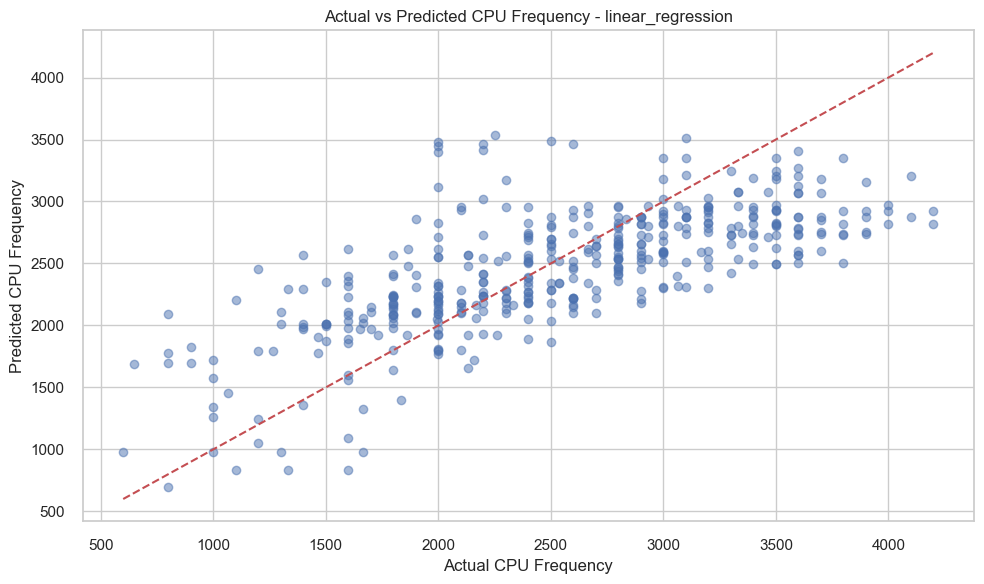

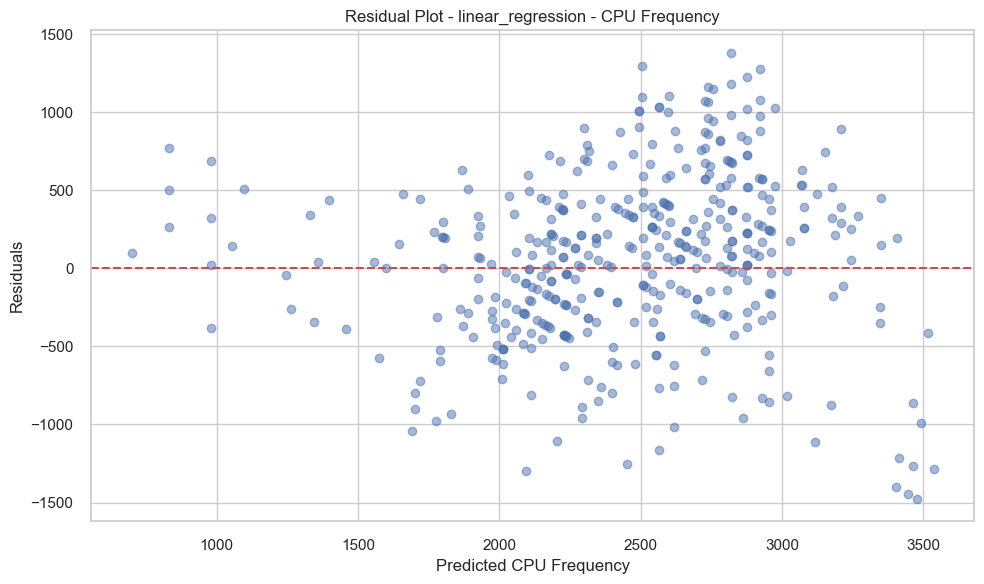

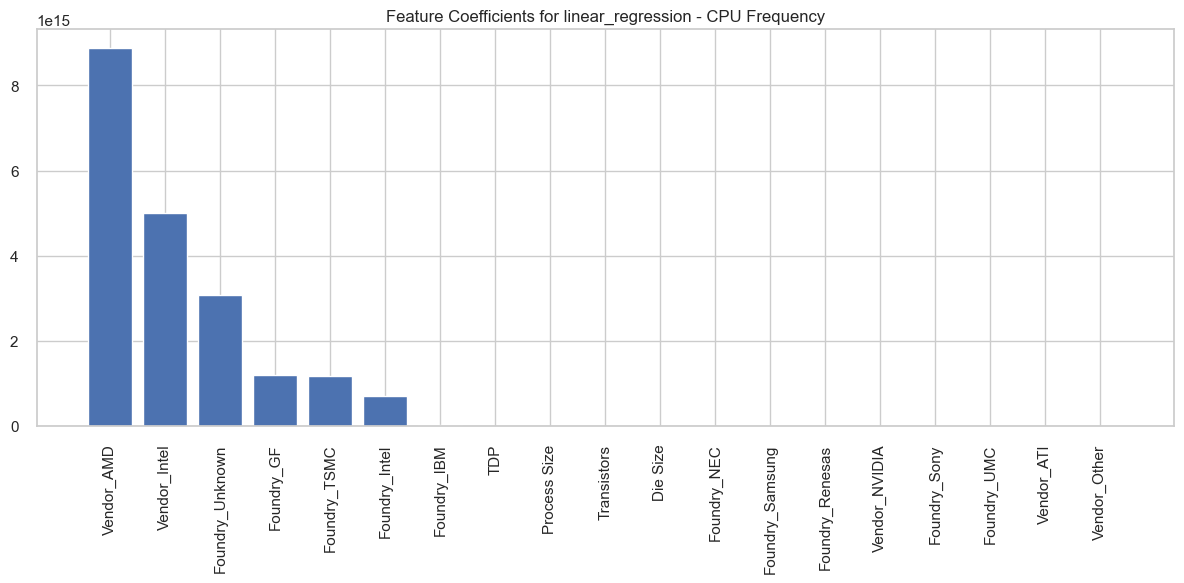




---------------  ridge_regression  ---------------


Training Data Metrics:
Model: ridge_regression
Mean Squared Error (MSE): 310319.9380
Root Mean Squared Error (RMSE): 557.0637
Mean Absolute Error (MAE): 434.5682
R² Score: 0.4455
--------------------------------------------------
Test Data Metrics:
Model: ridge_regression
Mean Squared Error (MSE): 287669.2766
Root Mean Squared Error (RMSE): 536.3481
Mean Absolute Error (MAE): 427.1841
R² Score: 0.4965
--------------------------------------------------


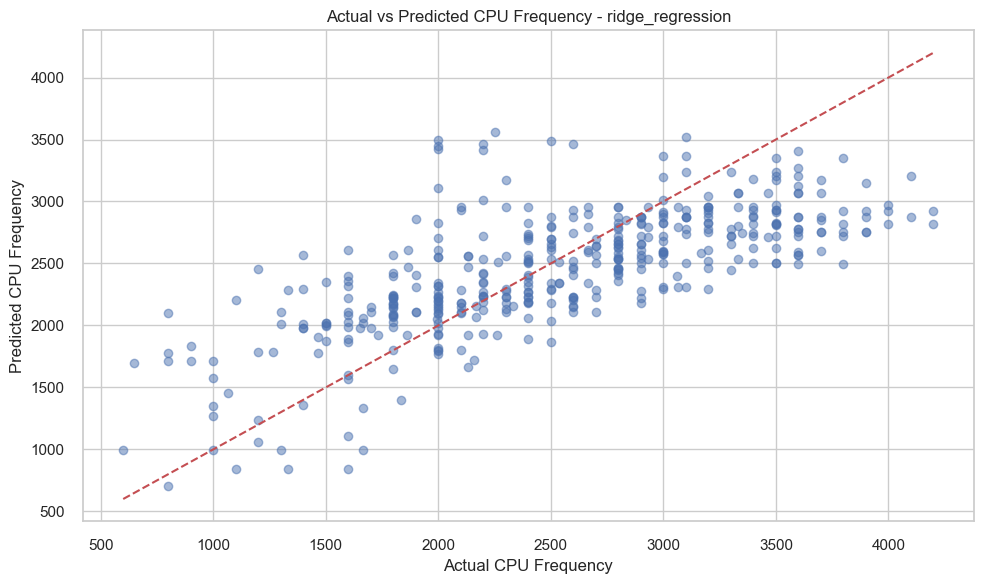

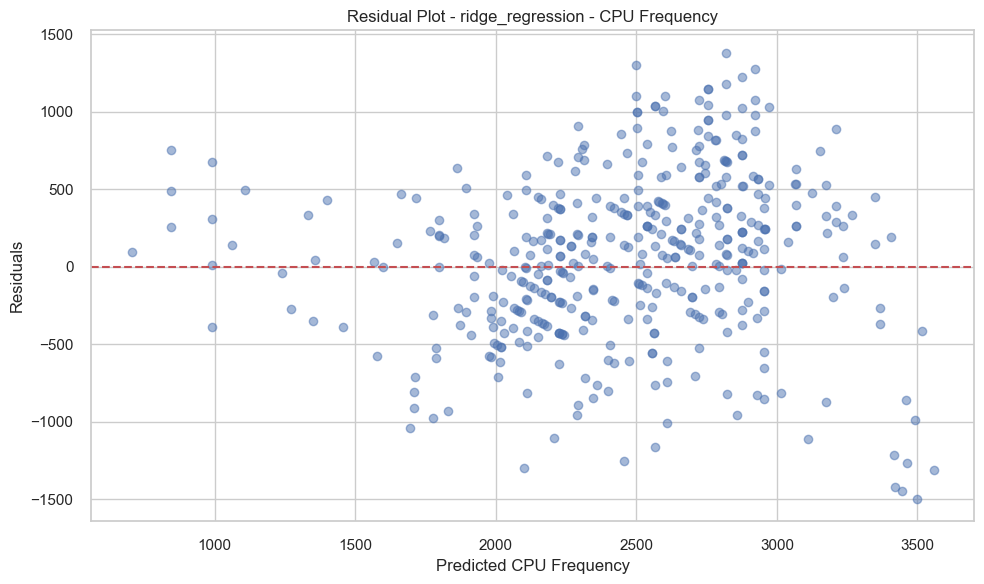

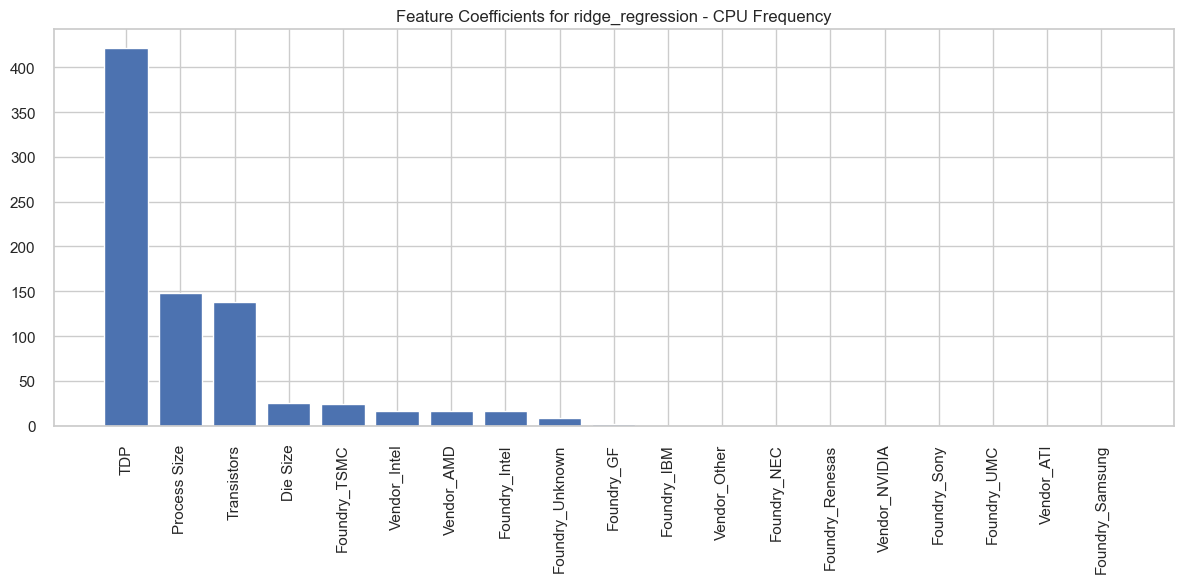




----------------  decision_tree  -----------------


Training Data Metrics:
Model: decision_tree
Mean Squared Error (MSE): 110831.6204
Root Mean Squared Error (RMSE): 332.9138
Mean Absolute Error (MAE): 248.8345
R² Score: 0.8020
--------------------------------------------------
Test Data Metrics:
Model: decision_tree
Mean Squared Error (MSE): 114522.2885
Root Mean Squared Error (RMSE): 338.4114
Mean Absolute Error (MAE): 249.8906
R² Score: 0.7995
--------------------------------------------------


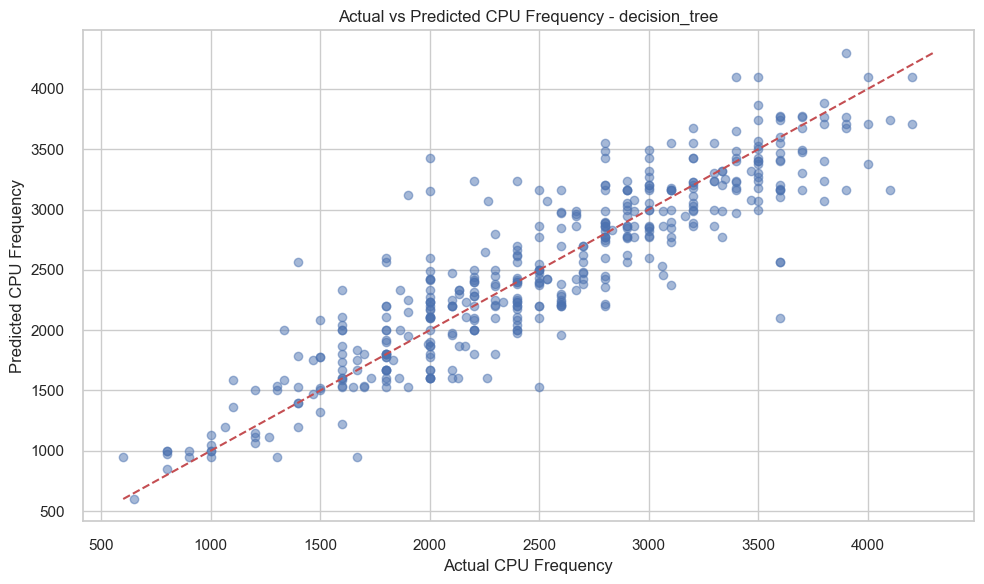

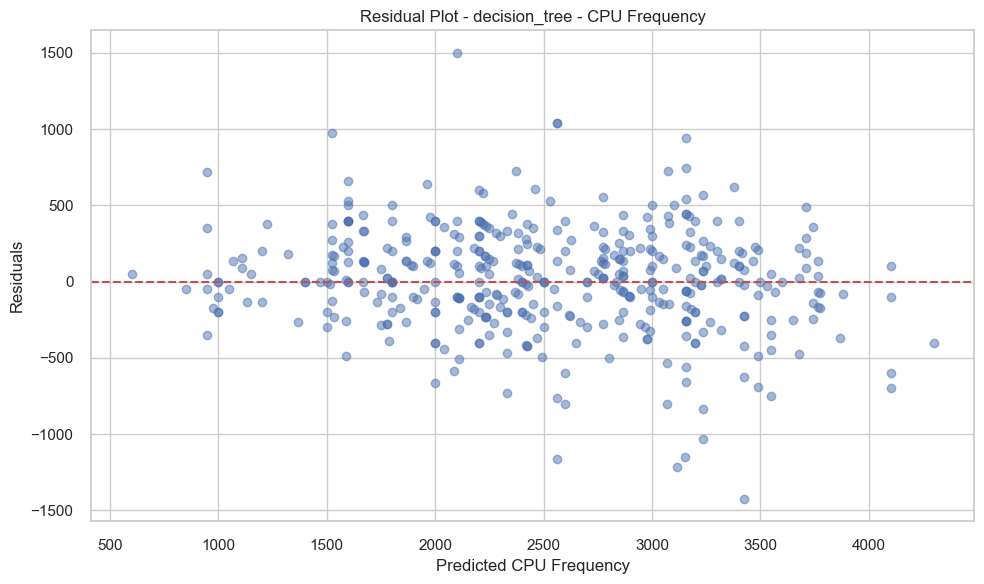

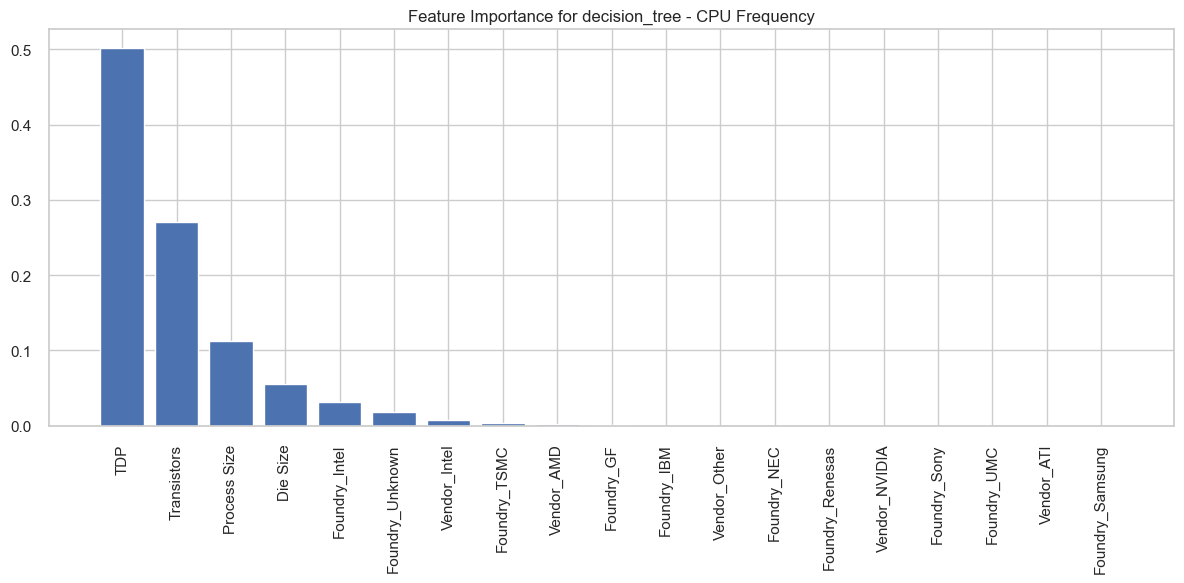




----------------  random_forest  -----------------


Training Data Metrics:
Model: random_forest
Mean Squared Error (MSE): 106537.1117
Root Mean Squared Error (RMSE): 326.4002
Mean Absolute Error (MAE): 245.3783
R² Score: 0.8096
--------------------------------------------------
Test Data Metrics:
Model: random_forest
Mean Squared Error (MSE): 113106.7166
Root Mean Squared Error (RMSE): 336.3134
Mean Absolute Error (MAE): 251.5930
R² Score: 0.8020
--------------------------------------------------


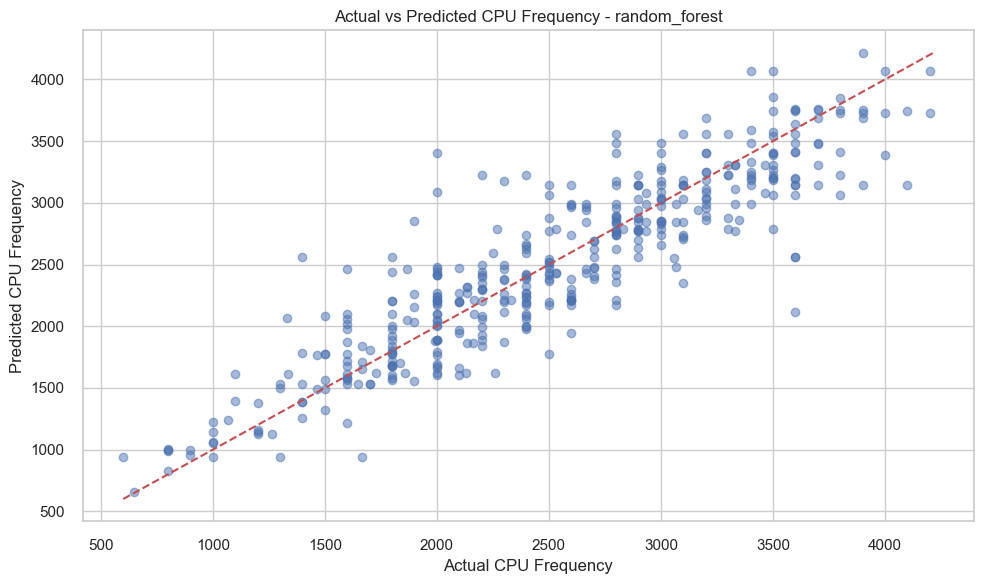

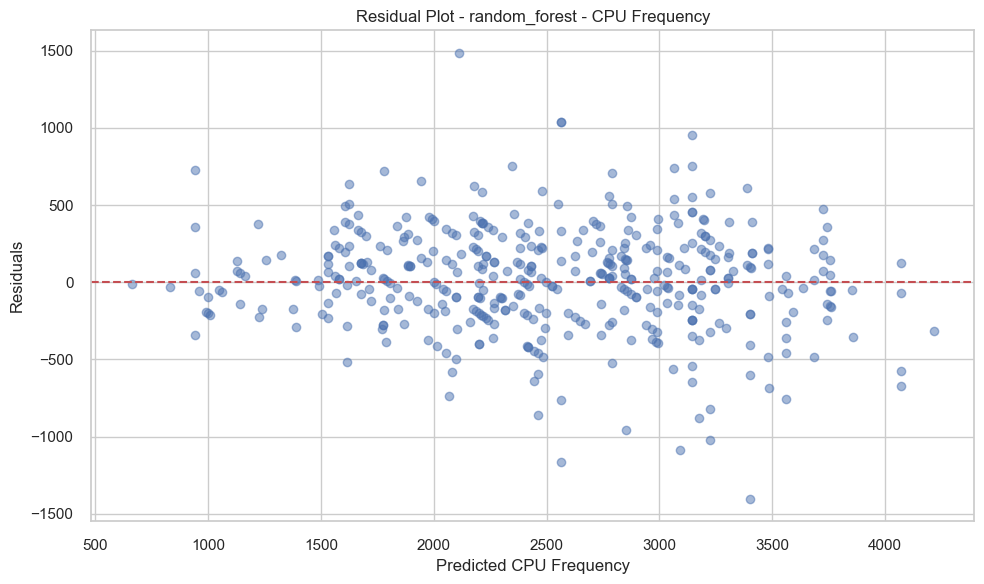

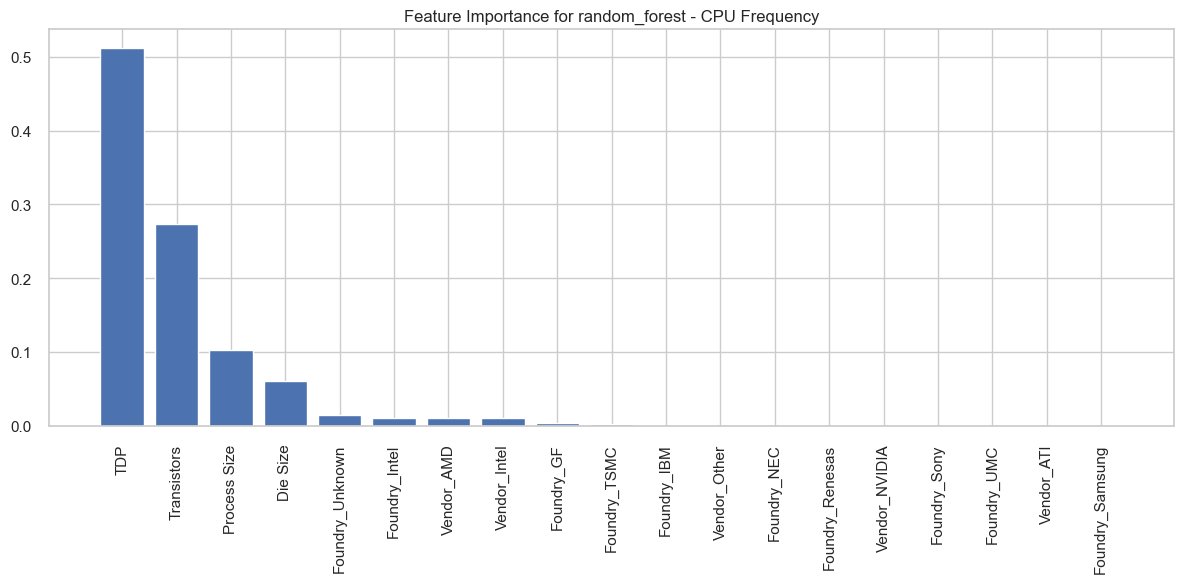




-------------------  xgboost  --------------------


Training Data Metrics:
Model: xgboost
Mean Squared Error (MSE): 105250.4082
Root Mean Squared Error (RMSE): 324.4232
Mean Absolute Error (MAE): 243.5544
R² Score: 0.8119
--------------------------------------------------
Test Data Metrics:
Model: xgboost
Mean Squared Error (MSE): 109555.1718
Root Mean Squared Error (RMSE): 330.9912
Mean Absolute Error (MAE): 246.7134
R² Score: 0.8082
--------------------------------------------------


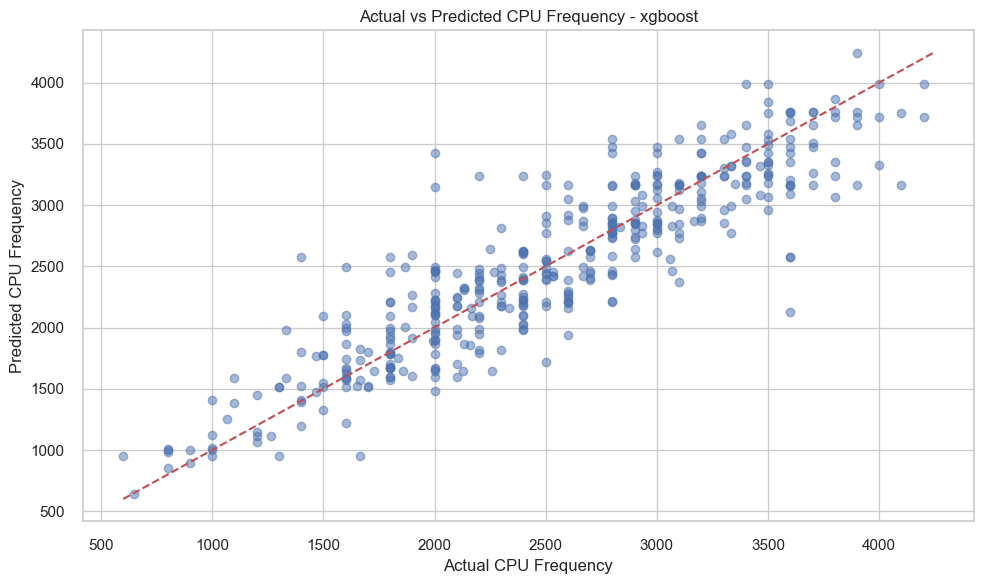

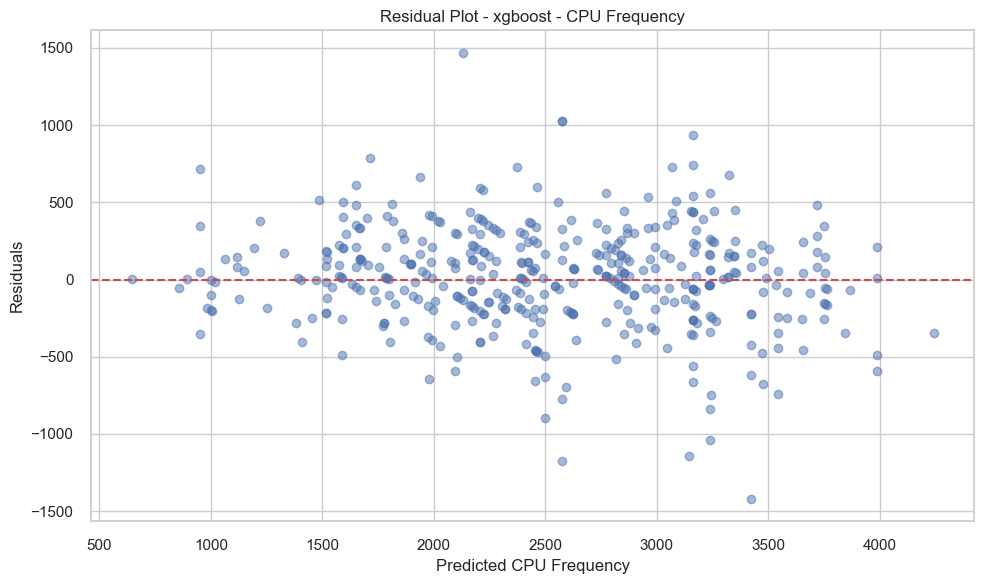

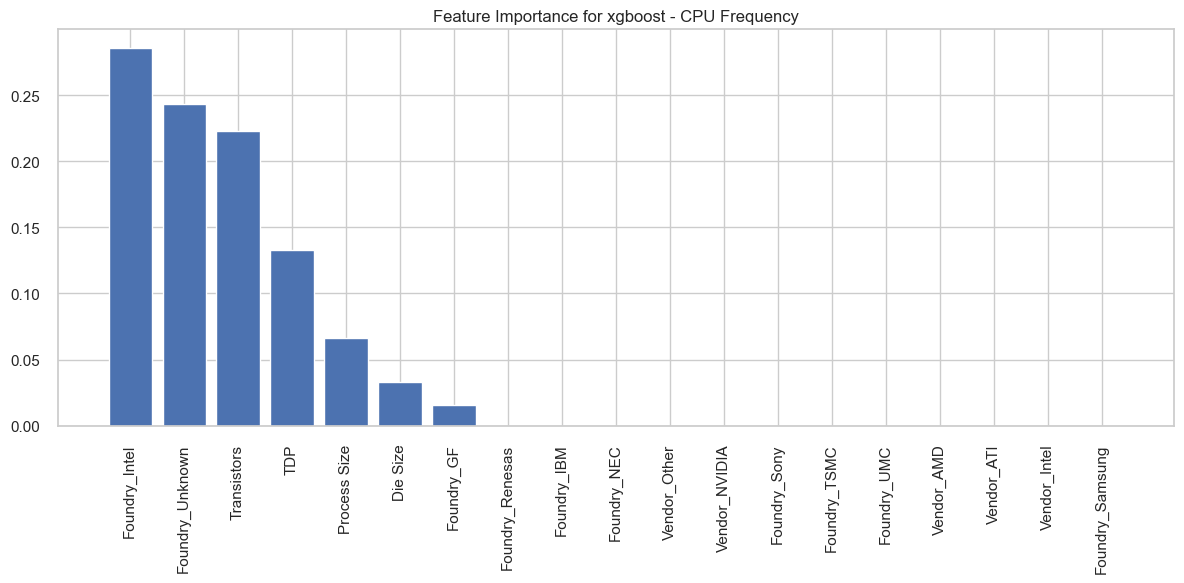




-------------------  lightgbm  -------------------


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 257
[LightGBM] [Info] Number of data points in the train set: 1688, number of used features: 10
[LightGBM] [Info] Start training from score 2472.623223
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 257
[LightGBM] [Info] Number of data points in the train set: 1688, number of used features: 10
[LightGBM] [Info] Start training from score 2472.623223
Training Data Metrics:
Model: lightgbm
Mean Squared Error (MSE): 107997.9048
Root Mean Squared Error (RMSE): 328.6303
Mean Absolut

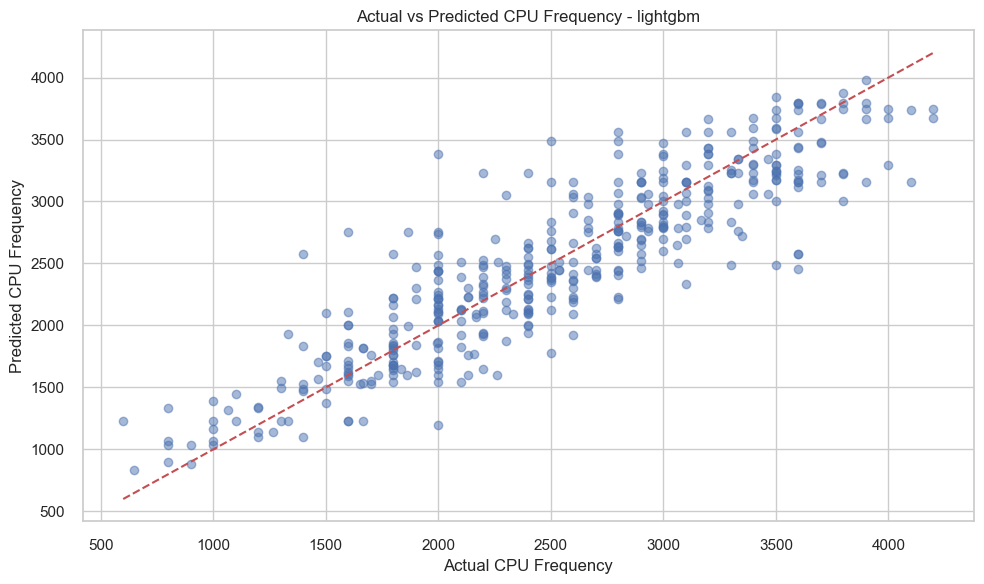

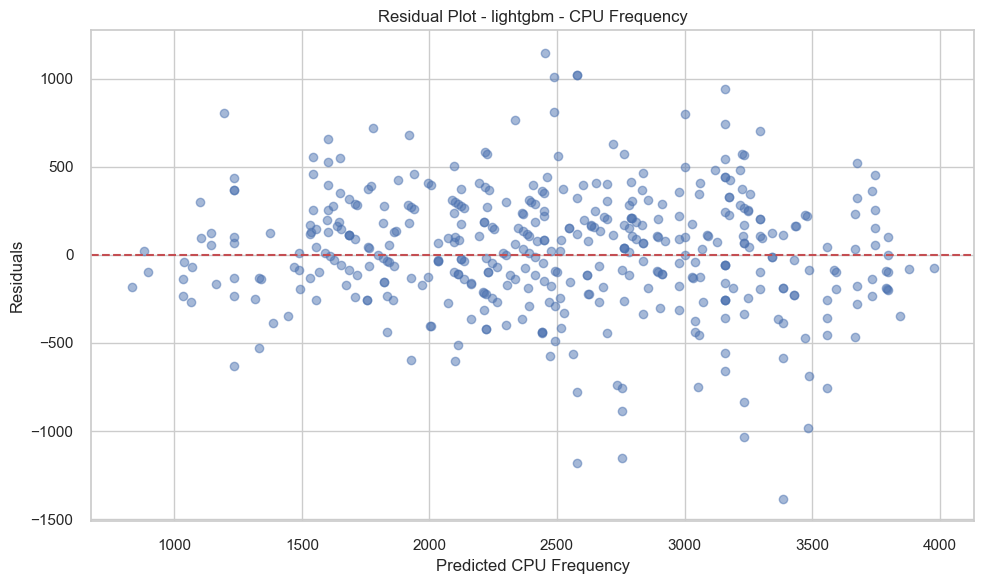

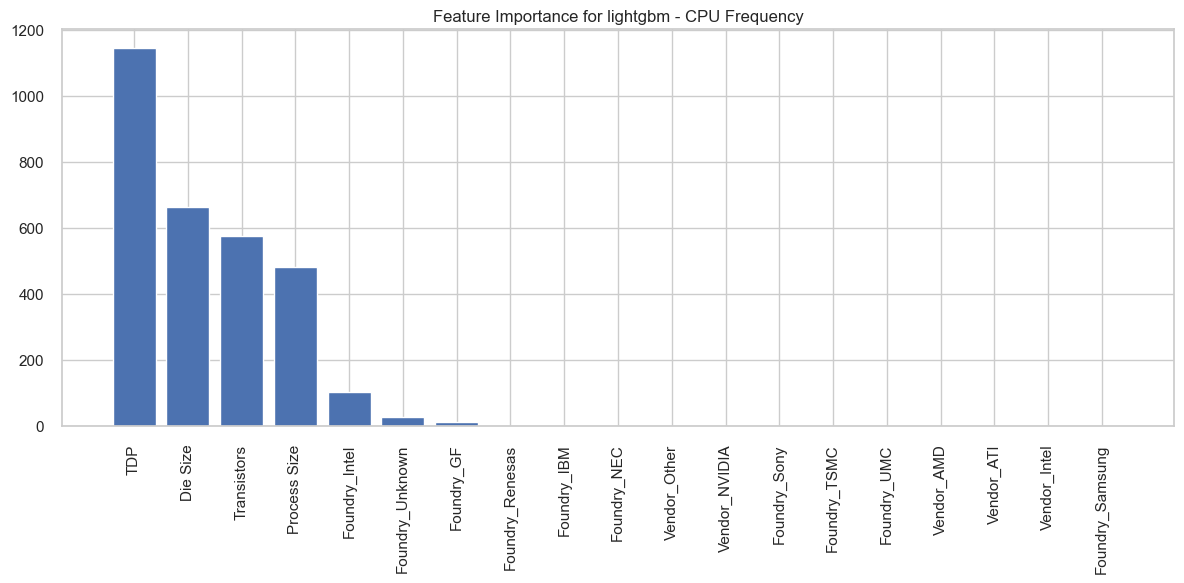




-------------------  catboost  -------------------


Training Data Metrics:
Model: catboost
Mean Squared Error (MSE): 102505.1618
Root Mean Squared Error (RMSE): 320.1643
Mean Absolute Error (MAE): 245.5629
R² Score: 0.8169
--------------------------------------------------
Test Data Metrics:
Model: catboost
Mean Squared Error (MSE): 108917.8907
Root Mean Squared Error (RMSE): 330.0271
Mean Absolute Error (MAE): 249.7207
R² Score: 0.8093
--------------------------------------------------


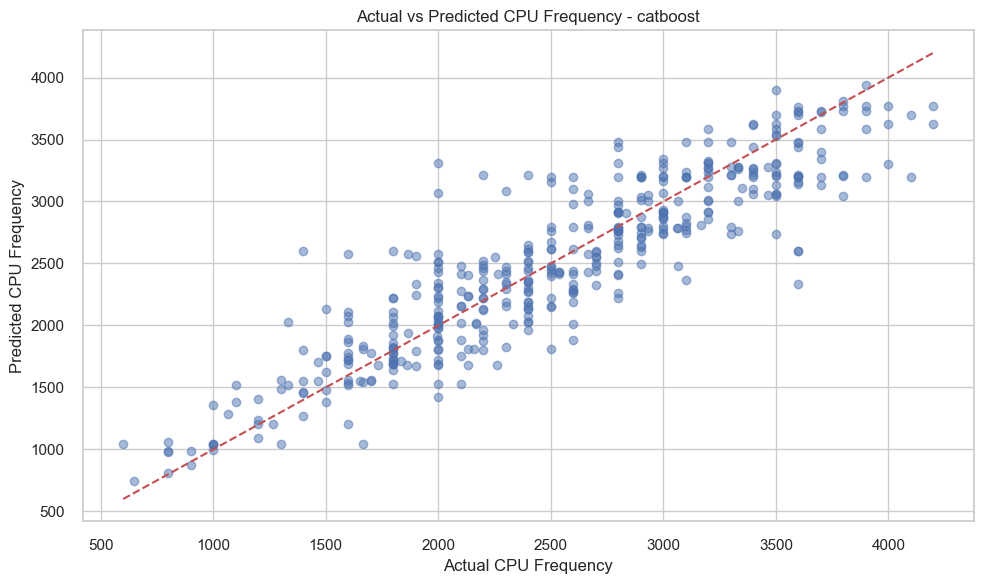

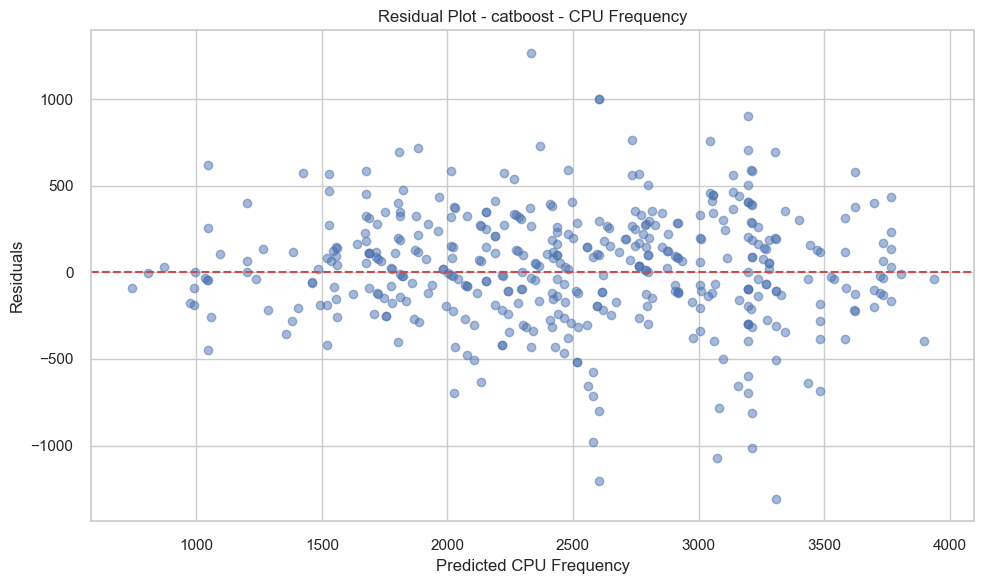

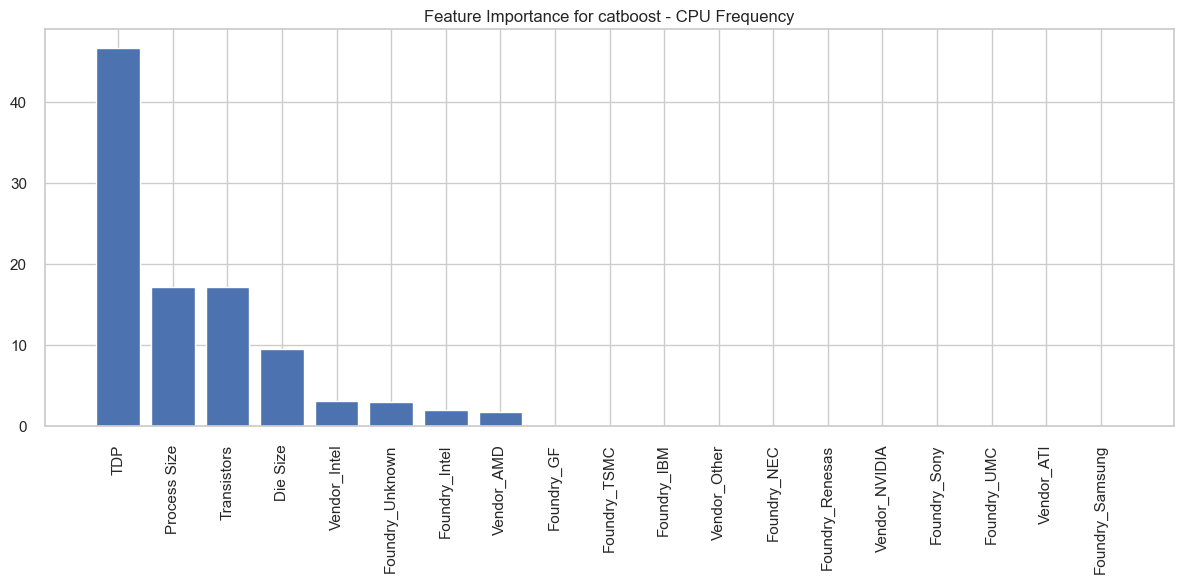




----------------  neural_network  ----------------


Training Data Metrics:
Model: neural_network
Mean Squared Error (MSE): 298651.9683
Root Mean Squared Error (RMSE): 546.4906
Mean Absolute Error (MAE): 427.9223
R² Score: 0.4664
--------------------------------------------------
Test Data Metrics:
Model: neural_network
Mean Squared Error (MSE): 274829.0619
Root Mean Squared Error (RMSE): 524.2414
Mean Absolute Error (MAE): 419.2692
R² Score: 0.5189
--------------------------------------------------


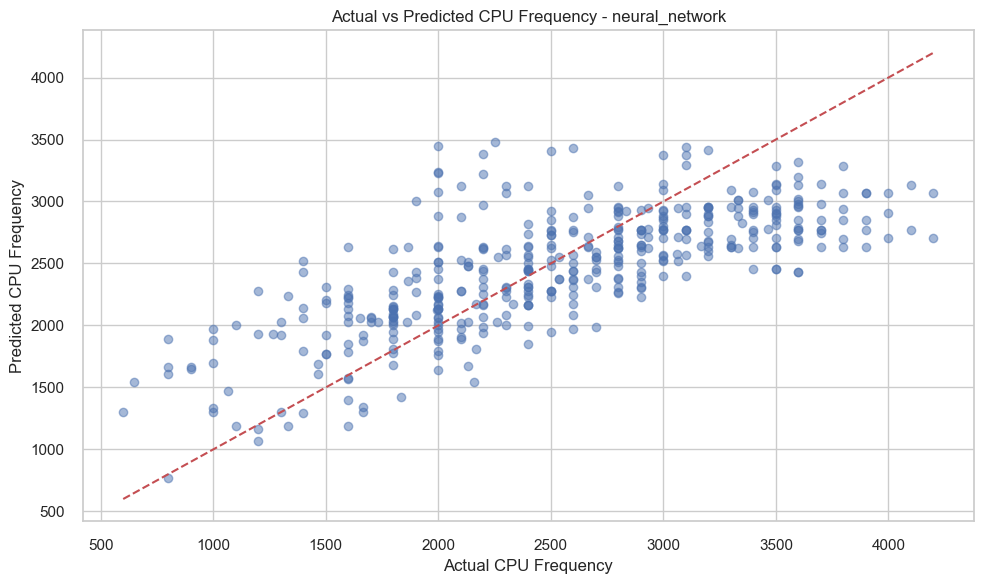

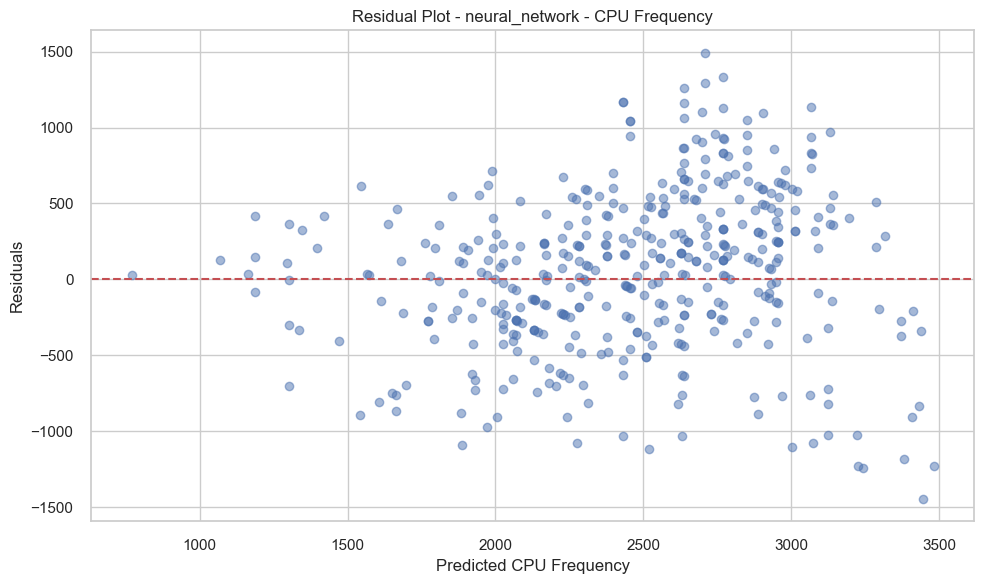

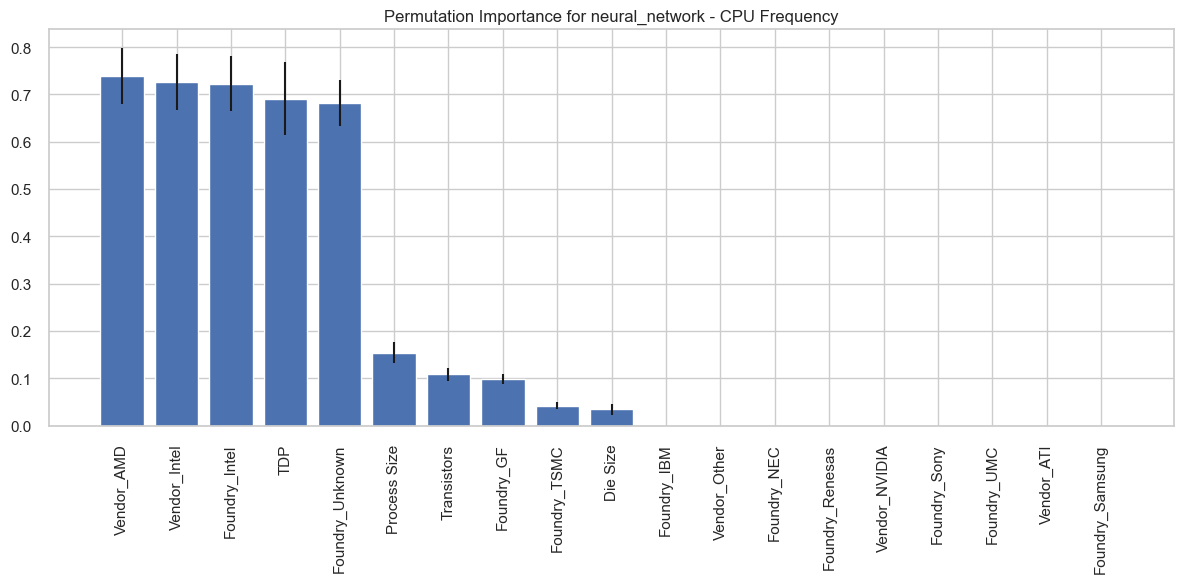




---------------------  svr  ----------------------


Training Data Metrics:
Model: svr
Mean Squared Error (MSE): 507780.7342
Root Mean Squared Error (RMSE): 712.5874
Mean Absolute Error (MAE): 580.6025
R² Score: 0.0927
--------------------------------------------------
Test Data Metrics:
Model: svr
Mean Squared Error (MSE): 512719.6008
Root Mean Squared Error (RMSE): 716.0444
Mean Absolute Error (MAE): 589.6585
R² Score: 0.1025
--------------------------------------------------


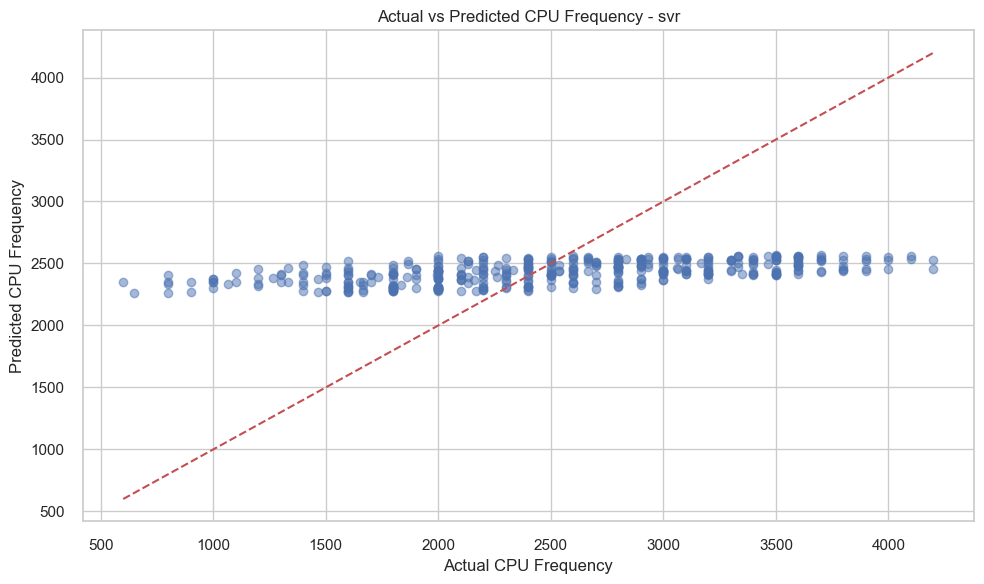

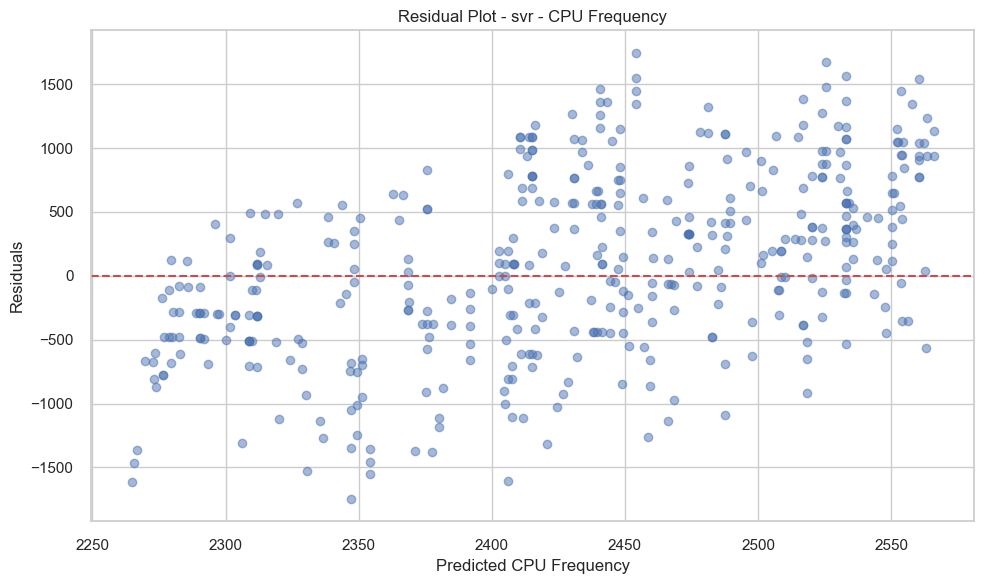

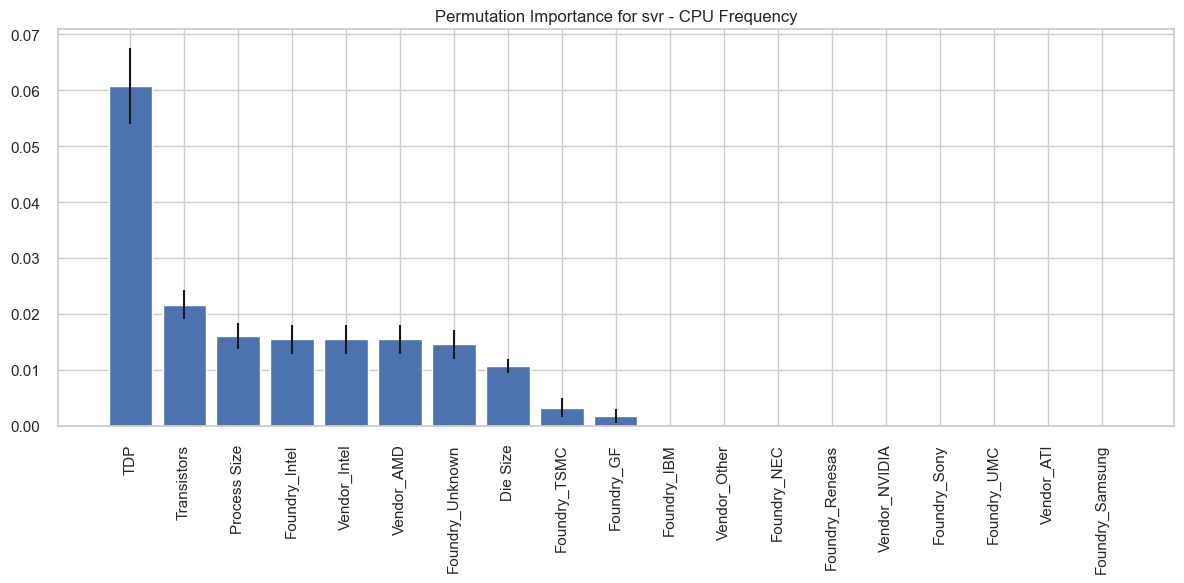


                       GPU FP32 GFLOPS Prediction Models                        




--------------  linear_regression  ---------------


Training Data Metrics:
Model: linear_regression
Mean Squared Error (MSE): 7189433216681244761010118590464.0000
Root Mean Squared Error (RMSE): 2681311846220287.0000
Mean Absolute Error (MAE): 74596091004605.4375
R² Score: -5878385587254786078539776.0000
--------------------------------------------------
Test Data Metrics:
Model: linear_regression
Mean Squared Error (MSE): 394878.1431
Root Mean Squared Error (RMSE): 628.3933
Mean Absolute Error (MAE): 429.5886
R² Score: 0.6128
--------------------------------------------------


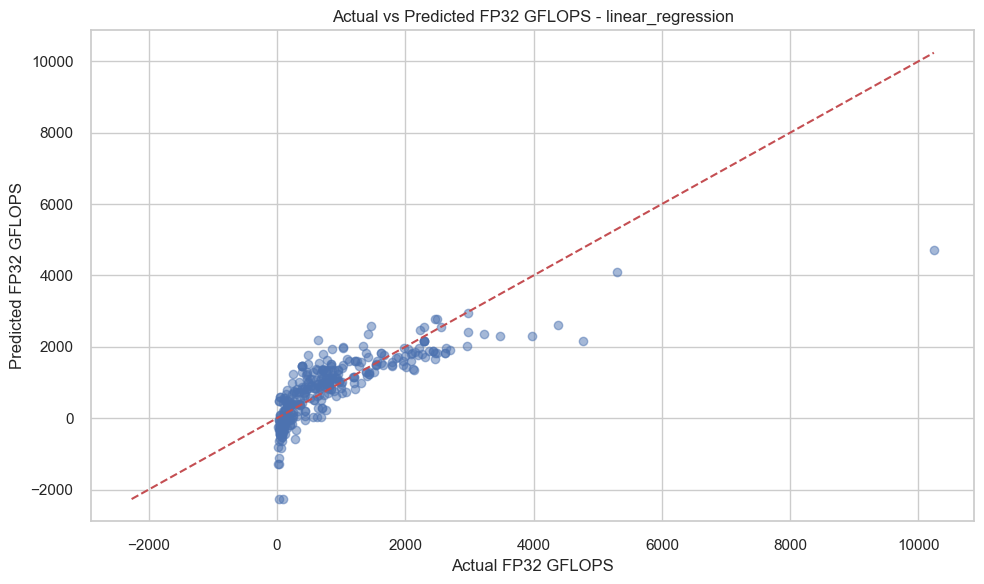

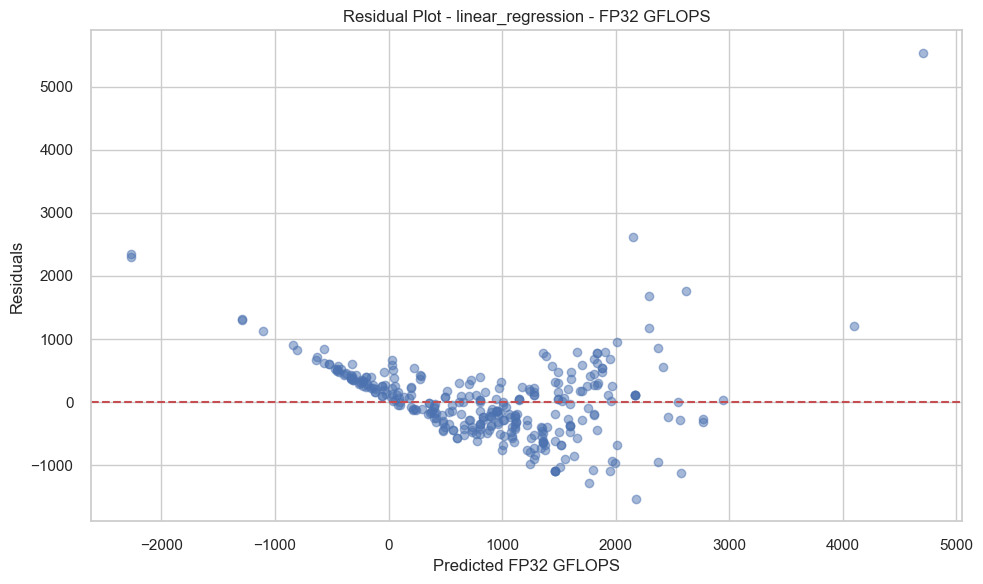

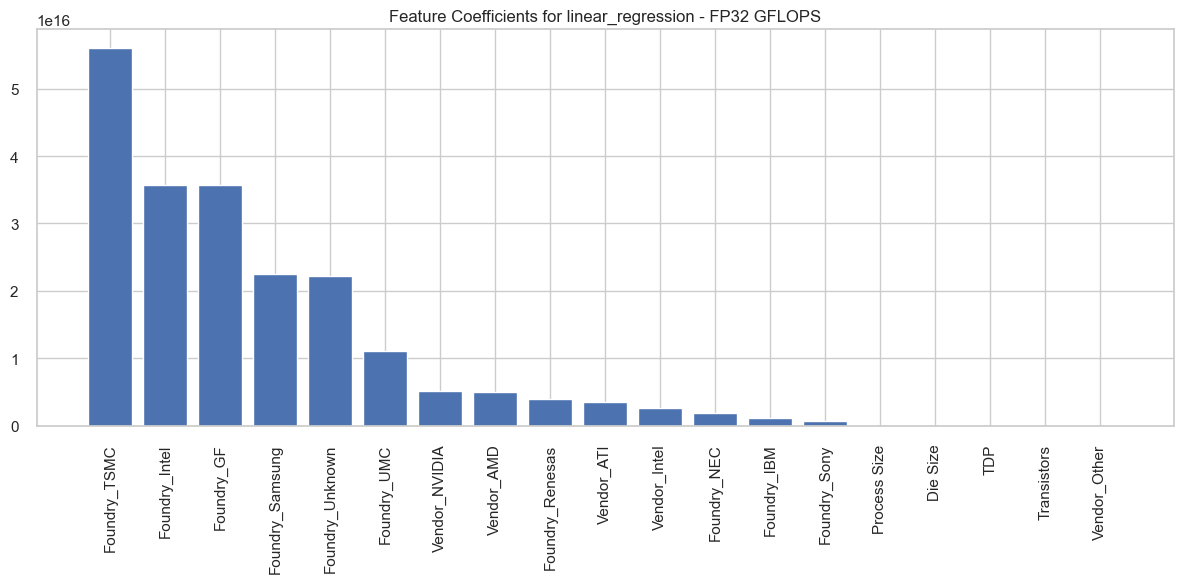




---------------  ridge_regression  ---------------


Training Data Metrics:
Model: ridge_regression
Mean Squared Error (MSE): 456316.8123
Root Mean Squared Error (RMSE): 675.5123
Mean Absolute Error (MAE): 470.0177
R² Score: 0.6269
--------------------------------------------------
Test Data Metrics:
Model: ridge_regression
Mean Squared Error (MSE): 387866.7084
Root Mean Squared Error (RMSE): 622.7895
Mean Absolute Error (MAE): 422.1845
R² Score: 0.6197
--------------------------------------------------


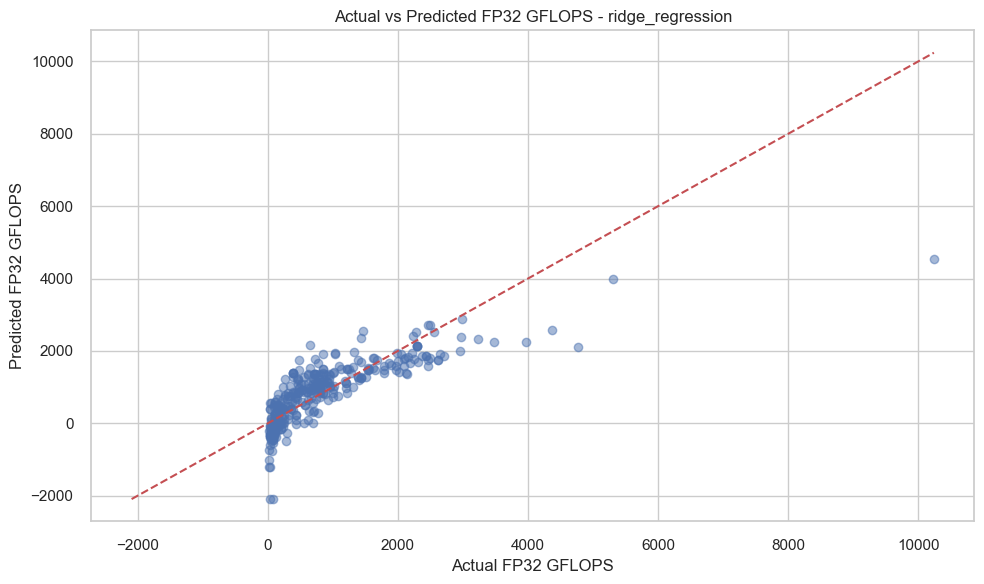

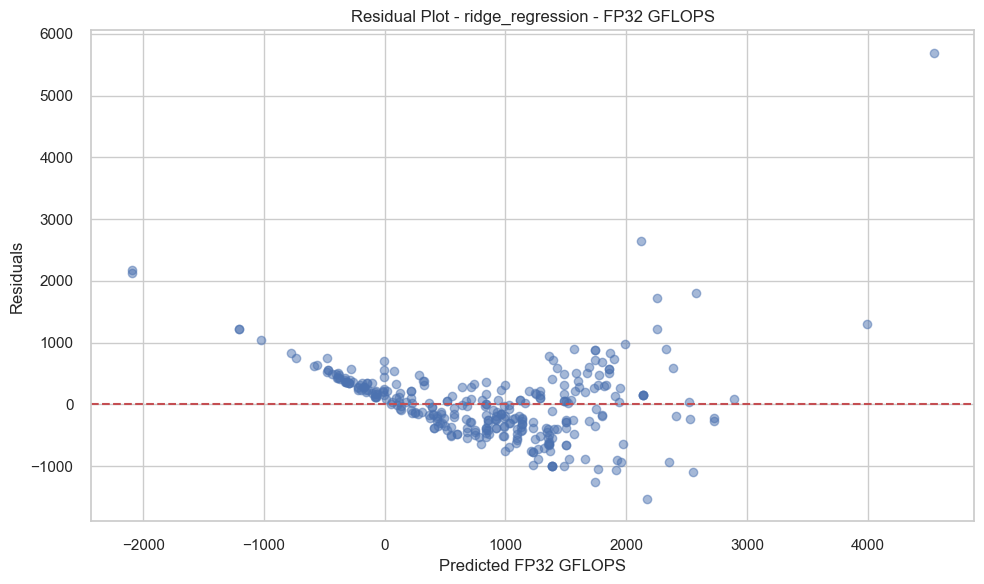

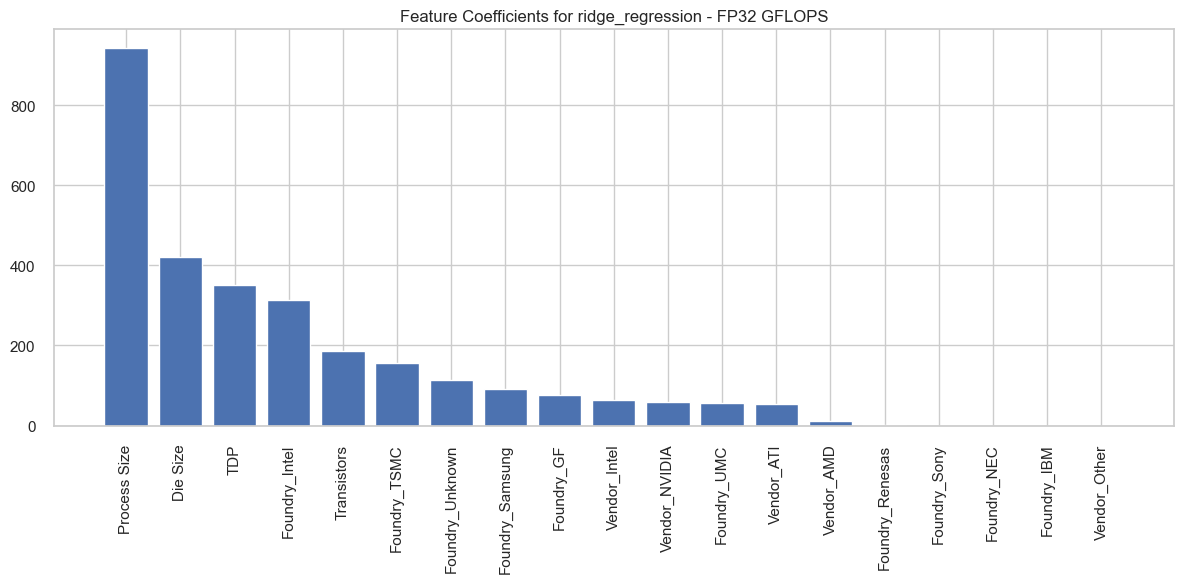




----------------  decision_tree  -----------------


Training Data Metrics:
Model: decision_tree
Mean Squared Error (MSE): 108743.8740
Root Mean Squared Error (RMSE): 329.7634
Mean Absolute Error (MAE): 156.2666
R² Score: 0.9111
--------------------------------------------------
Test Data Metrics:
Model: decision_tree
Mean Squared Error (MSE): 99705.8819
Root Mean Squared Error (RMSE): 315.7624
Mean Absolute Error (MAE): 163.3151
R² Score: 0.9022
--------------------------------------------------


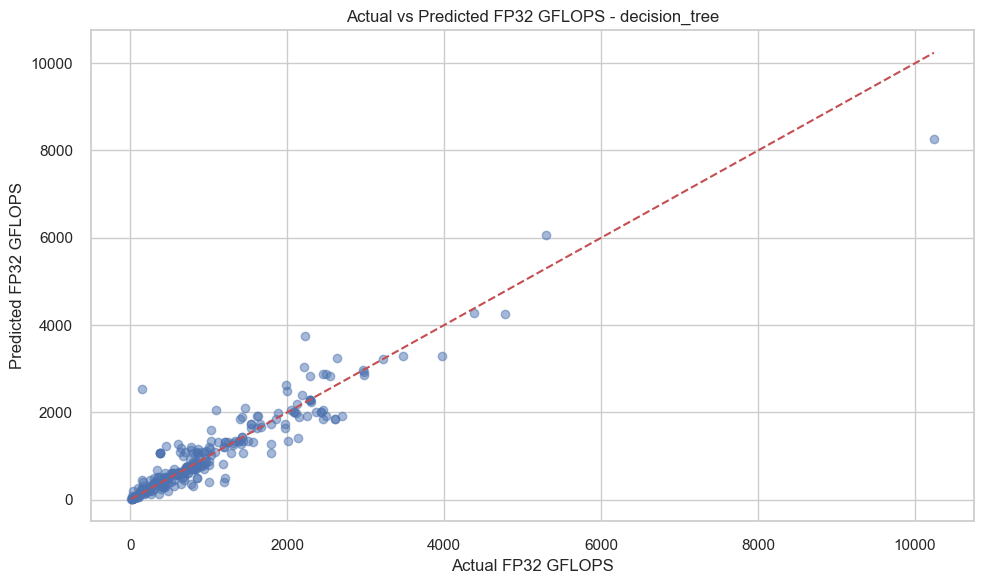

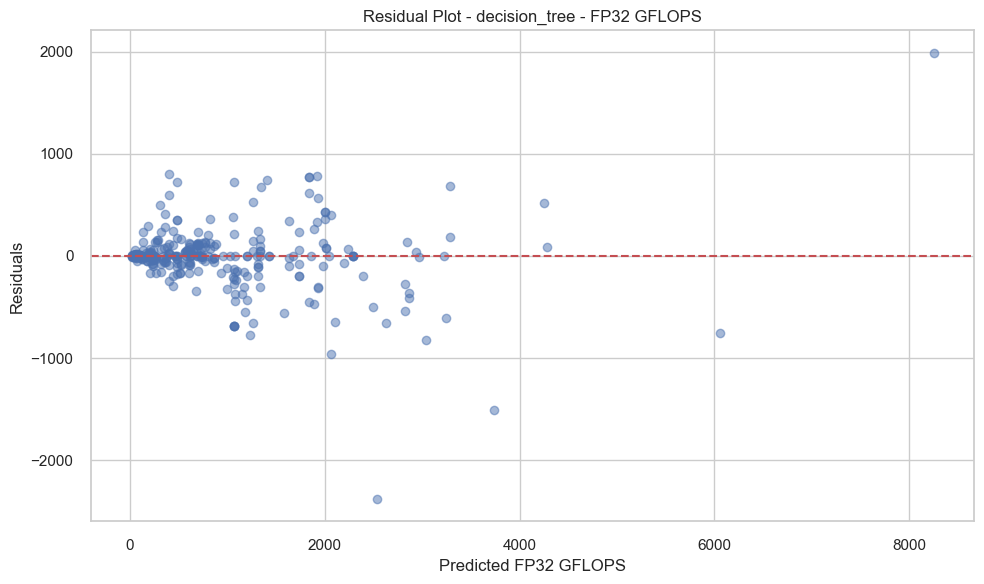

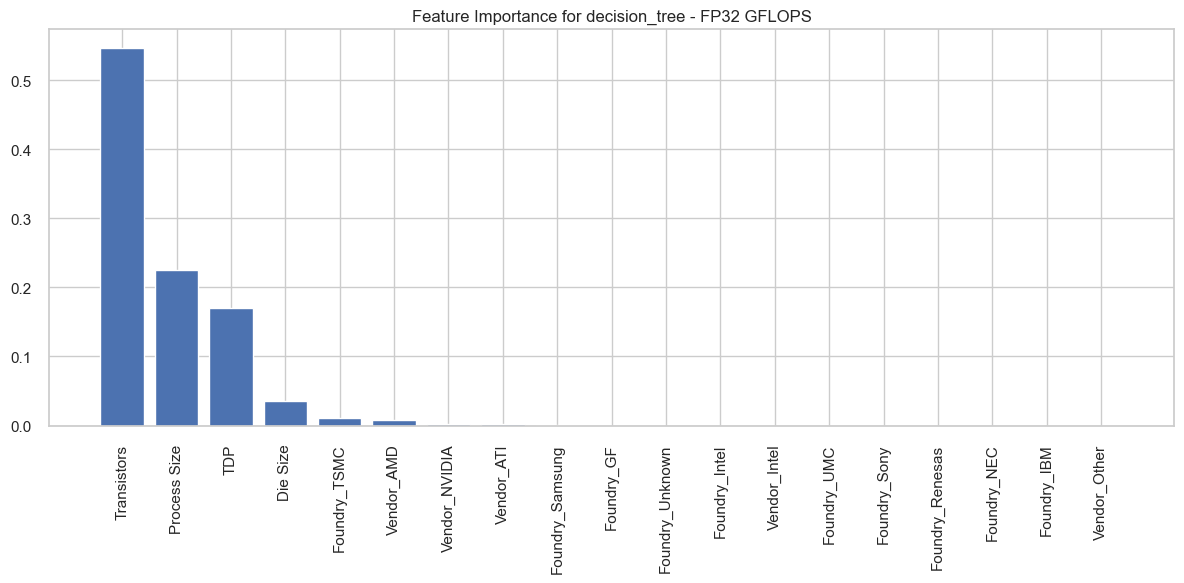




----------------  random_forest  -----------------


Training Data Metrics:
Model: random_forest
Mean Squared Error (MSE): 99758.9838
Root Mean Squared Error (RMSE): 315.8465
Mean Absolute Error (MAE): 154.2697
R² Score: 0.9184
--------------------------------------------------
Test Data Metrics:
Model: random_forest
Mean Squared Error (MSE): 73986.6358
Root Mean Squared Error (RMSE): 272.0048
Mean Absolute Error (MAE): 150.7497
R² Score: 0.9275
--------------------------------------------------


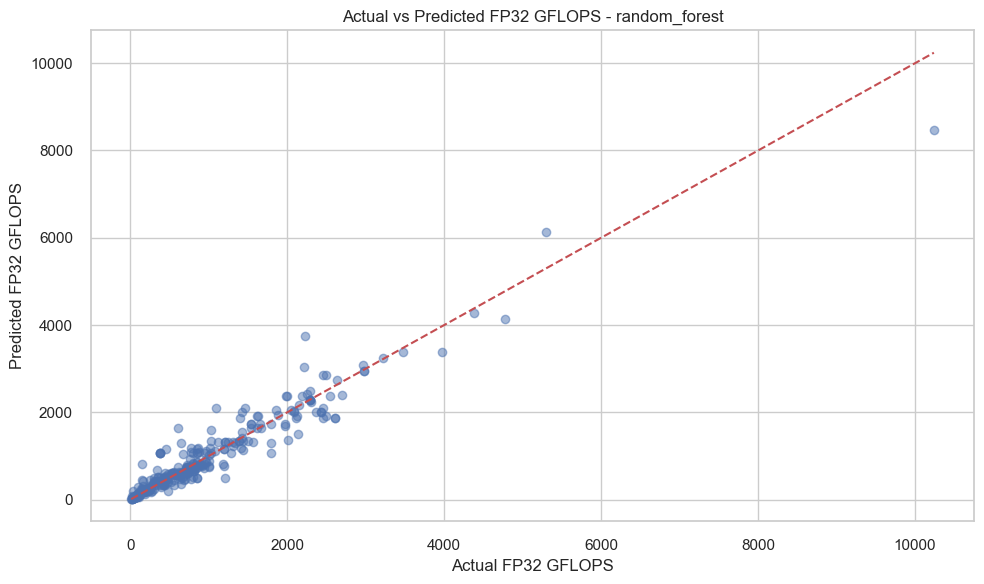

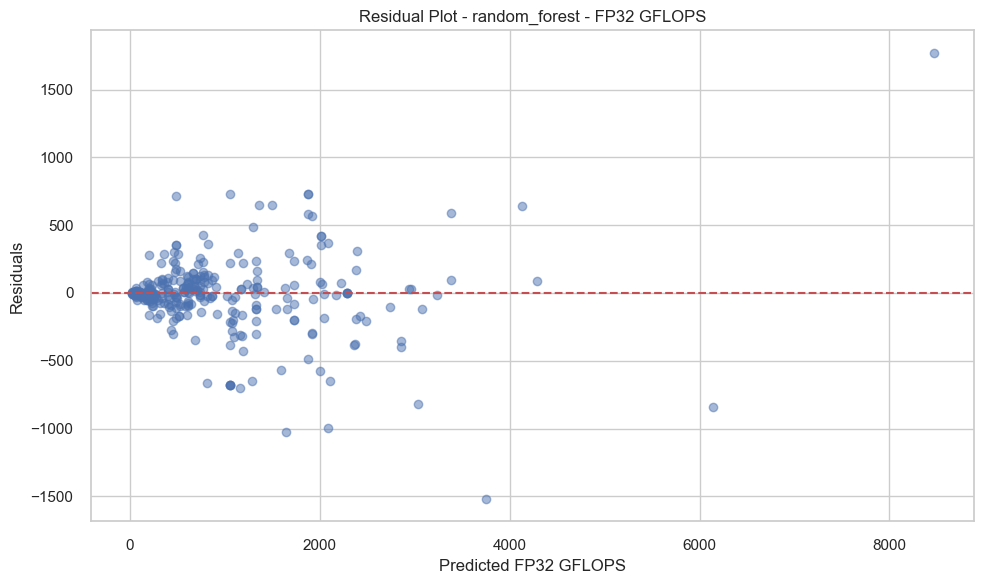

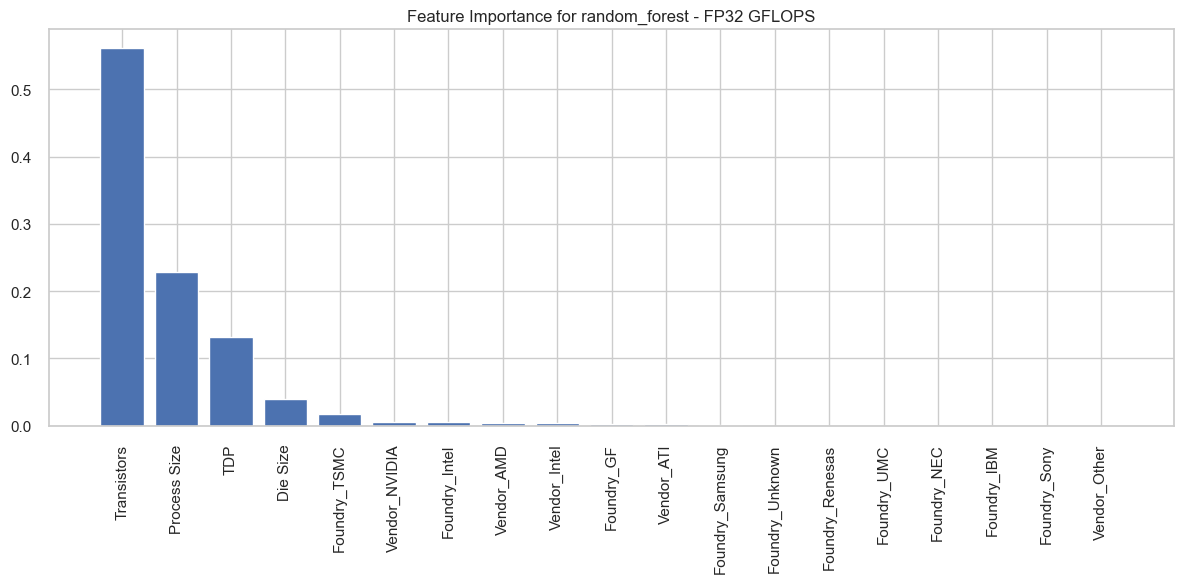




-------------------  xgboost  --------------------


Training Data Metrics:
Model: xgboost
Mean Squared Error (MSE): 90800.8704
Root Mean Squared Error (RMSE): 301.3318
Mean Absolute Error (MAE): 148.8761
R² Score: 0.9258
--------------------------------------------------
Test Data Metrics:
Model: xgboost
Mean Squared Error (MSE): 84765.4668
Root Mean Squared Error (RMSE): 291.1451
Mean Absolute Error (MAE): 156.3553
R² Score: 0.9169
--------------------------------------------------


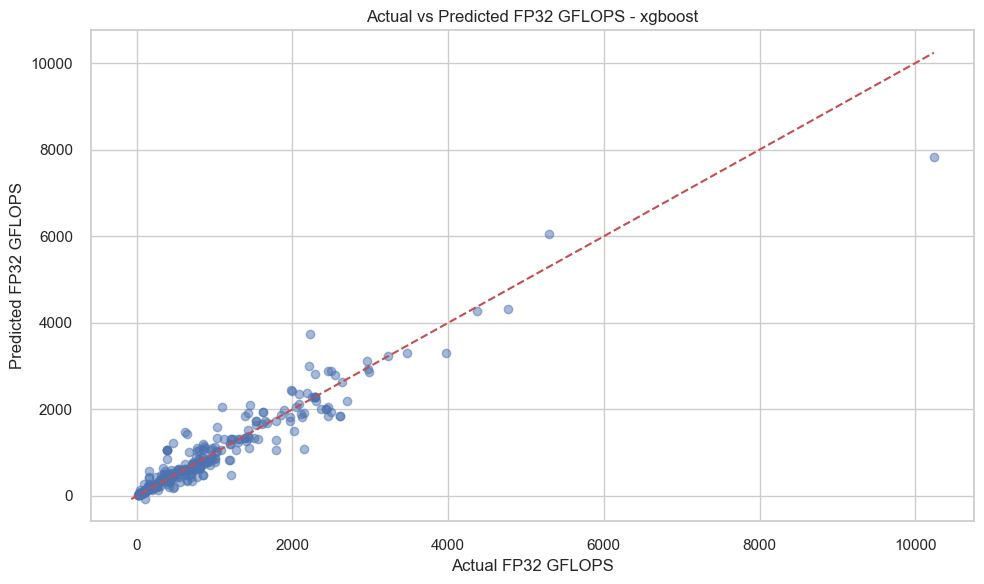

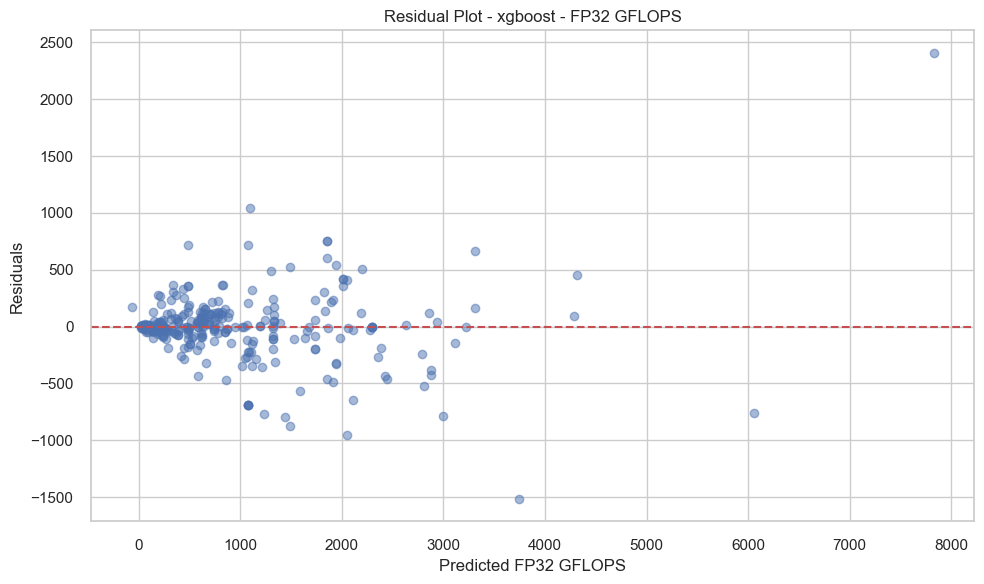

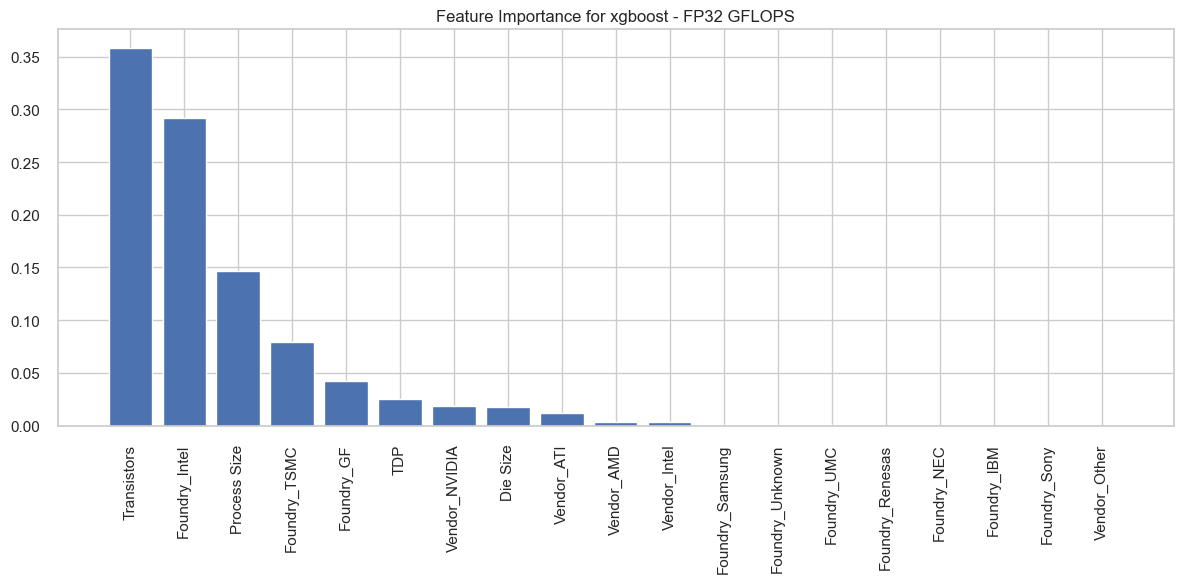




-------------------  lightgbm  -------------------


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 267
[LightGBM] [Info] Number of data points in the train set: 1292, number of used features: 13
[LightGBM] [Info] Start training from score 902.180929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 267
[LightGBM] [Info] Number of data points in the train set: 1292, number of used features: 13
[LightGBM] [Info] Start training from score 902.180929
Training Data Metrics:
Model: lightgbm
Mean Squared Error (MSE): 136966.0930
Root Mean Squared Error (RMSE): 370.0893
Mean Absolute 

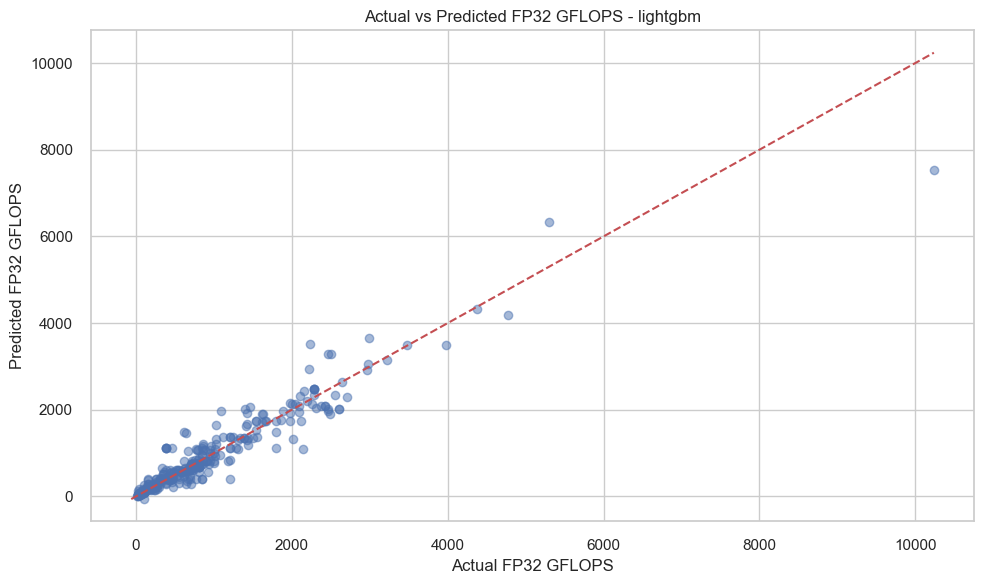

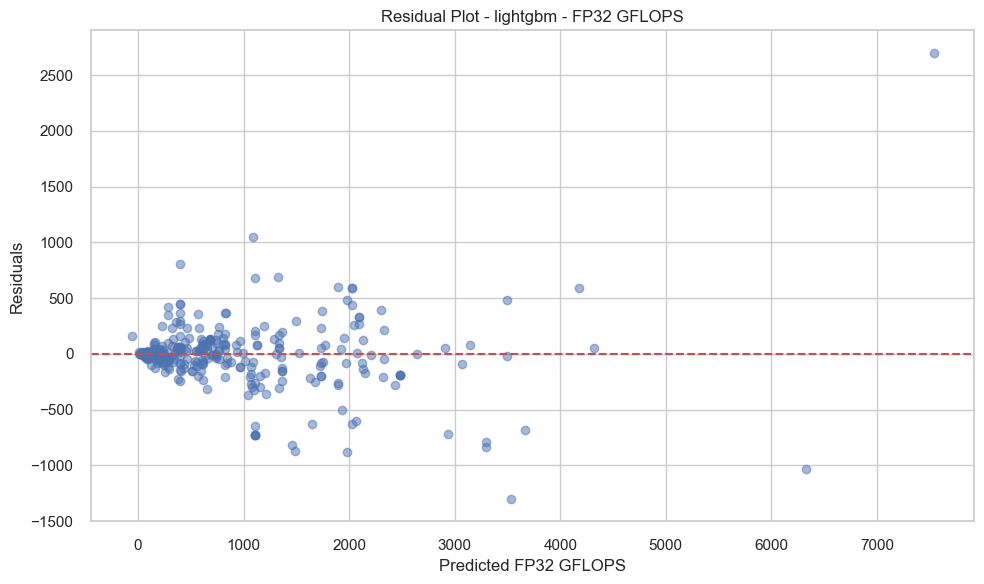

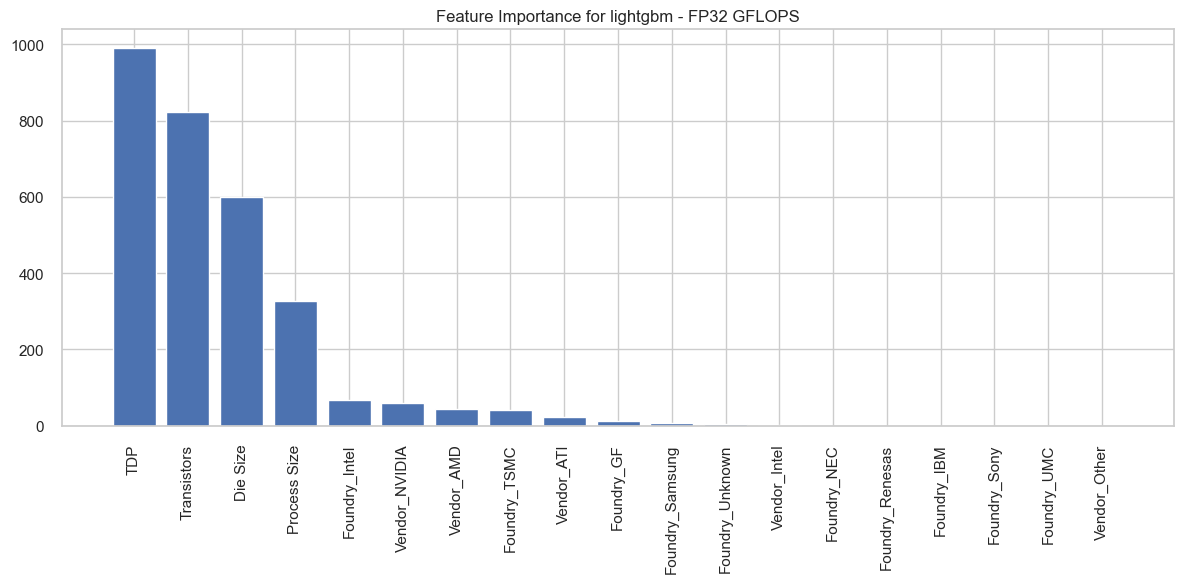




-------------------  catboost  -------------------


Training Data Metrics:
Model: catboost
Mean Squared Error (MSE): 104007.9737
Root Mean Squared Error (RMSE): 322.5027
Mean Absolute Error (MAE): 162.0192
R² Score: 0.9150
--------------------------------------------------
Test Data Metrics:
Model: catboost
Mean Squared Error (MSE): 71159.8170
Root Mean Squared Error (RMSE): 266.7580
Mean Absolute Error (MAE): 157.0996
R² Score: 0.9302
--------------------------------------------------


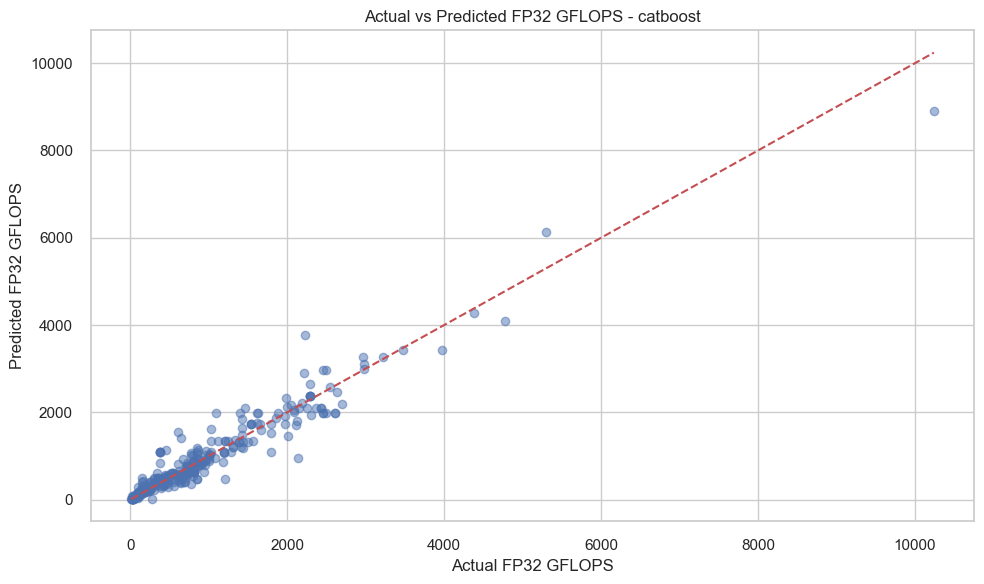

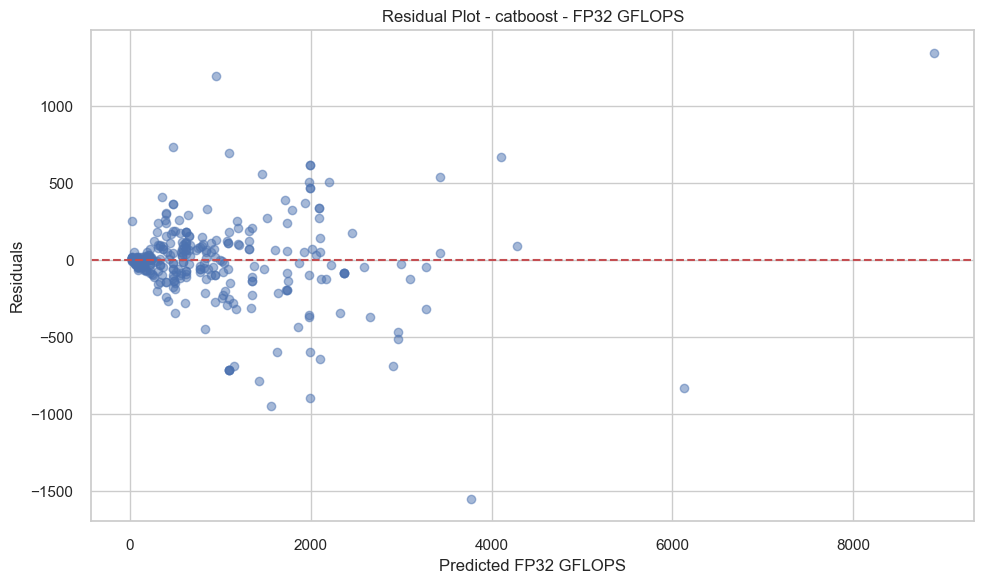

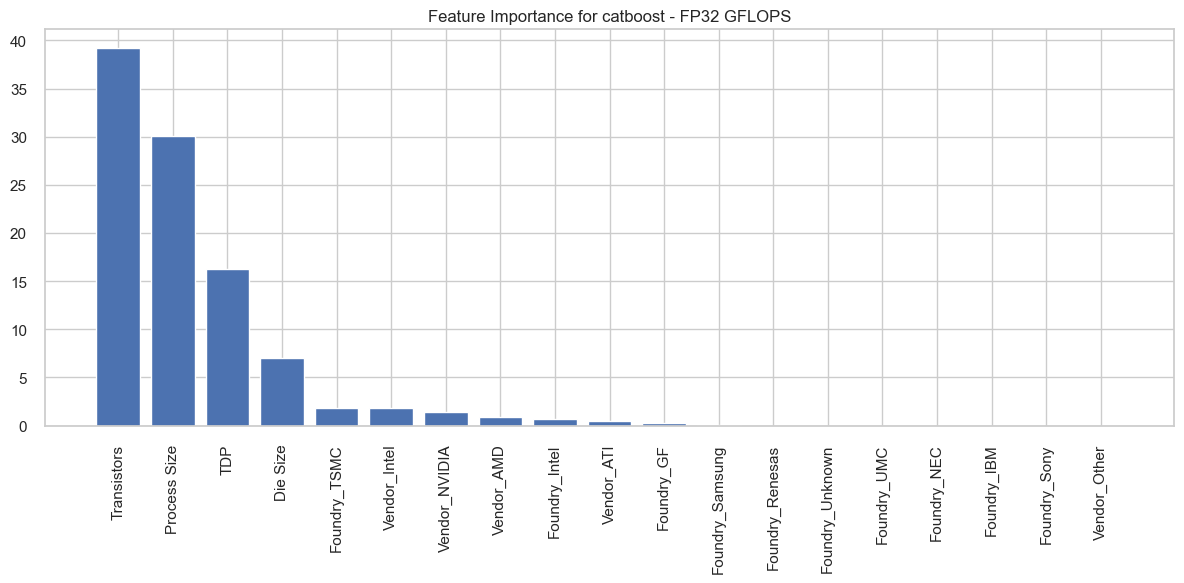




----------------  neural_network  ----------------


Training Data Metrics:
Model: neural_network
Mean Squared Error (MSE): 257211.7369
Root Mean Squared Error (RMSE): 507.1605
Mean Absolute Error (MAE): 307.2292
R² Score: 0.7897
--------------------------------------------------
Test Data Metrics:
Model: neural_network
Mean Squared Error (MSE): 210274.7397
Root Mean Squared Error (RMSE): 458.5572
Mean Absolute Error (MAE): 277.1085
R² Score: 0.7938
--------------------------------------------------


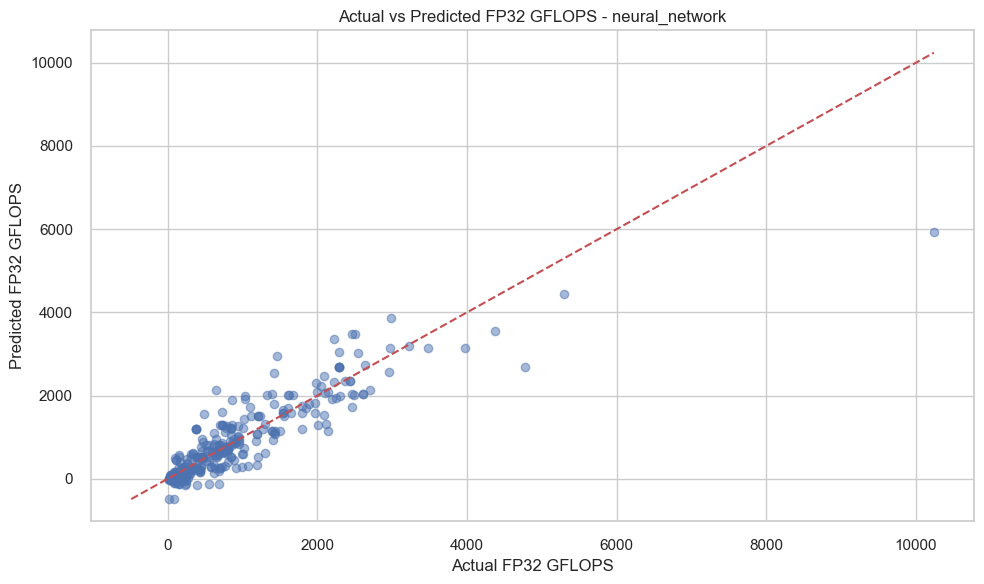

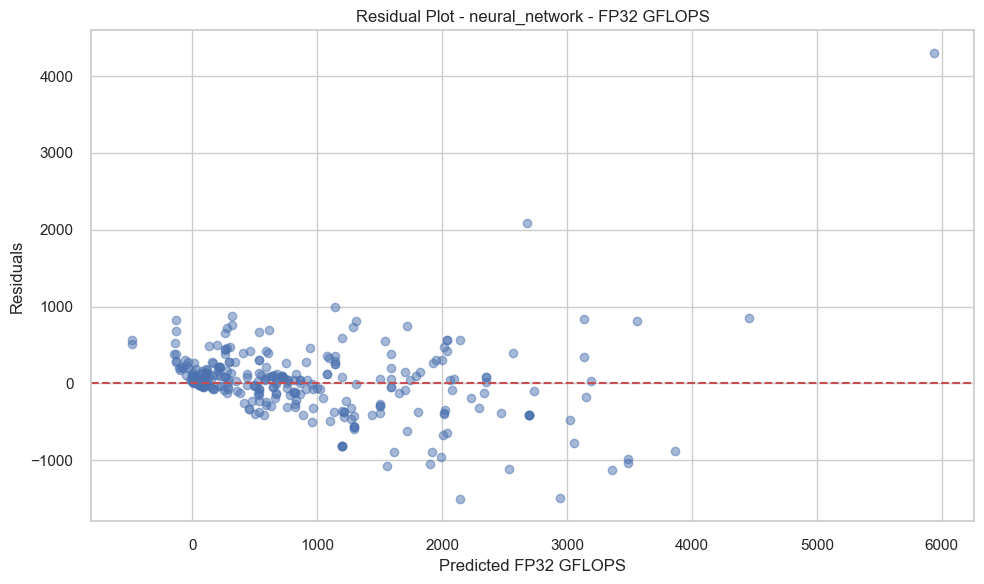

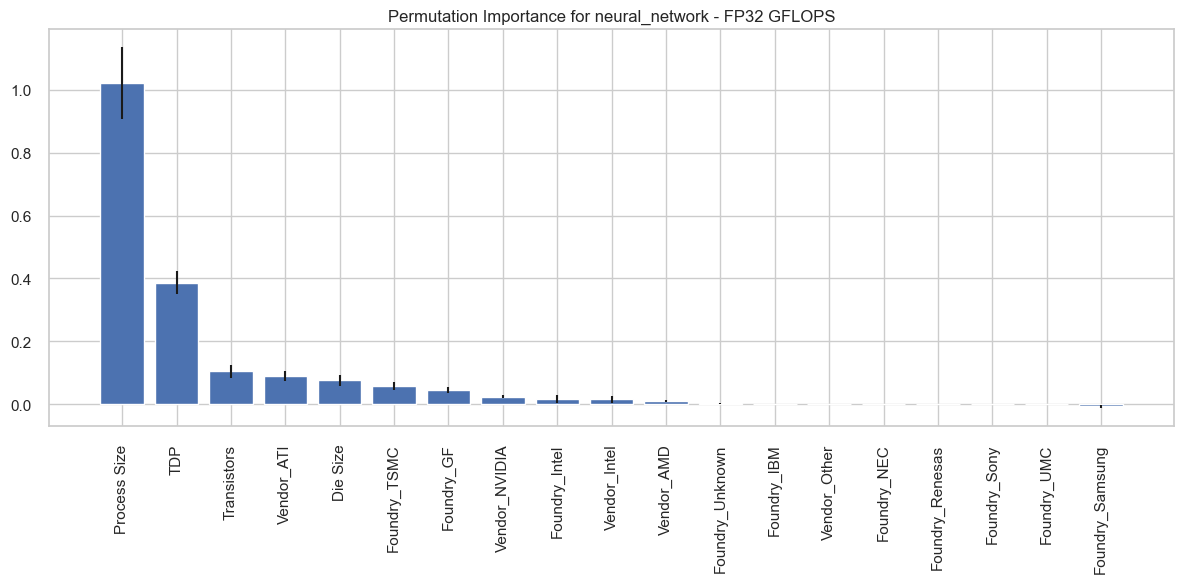




---------------------  svr  ----------------------


Training Data Metrics:
Model: svr
Mean Squared Error (MSE): 1283942.4232
Root Mean Squared Error (RMSE): 1133.1118
Mean Absolute Error (MAE): 634.8578
R² Score: -0.0498
--------------------------------------------------
Test Data Metrics:
Model: svr
Mean Squared Error (MSE): 1040130.3462
Root Mean Squared Error (RMSE): 1019.8678
Mean Absolute Error (MAE): 588.9092
R² Score: -0.0198
--------------------------------------------------


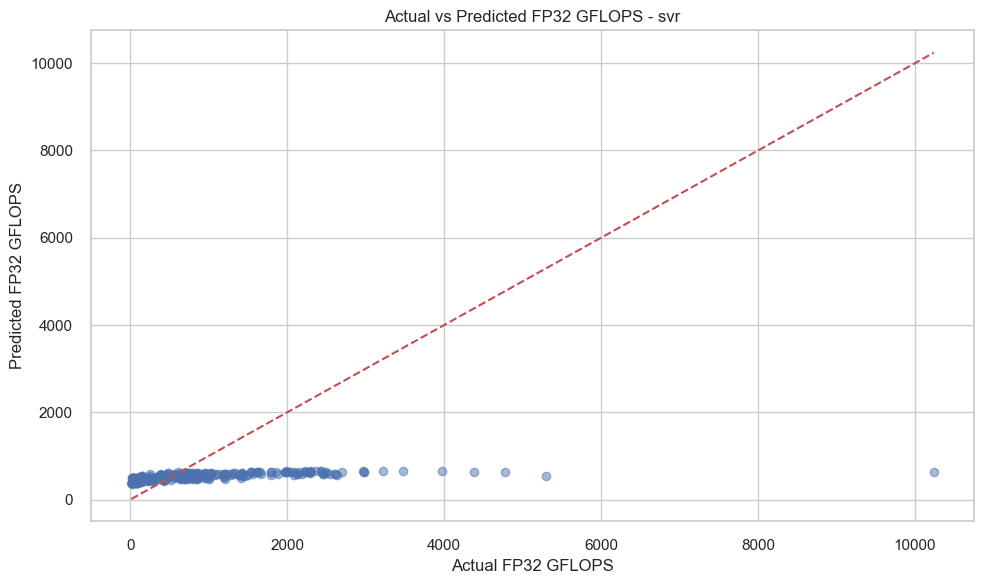

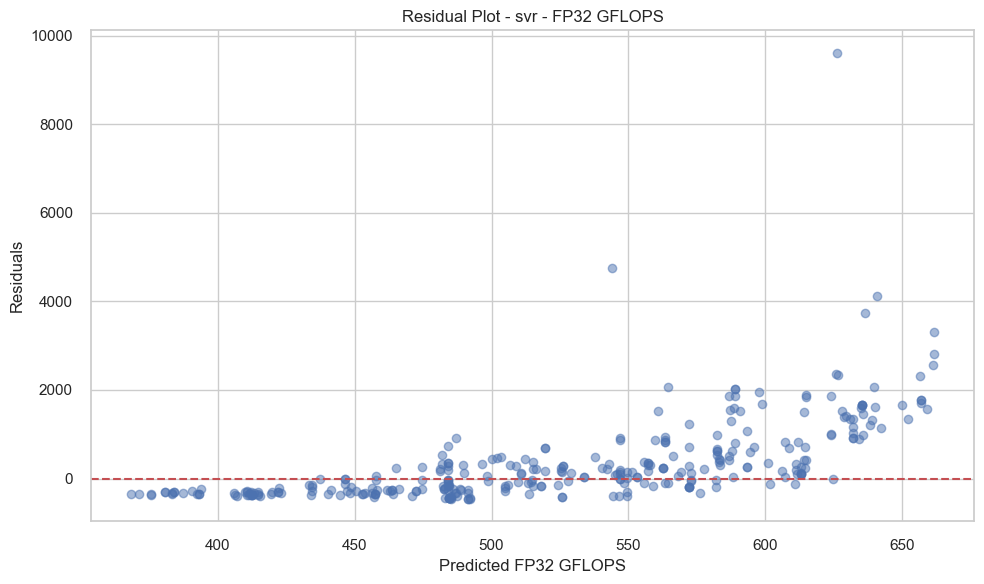

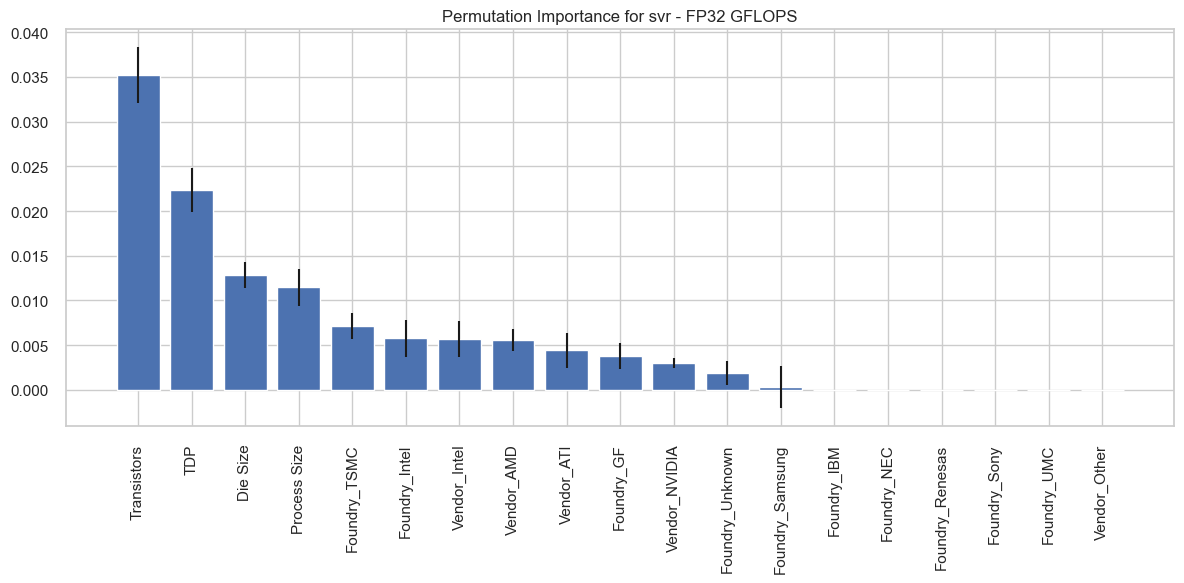


                 Model Comparison for CPU Frequency Prediction                  

               Model            MSE        RMSE         MAE        R²
6           catboost  108917.890683  330.027106  249.720729  0.809349
4            xgboost  109555.171812  330.991196  246.713421  0.808234
3      random_forest  113106.716616  336.313420  251.593019  0.802017
2      decision_tree  114522.288494  338.411419  249.890605  0.799539
5           lightgbm  118130.280640  343.700859  261.868082  0.793224
7     neural_network  274829.061925  524.241416  419.269188  0.518937
1   ridge_regression  287669.276593  536.348093  427.184126  0.496461
0  linear_regression  287763.014092  536.435471  427.354046  0.496297
8                svr  512719.600838  716.044413  589.658501  0.102531


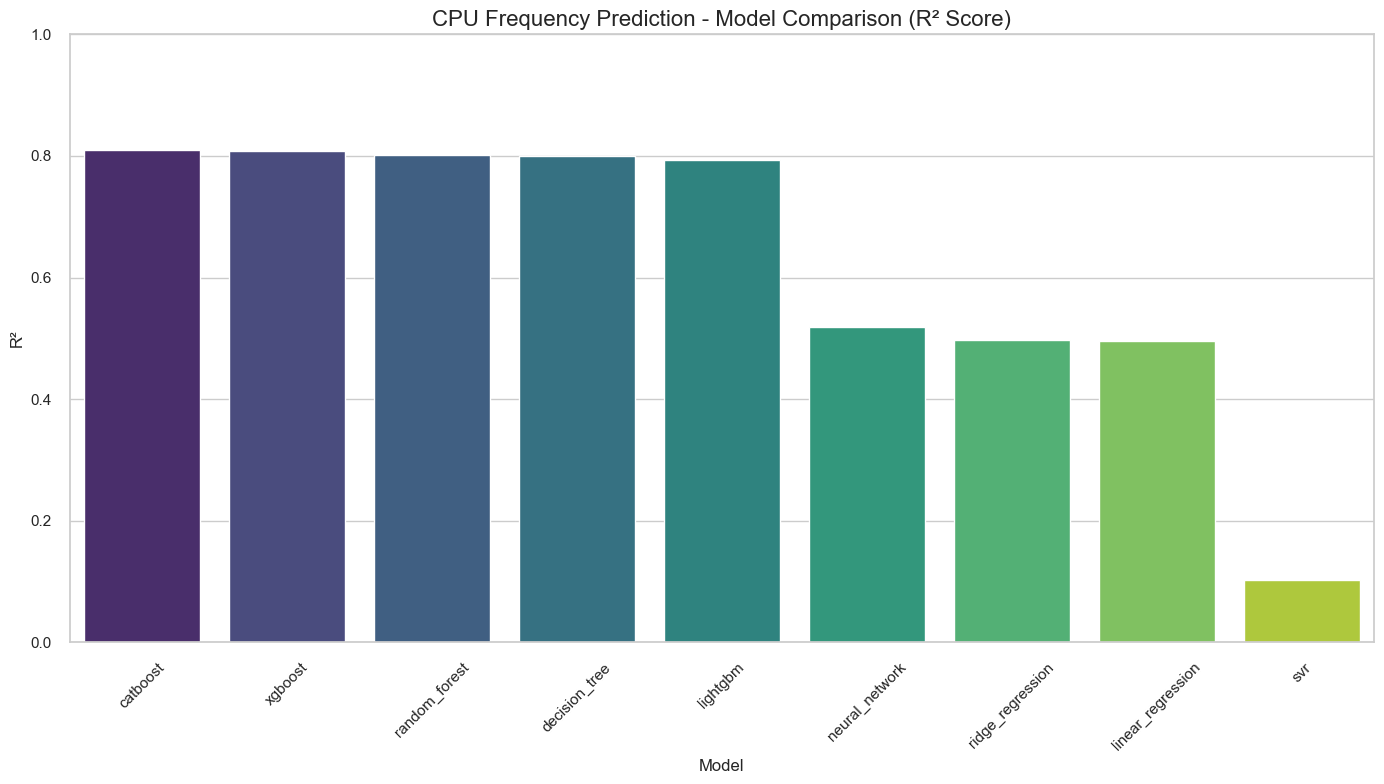


                Model Comparison for GPU FP32 GFLOPS Prediction                 

               Model           MSE         RMSE         MAE        R²
6           catboost  7.115982e+04   266.757975  157.099617  0.930231
3      random_forest  7.398664e+04   272.004845  150.749683  0.927459
4            xgboost  8.476547e+04   291.145096  156.355322  0.916891
5           lightgbm  9.043013e+04   300.716037  163.332430  0.911337
2      decision_tree  9.970588e+04   315.762382  163.315116  0.902243
7     neural_network  2.102747e+05   458.557237  277.108468  0.793835
1   ridge_regression  3.878667e+05   622.789458  422.184454  0.619714
0  linear_regression  3.948781e+05   628.393303  429.588580  0.612839
8                svr  1.040130e+06  1019.867808  588.909179 -0.019803


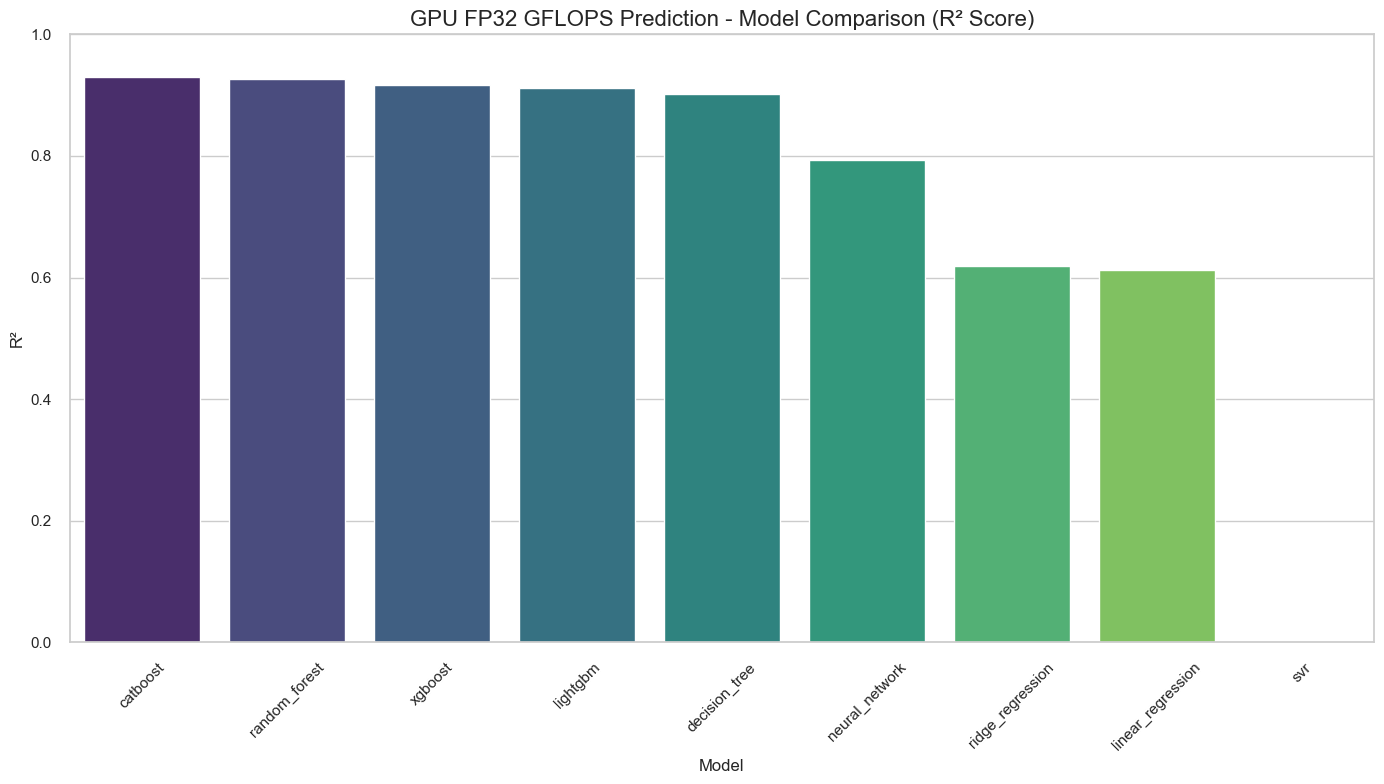


Best model for CPU Frequency prediction: catboost
Best model for GPU FP32 GFLOPS prediction: catboost


In [102]:
# Main execution for CPU data prediction
print("\n" + "="*80)
print("CPU Frequency Prediction Models".center(80))
print("="*80 + "\n")

for model_name, model in regressors.items():
    # Print model name header
    print('\n\n')
    print(f"  {model_name}  ".center(50, '-'))
    print('\n')
    
    # Ensure folders exist
    ensure_folder_exists('cpu', model_name)
    
    # Train the model
    trained_model = train_model(
        model, model_name, 
        X_cpu_train_scaled, y_cpu_train, 
        X_cpu_test_scaled, y_cpu_test, 
        'cpu', 'CPU Frequency'
    )
    
    # Get CV predictions for training data
    y_train_pred = get_predictions(
        trained_model, X_cpu_train_scaled, y_cpu_train, 
        None, model_name, 'cpu'
    )
    
    # Get predictions for test data using the trained model
    trained_model_final = train_model(
        model, model_name, 
        X_cpu_train_scaled, y_cpu_train, 
        X_cpu_test_scaled, y_cpu_test, 
        'cpu', 'CPU Frequency', 
        final_model=True
    )
    y_test_pred = trained_model_final.predict(X_cpu_test_scaled)
    
    # Display metrics for training and test data
    print("Training Data Metrics:")
    display_metrics(y_cpu_train, y_train_pred, model_name)
    
    print("Test Data Metrics:")
    display_metrics(y_cpu_test, y_test_pred, model_name)
    
    # Plots for test data
    plot_actual_vs_predicted(y_cpu_test, y_test_pred, model_name, 'CPU Frequency')
    plot_residuals(y_cpu_test, y_test_pred, model_name, 'CPU Frequency')
    
    # Plot feature importance
    plot_feature_importance(trained_model_final, X_cpu_test_scaled, y_cpu_test, 
                           model_name, X_cpu.columns, 'CPU Frequency')

# Main execution for GPU data prediction
print("\n" + "="*80)
print("GPU FP32 GFLOPS Prediction Models".center(80))
print("="*80 + "\n")

for model_name, model in regressors.items():
    # Print model name header
    print('\n\n')
    print(f"  {model_name}  ".center(50, '-'))
    print('\n')
    
    # Ensure folders exist
    ensure_folder_exists('gpu', model_name)
    
    # Train the model
    trained_model = train_model(
        model, model_name, 
        X_gpu_train_scaled, y_gpu_train, 
        X_gpu_test_scaled, y_gpu_test, 
        'gpu', 'FP32 GFLOPS'
    )
    
    # Get CV predictions for training data
    y_train_pred = get_predictions(
        trained_model, X_gpu_train_scaled, y_gpu_train, 
        None, model_name, 'gpu'
    )
    
    # Get predictions for test data using the trained model
    trained_model_final = train_model(
        model, model_name, 
        X_gpu_train_scaled, y_gpu_train, 
        X_gpu_test_scaled, y_gpu_test, 
        'gpu', 'FP32 GFLOPS', 
        final_model=True
    )
    y_test_pred = trained_model_final.predict(X_gpu_test_scaled)
    
    # Display metrics for training and test data
    print("Training Data Metrics:")
    display_metrics(y_gpu_train, y_train_pred, model_name)
    
    print("Test Data Metrics:")
    display_metrics(y_gpu_test, y_test_pred, model_name)
    
    # Plots for test data
    plot_actual_vs_predicted(y_gpu_test, y_test_pred, model_name, 'FP32 GFLOPS')
    plot_residuals(y_gpu_test, y_test_pred, model_name, 'FP32 GFLOPS')
    
    # Plot feature importance
    plot_feature_importance(trained_model_final, X_gpu_test_scaled, y_gpu_test, 
                           model_name, X_gpu.columns, 'FP32 GFLOPS')

# Function to compare all models based on their test metrics
def compare_models(models_dict, X_train, y_train, X_test, y_test, dataset_name, target_name):
    """Compare all models based on their performance metrics"""
    results = []
    
    for model_name, model in models_dict.items():
        # Load the trained model
        model_path = Path(f'saved_models_final/{dataset_name}/{model_name}/{model_name}_model.sav')
        try:
            trained_model = joblib.load(model_path)
        except FileNotFoundError:
            # Train if model doesn't exist
            trained_model = train_model(
                model, model_name, X_train, y_train, X_test, y_test, 
                dataset_name, target_name, final_model=True
            )
        
        # Make predictions
        y_pred = trained_model.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Store results
        results.append({
            'Model': model_name,
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2
        })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Sort by R² (higher is better)
    results_df = results_df.sort_values('R²', ascending=False)
    
    return results_df

# Compare all models for CPU data
print("\n" + "="*80)
print("Model Comparison for CPU Frequency Prediction".center(80))
print("="*80 + "\n")

cpu_comparison = compare_models(
    regressors, 
    X_cpu_train_scaled, y_cpu_train, 
    X_cpu_test_scaled, y_cpu_test, 
    'cpu', 'CPU Frequency'
)
print(cpu_comparison)

# Create bar plot for CPU model comparison
plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='R²', data=cpu_comparison, palette='viridis')
plt.title('CPU Frequency Prediction - Model Comparison (R² Score)', fontsize=16)
plt.xticks(rotation=45)
plt.ylim(0, 1.0)  # R² typically ranges from 0 to 1
plt.tight_layout()
plt.show()

# Compare all models for GPU data
print("\n" + "="*80)
print("Model Comparison for GPU FP32 GFLOPS Prediction".center(80))
print("="*80 + "\n")

gpu_comparison = compare_models(
    regressors, 
    X_gpu_train_scaled, y_gpu_train, 
    X_gpu_test_scaled, y_gpu_test, 
    'gpu', 'FP32 GFLOPS'
)
print(gpu_comparison)

# Create bar plot for GPU model comparison
plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='R²', data=gpu_comparison, palette='viridis')
plt.title('GPU FP32 GFLOPS Prediction - Model Comparison (R² Score)', fontsize=16)
plt.xticks(rotation=45)
plt.ylim(0, 1.0)  # R² typically ranges from 0 to 1
plt.tight_layout()
plt.show()

# Identify the best performing model for each dataset
best_cpu_model_name = cpu_comparison.iloc[0]['Model']
best_gpu_model_name = gpu_comparison.iloc[0]['Model']

print(f"\nBest model for CPU Frequency prediction: {best_cpu_model_name}")
print(f"Best model for GPU FP32 GFLOPS prediction: {best_gpu_model_name}")

# Optional: Hyperparameter tuning for the best models
# You could add code here to perform hyperparameter tuning using GridSearchCV
# or RandomizedSearchCV for the best performing models